# HASP Data Diagnostic Notebook

***

## This notebook will walk you through how to examine the input spectra for the HASP `coadd` code and determine what was and was not included in the co-added data product output.

## Learning Goals

By the end of this tutorial, you will:
- Understand the reasons an input spectrum may be rejected from a co-added data product
- Learn how to examine output logs from `coadd` and header keywords from COS and STIS data products to determine which datasets were rejected
- Know how to plot co-added spectra and the constituent datasets
- Be able to re-run `coadd` with the default rejection criteria turned off to create custom co-additions

## Table of Contents
**0. [Introduction](#introduction)**

**1. [Example 1: Two COS datasets rejected for different reasons](#cosweirddata)**

\- 1.1 [Obtaining Data Products](#data1)

\- 1.2 [Examining Output Logs](#logs1)

\- 1.3 [Plotting Constituent Spectra](#plots1)

\- 1.4 [Running `coadd`](#coadd1)

**2. [Example 2: A STIS dataset with `POSTARG` offsets](#stisdithers)**

\- 2.1 [Obtaining Data Products](#data2)

\- 2.2 [Examining Output Logs](#logs2)

\- 2.3 [Running `coadd`](#coadd2)

**3. [Example 3: A STIS dataset with rejected flux](#stisflux)**

\- 3.1 [Obtaining Data Products](#data3)

\- 3.2 [Examining Output Logs](#logs3)

\- 3.3 [Running `coadd`](#coadd3)

<a id = introduction></a>
## 0. Introduction

The [Hubble Advanced Spectral Products (HASP) `coadd` code](https://github.com/spacetelescope/hasp) is a script that co-adds spectra of the same target within a program. This software is able to co-add data taken with the spectrographs onboard the [Hubble Space Telescope (HST)](https://www.stsci.edu/hst); the [Space Telescope Imaging Spectrograph (STIS)](https://www.stsci.edu/hst/instrumentation/stis) and the [Cosmic Origins Spectrograph (COS)](https://www.stsci.edu/hst/instrumentation/cos). The [Hubble Spectroscopic Legacy Archive (HSLA)](https://archive.stsci.edu/missions-and-data/hst/hasp) uses this script to co-add these instruments’ data from [The Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) to create high-quality spectra with a broad wavelength coverage (whenever possible from the ultraviolet to the near-infrared) that is publicly available for the scientific community. The script first co-adds the observations for each grating for a given visit, then it combines all gratings for the observation set. Finally, it co-adds the spectra of each observation set in the program to produce a fully co-added spectra for each target in a program.

The data fed into the `coadd` code from each program are selected via a MAST archive search query. This query performs some filtering at the same time and rejects certain bad quality datasets. Then, the `coadd` script itself performs another series of checks on the input spectra before computing the co-added data products. Lastly, while `coadd` is running, it will check the flux of the input data in each wavelength bin for a given mode against an initial coadd that includes all input data. If the median flux of an input spectrum is lower than a given threshold against the co-add, it will be removed. `coadd` will iterate until no more spectra are rejected.

There are several different reasons an exposure could be rejected before the co-addition is running. These fall into three categories. First, the data in a given program may have quality issues that lead to its removal. Second, there are some observation configurations that `coadd` is not equipped to handle. Last, the target itself may pose an issue, such as for moving targets, or the target flux may be intrinsically variable, making the `coadd` flux filter reject good spectra. Finer details of these rejection criteria are summarized below:

| Reason                                                                                                             | Modes Effected |
|--------------------------------------------------------------------------------------------------------------------|----------------|
|**Observing Issues**                                                |                |
| Guide star acquisition failures                                                                                    | Any            |
| Observatory or detector failure events                                                                             | Any            |
| EXPFLAG (exposure data quality flag) header keyword is anything other than 'NORMAL'                                | Any            |
| EXPTIME (exposure time) is zero seconds                                                                            | Any            |
| Actual exposure time is less than 80% of the planned exposure time                                                 | Any            |
| FGSLOCK (fine guidance system lock) is not 'FINE', i.e., guide star tracking was not locked                        | Any            |
| SHUTTER is closed                                                                                                  | COS            |
| **Observation Parameters**                                             |                |
| POSTARG1 != 0.0, i.e., there is a pointing offset                                                                  | Any            |
| POSTARG2 != 0.0 and P1_PURPS != 'DITHER', i.e., there is a pointing offset not in the disperson direction          | STIS           |
| PATTERN1 = STIS-PERP-TO-SLIT and P1_FRAME = POS-TARG, i.e., there is a cross-dispersion direction pointing pattern | STIS           |
| P1_PURPS = MOSAIC, i.e., there is a mosaic pointing offset pattern                                                 | STIS           |
| OPT_ELEM (grating) = PRISM                                                                                         | STIS           |
| APERTURE = BOA (Bright Object Aperture)                                                                            | COS            |
| For the COS/NUV grating G230L, stripe C spectra are rejected due to vignetting                                     | COS/NUV        |
| **Target Parameters**                                               |                |
| Moving targets (MTFLAG = True)                                                                                     | Any            |
| Variable targets*                                                                                              | Any            |
| Extended targets*                                                                                               | Any            |

*These are not rejected by default, but some exposures may be removed by the code's flux checking routine.

The HSLA team chose to reject these cases after careful analysis, but understand there are always some exceptions to these rules that we do not handle. This custom co-addition notebook will show users how to find out why a dataset was rejected and how to produce their own co-adds in cases where the data are still valuable.

_Throughout this notebook, users will download coadded datasets and output log files that are hosted on STScI's Box file storage website. Please note that the format and text in the log file may change slightly as new code builds are released. This notebook will be updated in Spring 2024 to reflect any text changes in the logs._

### Imports
We will be using multiple libraries to retrieve and analyze data. We will use:
* `ipympl` to enable interactive plots in this notebook
* `astroquery.mast Observations` to download COS and STIS data
* `pathlib.Path` to create product and data directories
* `matplotlib.pyplot` to plot spectra
* `numpy` to perform calculations and array manipulation
* `astropy.io fits` to work with FITS files
* `glob` to work with multiple files in our directories
* `os` to interact with the operating system
* `shutil` to perform directory and file operations
  
We recommend creating a HASP-specific `conda` environment when co-adding spectra. You can checkout our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook to create such an environment. Alternatively, you can also download the required dependencies to run this notebook with the terminal command:
```
pip install -r requirements.txt
```
This will download the dependencies that are necessary to run this current notebook. Let's import all of our packages that we will use in this notebook and print our `conda` environment by running the next cell:

In [1]:
import ipympl
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack
from astroquery.mast import Observations
import glob
import os
import shutil
from pathlib import Path

%matplotlib widget
plt.rcParams['figure.figsize'] = 10, 6
plt.style.use('seaborn-v0_8-colorblind')

print("Currently active conda environment:", os.environ.get("CONDA_PREFIX"))

Currently active conda environment: None


Please make sure the environment that contains the HASP script dependencies is activated or you download the dependencies listed in the `requirements.txt` file, otherwise **_you will NOT be able to run the co-add code._**

We will define a function that will be utilized throughout the notebook when downloading MAST data using `astroquery`:

In [2]:
def consolidate_files(data_path):
    '''
    Consolidate all files to single directory; necessary for HASP script run.
    ---------------
    Input:
    str data_path : ./mastDownload/HST folders paths; files to be moved here
    ---------------
    Output:
    None. Files moved to data_path and data_path/products.
    The ./mastDownload/HST directory is deleted.
    '''
    # The path to all obs_id folders
    mast_path = f"{data_path}/mastDownload/HST/"
    try:
        # Check if mastDownload exists
        if not os.path.exists(mast_path):
            print(f"Directory {mast_path} doesn't exist.")
            return
        # Get a list of the obs_id paths in mastDownload
        obs_id_dirs = os.listdir(mast_path)
        # Iterate through each obs_id folder and move the files
        for obs_id in obs_id_dirs:
            obs_id_path = os.path.join(mast_path, obs_id)
            files = glob.glob(obs_id_path + "/*fits")
            for file in files:
                file_path = Path(file)
                new_path = data_path / file_path.name
                shutil.move(file, new_path)
        # Now we can remove the mastDownload directory
        if os.path.exists(mast_path):
            shutil.rmtree(f"{data_path}/mastDownload")
        # Now moving all coadd products to /data_path/products
        product_path = Path(f"{data_path}/products/")
        if not os.path.exists(product_path):
            print(f"Directory {product_path} doesn't exist.")
            return
        coadd_files = glob.glob(f"{data_path}/*cspec.fits")
        for file in coadd_files:
            file_path = Path(file)
            new_path = product_path / file_path.name
            shutil.move(file, new_path)
    except Exception as e:
        print(f"An error occurred: {e}")

***

<a id = cosweirddata></a>
# Example 1: Two COS datasets rejected for different reasons

<a id = data1></a>
### 1.1 Obtaining Data Products

For this example, we will be looking at Program ID 12715, which observed four flux standard white dwarf stars with COS.
We will use `astroquery` to download the calibrated and coadded datasets for this program. For a more in-depth tutorial on downloading this data, please check out the [CoaddTutorial.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/CoaddTutorial) notebook in this repository.

We will create a folder for the `X1D` and `X1DSUM` products, called `./12715`, and a subfolder called `products`, which will store the coadded data. The log file for this coadd is currently not available for download on MAST, but is in this repository. It will be available for download in a future build. This log file is called `HASP_12715.out`

In [3]:
# Creating directories for our data and coadded products
datadir_ex1 = Path("./12715/")
productsdir_ex1 = Path("./12715/products/")

datadir_ex1.mkdir(exist_ok=True)
productsdir_ex1.mkdir(exist_ok=True)

Let's download our datasets for this program by running the cell below:

In [4]:
# Querying and downloading calibrated products
query_ex1 = Observations.query_criteria(
    proposal_id=12715, 
    provenance_name="CALCOS"
)

prodlist_ex1 = Observations.get_product_list(
    query_ex1
)

prodlist_ex1 = Observations.filter_products(
    prodlist_ex1,
    project=["CALCOS"],
    productSubGroupDescription=["X1D", "X1DSUM"]
)

# Querying and downloading coadded products
query_ex1_coadds = Observations.query_criteria(
    proposal_id=12715, 
    provenance_name="HASP"
)

prodlist_ex1_coadds = Observations.get_product_list(
    query_ex1_coadds
)

prodlist_ex1_coadds = Observations.filter_products(
    prodlist_ex1_coadds, 
    productType="SCIENCE",
    productSubGroupDescription="CSPEC"
)

# Combining the two product lists
combined_ex1 = vstack([prodlist_ex1, prodlist_ex1_coadds])

# Downloading the products
Observations.download_products(
    combined_ex1,
    download_dir=str(datadir_ex1)
)

# Organizing the files 
consolidate_files(datadir_ex1)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Now we will use `glob` to make a list of every `X1D` file available in MAST for this PID. We will print out a table of some table information on the program:

In [5]:
allfiles = glob.glob(os.path.join(datadir_ex1, '*_x1d.fits'))
print('rootname  target  visit  grating')

for x1d in sorted(allfiles):
    hdr0 = fits.getheader(x1d, ext=0)
    print(hdr0['rootname'], hdr0['targname'],
          hdr0['obset_id'], hdr0['opt_elem'])

print("-----------------------------------")
print(f"N files from MAST = {len(allfiles)}")

rootname  target  visit  grating
lbui01e7s WD0947+857 01 G140L
lbui01ebs WD0947+857 01 G140L
lbui01eds WD0947+857 01 G130M
lbui01efs WD0947+857 01 G130M
lbui01ehs WD0947+857 01 G130M
lbui02f1q WD0947+857 02 G140L
lbui02f3q WD0947+857 02 G140L
lbui02f5q WD0947+857 02 G130M
lbui02f7q WD0947+857 02 G130M
lbui02f9q WD0947+857 02 G130M
lbui03m6q WD0947+857 03 G140L
lbui03maq WD0947+857 03 G140L
lbui03mkq WD0947+857 03 G130M
lbui03mmq WD0947+857 03 G130M
lbui03mpq WD0947+857 03 G130M
lbui04m6q WD0947+857 04 G140L
lbui04meq WD0947+857 04 G140L
lbui04mhq WD0947+857 04 G130M
lbui04mlq WD0947+857 04 G130M
lbui04mnq WD0947+857 04 G130M
lbui05aaq WD0947+857 05 G140L
lbui05acq WD0947+857 05 G140L
lbui05ajq WD0947+857 05 G130M
lbui05amq WD0947+857 05 G130M
lbui05aoq WD0947+857 05 G130M
lbui06guq WD0947+857 06 G140L
lbui06gyq WD0947+857 06 G140L
lbui06h0q WD0947+857 06 G130M
lbui06h2q WD0947+857 06 G130M
lbui06h4q WD0947+857 06 G130M


lbui07dkq WD0947+857 07 G140L
lbui07dpq WD0947+857 07 G140L
lbui07duq WD0947+857 07 G130M
lbui07dwq WD0947+857 07 G130M
lbui07e2q WD0947+857 07 G130M
lbui08c6q WD0947+857 08 G140L
lbui08coq WD0947+857 08 G140L
lbui08ctq WD0947+857 08 G130M
lbui08cvq WD0947+857 08 G130M
lbui08cxq WD0947+857 08 G130M
lbui09bgq WD0947+857 09 G140L
lbui09bjq WD0947+857 09 G140L
lbui09boq WD0947+857 09 G130M
lbui09bqq WD0947+857 09 G130M
lbui09bsq WD0947+857 09 G130M
lbui10teq WD0947+857 10 G140L
lbui10tgq WD0947+857 10 G140L
lbui10tiq WD0947+857 10 G130M
lbui10tkq WD0947+857 10 G130M
lbui10tmq WD0947+857 10 G130M
lbui11evq WD0947+857 11 G140L
lbui11f0q WD0947+857 11 G140L
lbui11f8q WD0947+857 11 G130M
lbui11faq WD0947+857 11 G130M
lbui12ycq WD0947+857 12 G140L
lbui12ygq WD0947+857 12 G140L
lbui12yiq WD0947+857 12 G130M
lbui12ykq WD0947+857 12 G130M
lbui12ymq WD0947+857 12 G130M
lbui13jhq WD0947+857 13 G140L
lbui13jmq WD0947+857 13 G140L
lbui13joq WD0947+857 13 G130M
lbui13jqq WD0947+857 13 G130M
lbui13jsq 

<a id = logs1></a>
### 1.2 Examining Output Logs and Headers

Now lets open the `coadd` output log to see which files were used in the coadd.

In [6]:
# Set up path to the coadd log file
logfile = './logfiles/HASP_12715.out'

with open(logfile, 'r') as f:
    [print(line.strip()) for line in f.readlines()]

Program_id = BUI, Proposal_id=12715
First cut: 125
With obsnums: 125
with times: 125
wht pdq_summary removed: 124
Number removed = 1
dataset archive_class  ... member_type  exptime
0    lbui01e7s           CAL  ...         NaN  250.016
1    lbui01ebs           CAL  ...         NaN  250.016
2    lbui01efs           CAL  ...         NaN  416.032
3    lbui02f1q           CAL  ...         NaN  250.016
4    lbui02f3q           CAL  ...         NaN  250.048
..         ...           ...  ...         ...      ...
120  lbui51lvq           CAL  ...         NaN  290.016
121  lbui51m5q           CAL  ...         NaN  346.048
122  lbui51m7q           CAL  ...         NaN  400.000
123  lbui51mbq           CAL  ...         NaN  280.032
124  lbui51mdq           CAL  ...         NaN  280.000

[124 rows x 10 columns]
with exclude removed: 124
Number removed = 0
124
File ./lbui51l6q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./lbui51lcq_x1d.fits removed from products because FGSLOCK 

As stated in the introduction, files can be removed from the co-added products in three steps. First, some files are excluded via a MAST archive query before they are even fed into `coadd`. Everything in the log file above the line that says `[124 rows x 10 columns]` is output from this query. So, in this example, we can see that 124 of the 125 files from MAST were fed into the `coadd` script. The rest of the log file gives the output from `coadd` itself. Unlike the MAST query, the `coadd` script will print a note when a file is removed, giving both the filename and the reason. Typically, data with observing issues are removed by the MAST query, while observation or target parameter issues are removed in `coadd`. Looking through the log file, we can see 9 other files were removed by `coadd` in this program:

```
File ./lbui51l6q_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ./lbui51lcq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ./lbui51lrq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ./lbui51ltq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ./lbui51lvq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ./lbui51m5q_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ./lbui51m7q_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ./lbui51mbq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ./lbui51mdq_x1d.fits removed from products because FGSLOCK = FINE/GYR0 
```

This program does not have any data that is removed by the `coadd` flux checker. If a dataset is removed, it will be printed with lines such as:

```
Using a maximum SNR of 20 in flux-based filtering \
Segment #1 from file ./lede16w8q_x1d.fits has scaled median = -54.04932196288165 \
Removing file ./lede16w8q_x1d.fits from product
```

Next, we will write a function to parse the output logs and return lists of the files that were rejected.

In [7]:
def find_rejects(logpath, pid, listofallfiles):
    """
    This function parses the coadd output log file to make a list of files that
    were input to the coadd script. The function uses the PID to find the lines
    that are listed like so in the log file:
        Creating list of unique modes from these files:
        ./lbui01e7s_x1d.fits WD0947+857 COS FUV G140L PSA 12715 (12715, '01')
        ...
        ./lbui50r5q_x1d.fits WD0308-565 COS FUV G140L PSA 12715 (12715, '50')
    Then, it compares that to the list of every file from the program that you
    download from MAST. The difference in the two lists are the rejected files.

    It looks through the log for files that were rejected by the flux checker.
    This searches for lines that are printed like so in the log file:
        Removing file ./lede16w8q_x1d.fits from product
    Because a file can be removed more than once in the creation of different
    level data products, the list returned will only include unique entries.

    Args:
        logname (string): Path to the coadd output log file
        pid (string): Proposal ID of the program
        listofallfiles (list of strings): list of every path+filename program

    Returns:
        prerejectedfiles (list of str): list of files rejected by MAST query
                                        or coadd before computations began
        fluxrejectedfiles (list of str): list of files rejected by flux checker
    """

    # Open output log and make a list of rootnames that were used in the coadd
    # Also search for rootnames that were rejected by the flux checker
    with open(logpath, 'r') as f:
        lines = f.readlines()
    coaddedfiles = []
    fluxrejectedfiles = []
    for line in lines:
        if ('./' in line.strip()) and (pid in line.strip()):
            coaddedfiles.append(line.split()[0].split('/')[1])
        if 'Removing file' in line.strip():
            fluxrejectedfiles.append(line.split()[2].split('/')[1])

    # Compare coadd list against list of all files in PID downloaded from MAST
    prerejectedfiles = []
    for filepath in listofallfiles:
        root = filepath.split('/')[-1]
        if root not in coaddedfiles:
            prerejectedfiles.append(root)

    return prerejectedfiles, np.unique(fluxrejectedfiles)

In [8]:
# Run find_rejects and print the output
listofprerejects, listoffluxrejects = find_rejects(logfile, '12715', allfiles)
print(f'Files removed before co-addition:')
[print(f"{file}") for file in sorted(listofprerejects)]
print(f'Files removed by flux checker: {sorted(listoffluxrejects)}')
print(f'Number of files removed before co-addition = {len(listofprerejects)}')
print(f'Number of files removed by flux checker = {len(listoffluxrejects)}')

Files removed before co-addition:
lbui11faq_x1d.fits
lbui51l6q_x1d.fits
lbui51lcq_x1d.fits
lbui51lrq_x1d.fits
lbui51ltq_x1d.fits
lbui51lvq_x1d.fits
lbui51m5q_x1d.fits
lbui51m7q_x1d.fits
lbui51mbq_x1d.fits
lbui51mdq_x1d.fits
Files removed by flux checker: []
Number of files removed before co-addition = 10
Number of files removed by flux checker = 0


We can see 10 files were removed before the co-addition computations were started, and none were removed during the run by the flux checker. We already knew the files in Visit 51 were removed by `coadd` (and why) by looking at the output log above. The file from Visit 11 (`lbui11faq_x1d.fits`) was removed by the MAST query, but we are not given a reason in the log. We can investigate the rejections from both visits further by inspecting the header keywords of the input spectra.

In the following cell, we make a function to read the file headers for each input spectrum. Most of the reasons for rejection that are listed in the [Introduction](#introduction) section can be found either in the primary or first extension headers. This function can be used to inspect both COS and STIS extracted data, both `x1d` or `sx1` files. Note that some keywords, such as those describing the offset patterns, are only included in STIS files.

There are a few other keywords not listed in the [Introduction](#introduction) that are useful to assess as well. These include the quality comments (`QUALCOM1`, `QUALCOM2`, `QUALCOM3`), the file date (`DATE`), and calibration software version (`CAL_VER`). 

The quality comments can hold information about the quality of a dataset. For example, they may have phrases like `Guide star acquisition failed. Actual guide mode is gyro` or `COS internal shutter closed. No counts in exposure`. If there is nothing to note for the dataset, the quality comments will be blank, but note that sometimes this can be inaccurate, as it relies on PIs to file problem reports. For STIS, these keys are in the `x1d` or `sx1` file headers. For COS, they are located in the `x1dsum` files that CalCOS creates, which are the sum of `FP-POS` exposures for a given observing mode in each visit. While these keywords do exist in COS `x1d` files, they will only be populated with comments in the `x1dsums`. To find the `x1dsum` file for these observations, we can use the `ASN_ID` keyword from the `x1ds`.

The date the file was written and the version of the software used for calibration are useful for finding datasets that are archived "statically" in MAST, meaning they are always excluded from re-calibration because doing so will crash the latest versions of the calibration pipeline. There are only a handful of statically archived datasets for COS and STIS. The reasons they need to be designated as such are usually due to detector or spacecraft issues that need very specialized processing, and this is not always captured in the quality comments. Therefore, we do not recommend using these datasets in co-adds.

In [9]:
# Make a function to read and print x1d file header information
def readheaders(prerejectedfiles, datadir):
    """
    Args:
        prerejectedfiles (list of strings): list of rejected filenames
    """

    for badfile in sorted(prerejectedfiles):
        badfilepath = os.path.join(datadir, badfile)
        print(badfilepath)
        # Open the 0th and 1st ext. headers to get data quality info
        hdr0 = fits.getheader(badfilepath, ext=0)
        hdr1 = fits.getheader(badfilepath, ext=1)

        # Note that header keywords differ between COS and STIS
        ins = hdr0['INSTRUME']

        # print lots of keywords
        print('Exposure time = {}'.format(hdr1['EXPTIME']))
        # These keywords doesn't exist in STIS data
        if ins == 'COS':
            print('Planned exposure time = {}'.format(hdr1['PLANTIME']))
            print('Shutter = {}'.format(hdr0['SHUTTER']))
        print('Aperture used = {}'.format(hdr0['APERTURE']))
        print('Grating used = {}'.format(hdr0['OPT_ELEM']))
        print('Exposure flag = {}'.format(hdr1['EXPFLAG']))
        print('Fine guiding lock = {}'.format(hdr1['FGSLOCK']))
        print(f'POSTARG1 / POSTARG2 = {hdr0["POSTARG1"]} / {hdr0["POSTARG2"]}')
        # These keywords are not present in COS x1d data
        if ins == 'STIS':
            print('Offset pattern = {}'.format(hdr0['PATTERN1']))
            print('P1 frame = {}'.format(hdr0['P1_FRAME']))
            print('P1 purpose = {}'.format(hdr0['P1_PURPS']))
            print('Quality comments')
            print('    COM1 = {}'.format(hdr0['QUALCOM1']))
            print('    COM2 = {}'.format(hdr0['QUALCOM2']))
            print('    COM3 = {}'.format(hdr0['QUALCOM3']))
        # Find the x1dsum for the COS data to get the quality comments
        if ins == 'COS':
            asn_id = hdr0['ASN_ID']
            x1dsum = os.path.join(datadir, asn_id.lower() + '_x1dsum.fits')
            if os.path.isfile(x1dsum):
                print('Quality comments from {}'.format(x1dsum))
                print('    COM1 = ' + fits.getval(x1dsum, 'QUALCOM1', ext=0))
                print('    COM2 = ' + fits.getval(x1dsum, 'QUALCOM2', ext=0))
                print('    COM3 = ' + fits.getval(x1dsum, 'QUALCOM3', ext=0))
            else:
                print('Quality comments: No x1dsum available')
        if hdr0['MTFLAG'] != 'T':
            print('Moving target? No')
        else:
            print('Moving target? Yes')
        print('Date file was written = {}'.format(hdr0['DATE']))
        print('Version of calibration software = {}'.format(hdr0['OPUS_VER']))
        print('')
        print('')

In [10]:
readheaders(listofprerejects, datadir_ex1)

12715/lbui11faq_x1d.fits
Exposure time = 415.6800231933594
Planned exposure time = 416.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments: No x1dsum available
Moving target? No
Date file was written = 2012-05-02
Version of calibration software = OPUS 2012_1


12715/lbui51l6q_x1d.fits
Exposure time = 226.016
Planned exposure time = 226.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 12715/lbui51010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-01-20
Version of calibration software = HSTDP 2022_3


12715/lbui51lcq_x1d.fits
Exposure time = 244.0
Planned exposure time = 244.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality co

Inspecting the output from the header keywords printed above, we see there is no `x1dsum` to inspect for `lbui11faq_x1d.fits`. This is unusual for COS data! We can also see that the date the file was written was in 2012, and that the version of the calibration software used to calibrate this data was from 2012. All together, this indicates that this dataset is statically archived in MAST, and so we don't recommend using it in a co-add. To see the latest versions of the calibration pipeline software, see the [HST Data Processing (HSTDP) github page](https://github.com/astroconda/astroconda-releases/tree/master/caldp).

We can also see that the quality comments are all blank for the Visit 51 datasets. We know from the output log file that these data were rejected because some of the exposure was observed using gyro guiding, which is less accurate than fine guiding that tracks targets with guide stars. Because there are no quality comments listed to indicate a target acquisition failure, this data may still be useable, and we'll explore that next. This data is of target `WD0308-565`, which was also observed in Visit 50 with the same observing setup. We can compare the fluxes of the two visits to see if Visit 51's data is alright for co-addition.

<a id = plots1></a>
### 1.3 Plotting Constituent and Co-added Spectra 

In [11]:
# Define a function to bin the data so it will plot more clearly
def downsample_1d(myarr, factor):
    """
    Downsample a 1D array by averaging over *factor* pixels.
    Crops right side if the shape is not a multiple of factor.
    Got this specific function from "Adam Ginsburg's python codes" on agpy

    myarr : numpy array

    factor : how much you want to rebin the array by
    """
    xs = myarr.shape[0]
    crarr = myarr[:xs-(xs % int(factor))]
    dsarr = np.mean(np.concatenate(
                    [[crarr[i::factor] for i in range(factor)]]),
                    axis=0)

    return dsarr

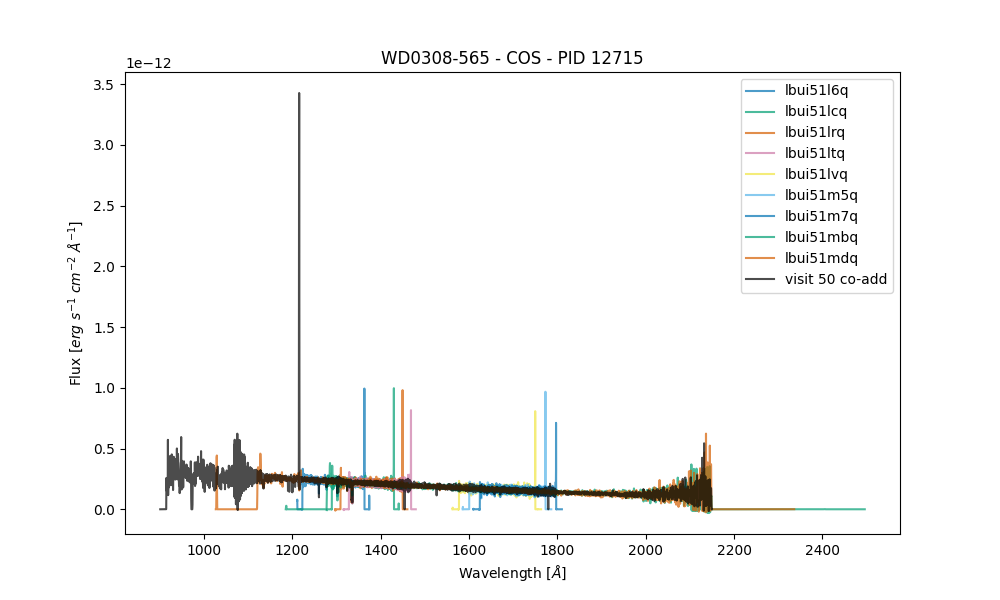

In [12]:
filename = 'hst_12715_cos_wd0308-565_cg140l-g130m-g160m_lbui50_cspec.fits'

# Set up a path to the visit 50 level co-added data product for this target
coaddfile = os.path.join(datadir_ex1, 'products', filename)
coadddata = fits.getdata(coaddfile)

# Proactively set sample factor to 6, which is size of COS resolution element
# For STIS, this is 2
samplefactor = 6

# Get the wavelength and flux data for the co-added file
wavelength = coadddata['wavelength'][0]
flux = coadddata['flux'][0]

# Set up the plot
plt.close()
plt.figure(1)

# Plot the constiuent spectra
for x1d in sorted(allfiles):
    # First check that the file is for the correct visit
    visit_id = fits.getval(x1d, 'obset_id', ext=0)
    if visit_id in ['51']:
        x1ddata = fits.getdata(x1d)
        subwave = x1ddata['wavelength'][0]
        subflux = x1ddata['flux'][0]
        plt.plot(downsample_1d(subwave, samplefactor),
                 downsample_1d(subflux, samplefactor),
                 label=fits.getval(x1d, 'rootname', ext=0),
                 alpha=0.7)

# Overplot the co-add
plt.plot(downsample_1d(wavelength, samplefactor),
         downsample_1d(flux, samplefactor),
         c='black',
         label='visit 50 co-add',
         alpha=0.7)

# Format the plot by adding titles
targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

plt.title(r'{} - {} - PID {}'.format(targ, ins, pid))
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.legend()

# Show the plot below
plt.show()

Use the interactive features in the top left corner to zoom in on a region of continuum in the plot above. The zoom button looks like a square and allows you to select a rectangular region on the plot to enlarge. We see no systematic difference in the data from Visit 51 compared to the co-added data in Visit 50, so let's add the Visit 51 data into the co-add.

<a id = coadd1></a>
### 1.4 Re-running `coadd`

Now that we know which data we want to use in the custom co-add, we must create a new directory with all the data from Visits 50 and 51. We will feed `coadd` the data from this new directory from its `wrapper` script. Running `coadd` this way essentially skips the filtering that the MAST query applies, but `coadd` itself still has some internal data quality checks, as mentioned above, so we will need to turn those off. If there is data you still want `coadd` exclude that was filtered before, be sure to not put those in the data directory!

The following cell is the call to `coadd` via its `wrapper`. The `-i` parameter is the input directory you just made. `-o` is the directory that will contain the newly created co-added products. The `-k` turns off the data quality filtering. There is more information about this in our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook.

In [13]:
# Set up the path to your new data directory
finaldatadir = os.path.join(datadir_ex1, 'newcoadddata')
os.makedirs(finaldatadir, exist_ok=True)

# Copy all the data from visits 50 and 51 into it
filestocopy = glob.glob(os.path.join(datadir_ex1, '*50*_x1d.fits'))\
            + glob.glob(os.path.join(datadir_ex1, '*51*_x1d.fits'))

[shutil.copy(file, finaldatadir) for file in filestocopy]

# Make an output directory
os.makedirs(os.path.join(datadir_ex1, 'newcoadddata', 'products'), exist_ok=True)

To call `coadd`, we use the `!` to run from the command line. The directories here must be printed out in full - don't use variable names:

In [14]:
!swrapper -i ./12715/newcoadddata -o ./12715/newcoadddata/products -k

HASP version 0.9.6
Ullyses version 4.0.0


Creating list of unique modes from these files:
./12715/newcoadddata/lbui50qnq_x1d.fits WD0308-565 COS FUV G130M PSA 12715 (12715, '50')
./12715/newcoadddata/lbui50qpq_x1d.fits WD0308-565 COS FUV G130M PSA 12715 (12715, '50')
./12715/newcoadddata/lbui50qrq_x1d.fits WD0308-565 COS FUV G130M PSA 12715 (12715, '50')
./12715/newcoadddata/lbui50qtq_x1d.fits WD0308-565 COS FUV G130M PSA 12715 (12715, '50')
./12715/newcoadddata/lbui50qvq_x1d.fits WD0308-565 COS FUV G160M PSA 12715 (12715, '50')
./12715/newcoadddata/lbui50qzq_x1d.fits WD0308-565 COS FUV G160M PSA 12715 (12715, '50')
./12715/newcoadddata/lbui50r1q_x1d.fits WD0308-565 COS FUV G160M PSA 12715 (12715, '50')
./12715/newcoadddata/lbui50r3q_x1d.fits WD0308-565 COS FUV G140L PSA 12715 (12715, '50')
./12715/newcoadddata/lbui50r5q_x1d.fits WD0308-565 COS FUV G140L PSA 12715 (12715, '50')
./12715/newcoadddata/lbui51l6q_x1d.fits WD0308-565 COS FUV G130M PSA 12715 (12715, '51')
./12715/newcoadddata/lbui51lcq_x1d.fits WD0308-565 COS FUV G13

Processing file ./12715/newcoadddata/lbui50qpq_x1d.fits
Processing file ./12715/newcoadddata/lbui50qrq_x1d.fits
Processing file ./12715/newcoadddata/lbui50qtq_x1d.fits


/usr/share/miniconda/lib/python3.11/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


/usr/share/miniconda/lib/python3.11/site-packages/ullyses/coadd.py:238: RuntimeWarning: invalid value encountered in divide
  conversion = self.output_flux[nonzeros] / self.sumnetcounts[nonzeros]
Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g130m_lbui50_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g130m_lbui50_cspec.fits
Processing grating COS/G160M
Importing files ['./12715/newcoadddata/lbui50qvq_x1d.fits', './12715/newcoadddata/lbui50qzq_x1d.fits', './12715/newcoadddata/lbui50r1q_x1d.fits']
Processing file ./12715/newcoadddata/lbui50qvq_x1d.fits
Processing file ./12715/newcoadddata/lbui50qzq_x1d.fits
Processing file ./12715/newcoadddata/lbui50r1q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g160m_lbui50_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g160m_lbui50_cspec.fits
Processing grating COS/G140L
Importing files ['./12715/newcoadddata/lbui50r3q_x1d.fits', './12715/newcoadddata/lbui50r5q_x1d.fits']
Processing file ./12715/newcoadddata/lbui50r3q_x1d.fits


Processing file ./12715/newcoadddata/lbui50r5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l_lbui50_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l_lbui50_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1068.7-1467.5)
COS/G160M 1342-1800 (Actual: 1387.8-1795.6)
COS/G140L 901-2150 (Actual: 53.7-2395.3)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G140L
Abutting COS/G130M product to current result
With a transition wavelength of 1068.7117229613373
Abutting COS/G160M product to current result
With a transition wavelength of 1467.5089693384982
Abutting COS/G140L product to current result
With a transition wavelength of 1795.607693776611
Truncating current grating at 2150
./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l-g130m-g160m_lbui50_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddat

Processing file ./12715/newcoadddata/lbui51lrq_x1d.fits
Processing file ./12715/newcoadddata/lbui51ltq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g130m_lbui51_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g130m_lbui51_cspec.fits
Processing grating COS/G160M
Importing files ['./12715/newcoadddata/lbui51lvq_x1d.fits', './12715/newcoadddata/lbui51m5q_x1d.fits', './12715/newcoadddata/lbui51m7q_x1d.fits']
Processing file ./12715/newcoadddata/lbui51lvq_x1d.fits
Processing file ./12715/newcoadddata/lbui51m5q_x1d.fits
Processing file ./12715/newcoadddata/lbui51m7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g160m_lbui51_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g160m_lbui51_cspec.fits
Processing grating COS/G140L
Importing files ['./12715/newcoadddata/lbui51mbq_x1d.fits', './12715/newcoadddata/lbui51mdq_x1d.fits']
Processing file ./12715/newcoadddata/lbui51mbq_x1d.fits
Processing file ./12715/newcoadddata/lbui51mdq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l_lbui51_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l_lbui51_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1068.7-1467.5)
COS/G160M 1342-1800 (Actual: 1387.8-1795.6)
COS/G140L 901-2150 (Actual: 55.0-2396.5)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G140L
Abutting COS/G130M product to current result
With a transition wavelength of 1068.7214966781385
Abutting COS/G160M product to current result
With a transition wavelength of 1467.5312526490434
Abutting COS/G140L product to current result
With a transition wavelength of 1795.5753292486534
Truncating current grating at 2150
./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l-g130m-g160m_lbui51_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoaddda

Processing file ./12715/newcoadddata/lbui50qpq_x1d.fits
Processing file ./12715/newcoadddata/lbui50qrq_x1d.fits
Processing file ./12715/newcoadddata/lbui50qtq_x1d.fits
Processing file ./12715/newcoadddata/lbui51l6q_x1d.fits
Processing file ./12715/newcoadddata/lbui51lcq_x1d.fits
Processing file ./12715/newcoadddata/lbui51lrq_x1d.fits


Processing file ./12715/newcoadddata/lbui51ltq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g130m_lbui_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g130m_lbui_cspec.fits
Processing grating COS/G160M
Importing files ['./12715/newcoadddata/lbui50qvq_x1d.fits', './12715/newcoadddata/lbui50qzq_x1d.fits', './12715/newcoadddata/lbui50r1q_x1d.fits', './12715/newcoadddata/lbui51lvq_x1d.fits', './12715/newcoadddata/lbui51m5q_x1d.fits', './12715/newcoadddata/lbui51m7q_x1d.fits']
Processing file ./12715/newcoadddata/lbui50qvq_x1d.fits
Processing file ./12715/newcoadddata/lbui50qzq_x1d.fits
Processing file ./12715/newcoadddata/lbui50r1q_x1d.fits
Processing file ./12715/newcoadddata/lbui51lvq_x1d.fits


Processing file ./12715/newcoadddata/lbui51m5q_x1d.fits
Processing file ./12715/newcoadddata/lbui51m7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g160m_lbui_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_g160m_lbui_cspec.fits
Processing grating COS/G140L
Importing files ['./12715/newcoadddata/lbui50r3q_x1d.fits', './12715/newcoadddata/lbui50r5q_x1d.fits', './12715/newcoadddata/lbui51mbq_x1d.fits', './12715/newcoadddata/lbui51mdq_x1d.fits']
Processing file ./12715/newcoadddata/lbui50r3q_x1d.fits
Processing file ./12715/newcoadddata/lbui50r5q_x1d.fits
Processing file ./12715/newcoadddata/lbui51mbq_x1d.fits
Processing file ./12715/newcoadddata/lbui51mdq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l_lbui_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l_lbui_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1068.7-1467.5)
COS/G160M 1342-1800 (Actual: 1387.8-1795.6)
COS/G140L 901-2150 (Actual: 53.7-2396.4)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G140L
Abutting COS/G130M product to current result
With a transition wavelength of 1068.7117229613373
Abutting COS/G160M product to current result
With a transition wavelength of 1467.5289166810705
Abutting COS/G140L product to current result
With a transition wavelength of 1795.607693776611
Truncating current grating at 2150
./12715/newcoadddata/products/hst_12715_cos_wd0308-565_cg140l-g130m-g160m_lbui_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./12715/newcoadddata/prod

#### Replot the co-added data

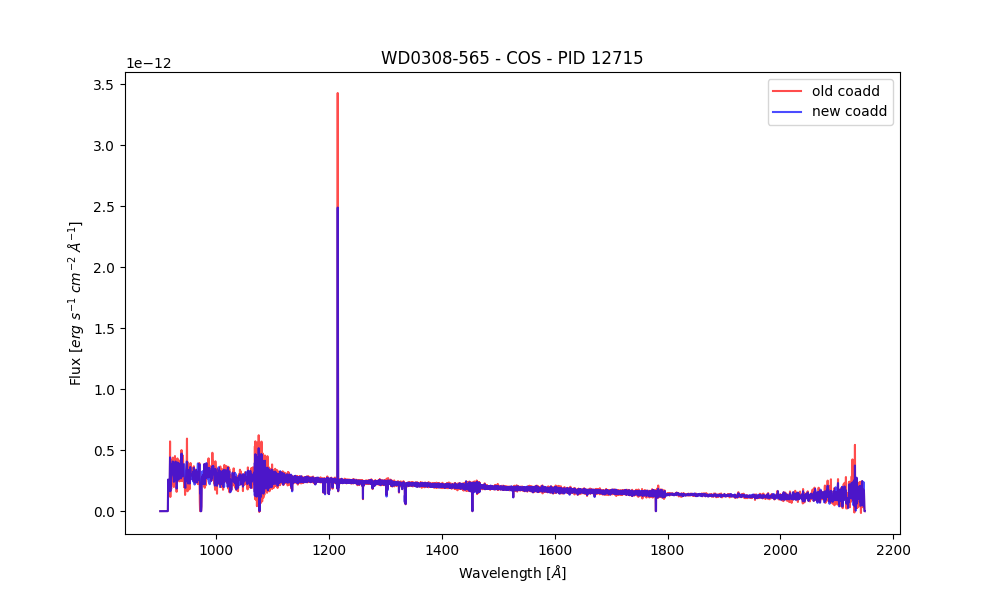

In [15]:
# Clear the older plot
plt.close()
plt.figure(2)

coadd_filename = 'hst_12715_cos_wd0308-565_cg140l-g130m-g160m_lbui_cspec.fits'

# Plot the old coadd
oldcoaddfile = os.path.join(datadir_ex1, 'products', coadd_filename)
oldcoadddata = fits.getdata(oldcoaddfile)
oldwavelength = oldcoadddata['wavelength'][0]
oldflux = oldcoadddata['flux'][0]

plt.plot(downsample_1d(oldwavelength, samplefactor),
         downsample_1d(oldflux, samplefactor),
         label='old coadd',
         color="red",
         alpha=0.7)

# Plot the new coadd
newcoaddfile = os.path.join(finaldatadir, 'products', coadd_filename)
newcoadddata = fits.getdata(newcoaddfile)
newwavelength = newcoadddata['wavelength'][0]
newflux = newcoadddata['flux'][0]

plt.plot(downsample_1d(newwavelength, samplefactor),
         downsample_1d(newflux, samplefactor),
         label='new coadd',
         color="blue",
         alpha=0.7)

targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

plt.title(r'{} - {} - PID {}'.format(targ, ins, pid))
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.legend()

# Show the plot below
plt.show()

Let's also plot the signal-to-noise to see the improvement.

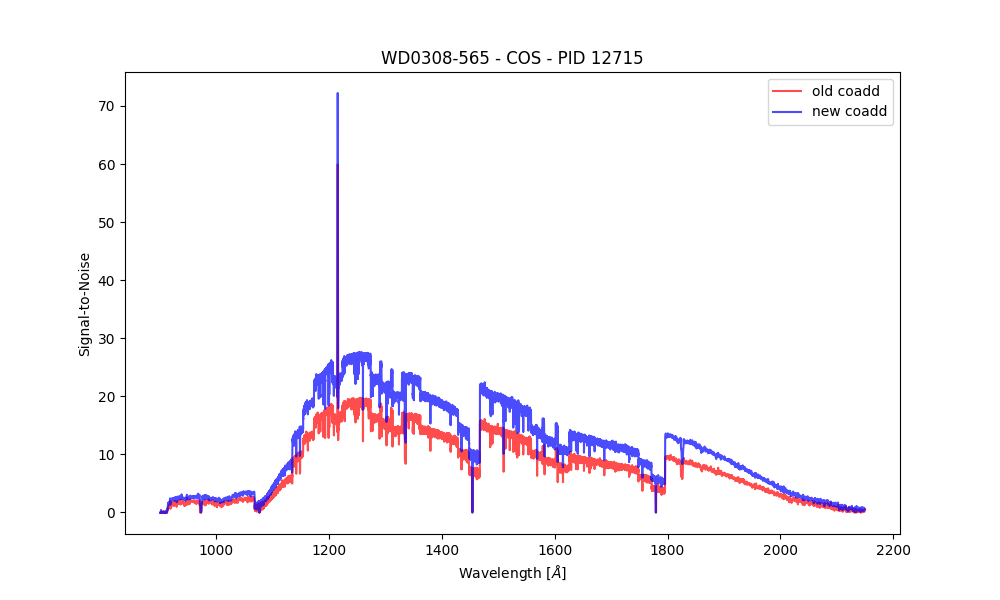

In [16]:
# Clear the older plot
plt.close()
plt.figure(3)

# Plot the old coadd SNR
oldsnr = oldcoadddata['snr'][0]
plt.plot(downsample_1d(oldwavelength, samplefactor),
         downsample_1d(oldsnr, samplefactor),
         label='old coadd',
         color="red",
         alpha=0.7)

# Plot the new coadd SNR
newsnr = newcoadddata['snr'][0]
plt.plot(downsample_1d(newwavelength, samplefactor),
         downsample_1d(newsnr, samplefactor),
         label='new coadd',
         color="blue",
         alpha=0.7)

plt.title(r'{} - {} - PID {}'.format(targ, ins, pid))
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Signal-to-Noise')
plt.legend()

# Show the plot below
plt.show()

We can tell from the plot above that the SNR is much improved by adding the Visit 51 data into the co-add!

<a id = stisdithers></a>
# Example 2: A STIS dataset with POSTARG offsets

<a id = data2></a>
### 2.1 Obtaining Data Products

For the next example, we will look at Program ID 16655, a STIS program that observed the star [Betelgeuse](http://simbad.cds.unistra.fr/simbad/sim-basic?Ident=Betelgeuse&submit=SIMBAD+search) with the `E230M` grating centered on the target and at `POSTARGs` `+/-0.25 mas` and `+/- 0.5 mas`. Each visit in the programs contains the same spatial scan in the pattern `+0.5 mas`, `-0.5 mas`, `centered`, `+0.25 mas`, `-0.25 mas`. `coadd` will co-add the centered datasets in each visit, but will reject the other datasets with `POSTARGs`. 

We will again use `astroquery` to download the dataproducts for this program. We will create a folder for the `X1D` products, called `./16655`, and a subfolder called `products`, which will store the downloaded coadded data. The log file for this program is named `HASP_16655.out`.

In [17]:
# Creating directories for our data and coadded products
datadir_ex2 = Path("./16655/")
productsdir_ex2 = Path("./16655/products/")

datadir_ex2.mkdir(exist_ok=True)
productsdir_ex2.mkdir(exist_ok=True)

In [18]:
# Querying and downloading calibrated products
query_ex2 = Observations.query_criteria(
    proposal_id=16655, 
    provenance_name="CALSTIS",
    filters="E230M",
    target_name="HD39801"
)

prodlist_ex2 = Observations.get_product_list(
    query_ex2
)

prodlist_ex2 = Observations.filter_products(
    prodlist_ex2,
    project=["CALSTIS"],
    productSubGroupDescription=["X1D"]
)

# Querying and downloading coadded products
query_ex2_coadds = Observations.query_criteria(
    proposal_id=16655, 
    provenance_name="HASP",
    filters="E230M",
    target_name="HD39801"
)

prodlist_ex2_coadds = Observations.get_product_list(
    query_ex2_coadds
)

prodlist_ex2_coadds = Observations.filter_products(
    prodlist_ex2_coadds, 
    productType="SCIENCE",
    productSubGroupDescription="CSPEC"
)

# Combining the two product lists
combined_ex2 = vstack([prodlist_ex2, prodlist_ex2_coadds])

# Downloading the products
Observations.download_products(
    combined_ex2,
    download_dir=str(datadir_ex2)
)

# Organizing the files 
consolidate_files(datadir_ex2)

# Removing files not needed for example
files_to_remove = glob.glob(f"{datadir_ex2}/oen75*")

for file in files_to_remove:
    os.remove(file)

os.remove(f"{productsdir_ex2}/hst_16655_stis_hd39801_e230m_oen751_cspec.fits")

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Now let's print some table information from our datasets:

In [19]:
allfiles = glob.glob(os.path.join(datadir_ex2, '*_x1d.fits'))
print('rootname  target  visit  grating')

for x1d in sorted(allfiles):
    hdr0 = fits.getheader(x1d, ext=0)
    print(hdr0['rootname'], hdr0['targname'],
          hdr0['obset_id'], hdr0['opt_elem'])

print("-----------------------------------")
print(f'N files from MAST = {len(allfiles)}')

rootname  target  visit  grating
oen701030 HD39801 01 E230M


oen701040 HD39801 01 E230M
oen702010 HD39801 02 E230M
oen702020 HD39801 02 E230M
oen702030 HD39801 02 E230M
oen702040 HD39801 02 E230M
oen702050 HD39801 02 E230M
oen703010 HD39801 03 E230M
oen703020 HD39801 03 E230M
oen703030 HD39801 03 E230M
oen703040 HD39801 03 E230M
oen703050 HD39801 03 E230M
oen704010 HD39801 04 E230M
oen704020 HD39801 04 E230M
oen704030 HD39801 04 E230M
oen704040 HD39801 04 E230M
oen704050 HD39801 04 E230M
oen705010 HD39801 05 E230M
oen705020 HD39801 05 E230M
oen705030 HD39801 05 E230M
oen705040 HD39801 05 E230M
oen705050 HD39801 05 E230M
-----------------------------------
N files from MAST = 22


<a id = logs2></a>
### 2.2 Examining Output Logs and Headers

Let's look at the log next.

In [20]:
# Set up path to the coadd log file
logfile = './logfiles/HASP_16655.out'

with open(logfile, 'r') as f:
    [print(line.strip()) for line in f.readlines()]

Program_id = EN7, Proposal_id=16655
First cut: 22
With obsnums: 88
with times: 22
wht pdq_summary removed: 20
Number removed = 2
dataset archive_class  ... member_type exptime
2   oen703010           CAL  ...     SCIENCE   567.0
3   oen703020           CAL  ...     SCIENCE   567.0
4   oen703050           CAL  ...     SCIENCE  2723.0
5   oen704010           CAL  ...     SCIENCE   567.0
6   oen704020           CAL  ...     SCIENCE   567.0
7   oen704030           CAL  ...     SCIENCE  2723.0
8   oen704040           CAL  ...     SCIENCE  2723.0
9   oen704050           CAL  ...     SCIENCE  2723.0
10  oen705010           CAL  ...     SCIENCE   567.0
11  oen705020           CAL  ...     SCIENCE   567.0
12  oen705030           CAL  ...     SCIENCE  2723.0
13  oen703040           CAL  ...     SCIENCE  2723.0
14  oen703030           CAL  ...     SCIENCE  2723.0
15  oen702030           CAL  ...     SCIENCE  2723.0
16  oen702020           CAL  ...     SCIENCE   567.0
17  oen702010           CAL  

We can see that two files were removed by the MAST query and that many other files were removed from the co-add because of `POSTARG` offsets, as expected. There are also some files that were removed later by the flux checker. Let's see which files, and how many were rejected next.

In [21]:
# Use the find_rejects function to make list of pre-rejected files
listofprerejects, listoffluxrejects = find_rejects(logfile, '16655', allfiles)
print(f'Files removed before co-addition: {sorted(listofprerejects)}')
print(f'Files removed by flux checker: {sorted(listoffluxrejects)}')
print(f'Number of files removed before co-addition = {len(listofprerejects)}')
print(f'Number of files removed by flux checker = {len(listoffluxrejects)}')

Files removed before co-addition: ['oen701030_x1d.fits', 'oen701040_x1d.fits', 'oen702010_x1d.fits', 'oen702020_x1d.fits', 'oen702040_x1d.fits', 'oen702050_x1d.fits', 'oen703010_x1d.fits', 'oen703020_x1d.fits', 'oen703040_x1d.fits', 'oen703050_x1d.fits', 'oen704010_x1d.fits', 'oen704020_x1d.fits', 'oen704040_x1d.fits', 'oen704050_x1d.fits', 'oen705010_x1d.fits', 'oen705020_x1d.fits', 'oen705040_x1d.fits', 'oen705050_x1d.fits']
Files removed by flux checker: ['oen702030_x1d.fits', 'oen703030_x1d.fits', 'oen705030_x1d.fits']
Number of files removed before co-addition = 18
Number of files removed by flux checker = 3


Next, look in the `x1d` headers to find the exposure information and quality comments.

In [22]:
readheaders(listofprerejects, datadir_ex2)

16655/oen701030_x1d.fits
Exposure time = 2723.0
Aperture used = 0.1X0.03
Grating used = E230M
Exposure flag = NORMAL
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Offset pattern = NONE
P1 frame = 
P1 purpose = 
Quality comments
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = STIS aperture door shut throughout exposure.  No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-12-13
Version of calibration software = HSTDP 2023_3


16655/oen701040_x1d.fits
Exposure time = 2723.0
Aperture used = 0.1X0.03
Grating used = E230M
Exposure flag = NORMAL
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.025 / 0.0
Offset pattern = NONE
P1 frame = 
P1 purpose = 
Quality comments
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = STIS aperture door shut throughout exposure.  No counts in exposure.
    COM3 = Actual exposure time significantly 

Looking through this output, we can see there are two datasets from Visit 01 that had failed target acquisitions and were removed from the co-add. The quality comments tell us the aperture door was closed through the whole exposure, so no useful data was taken. The rest of the datasets were rejected because of the `POSTARG` offsets, as we already knew, and there are no other quality issues.

This leaves only four datasets that were included in the call to create the default versions of the data products: `oen702030_x1d.fits`, `oen703030_x1d.fits`, `oen703030_x1d.fits`, and `oen705030_x1d.fits`. However, the data in Visits 2, 3, and 5 were later removed by the flux checker. Since this program was designed to probe Betelgeuse's recent flux variability, it makes sense that some of the fluxes may indeed be flagged for removal. In the custom co-add runs we perform next, we can set flags to ignore the `POSTARG` and flux filtering.

<a id = coadd1></a>
### 2.3 Running `coadd`

The structure of the program is such that each visit observed Betelgeuse at many `POSTARG` positions using the same gratings. The spatial scanning pattern is uniform, and so a user may wish to create co-adds of the spectra observed at each pointing position across all the visits. To co-add these, we can follow the same steps as in [Section 1.4](#coadd1), but set up five different directories for each pointing position. We'll create the directories:
| Directory                                                                                                             | Contains Datasets |
|--------------------------------------------------------------------------------------------------------------------|----------------|
| `newcoadddata_p50`                                                                                    | `oen702010_x1d.fits`, `oen703010_x1d.fits`, `oen704010_x1d.fits`, `oen705010_x1d.fits`            |
| `newcoadddata_p25`                                                                             | `oen702040_x1d.fits`, `oen703040_x1d.fits`, `oen704040_x1d.fits`, `oen705040_x1d.fits`            |
| `newcoadddata_p0.0`                                | `oen702030_x1d.fits`, `oen703030_x1d.fits`, `oen704030_x1d.fits`, `oen705030_x1d.fits`            |
| `newcoadddata_p-25`                                                                            | `oen702050_x1d.fits`, `oen703050_x1d.fits`, `oen704050_x1d.fits`, `oen705050_x1d.fits`            |
| `newcoadddata_p-50`                                                                            | `oen702020_x1d.fits`, `oen703020_x1d.fits`, `oen704020_x1d.fits`, `oen705020_x1d.fits`            |


Note that we'll still need to exclude the Visit 01 data that was rejected from the MAST query, as that step is bypassed when we run `coadd` from a local folder. Like in the first example, we add the flag `-k` to the call to turn off the `POSTARG` filtering. This time, we'll also add `-t -99999` to set the flux checking threshold. Setting this to a very large negative number will essentially override the flux filtering that `coadd` performs.

In [23]:
# Get a list of all files in the directory
allfiles = glob.glob(os.path.join(datadir_ex2, '*.fits'))

# Sort through all the files based on POSTARG value
postvals = ['-0.05', '-0.025', '0.0', '0.025', '0.05']
for val in postvals:
    # Make a list of files all with the same POSTARG values
    postarglist = []
    for myfile in allfiles:
        postarg = fits.getval(myfile, 'POSTARG1')
        visitid = fits.getval(myfile, 'OBSET_ID')
        if (str(postarg) == val) and (visitid != '01'):
            postarglist.append(myfile)

    # Make new directories for each list
    finaldatadir = os.path.join(datadir_ex2, f'newcoadddata_p{val}')
    os.makedirs(finaldatadir, exist_ok=True)

    # Copy this list into a new directory to coadd from
    for file in postarglist:
        print('Copying {} to {}'.format(file, finaldatadir))
        shutil.copy(file, finaldatadir)

    # Create output directories for the new coadds
    productdir = os.path.join(datadir_ex2, f'newcoadddata_p{val}', 'products')
    os.makedirs(productdir, exist_ok=True)

Copying 16655/oen705020_x1d.fits to 16655/newcoadddata_p-0.05
Copying 16655/oen704020_x1d.fits to 16655/newcoadddata_p-0.05
Copying 16655/oen702020_x1d.fits to 16655/newcoadddata_p-0.05
Copying 16655/oen703020_x1d.fits to 16655/newcoadddata_p-0.05


Copying 16655/oen702050_x1d.fits to 16655/newcoadddata_p-0.025


Copying 16655/oen705050_x1d.fits to 16655/newcoadddata_p-0.025
Copying 16655/oen703050_x1d.fits to 16655/newcoadddata_p-0.025
Copying 16655/oen704050_x1d.fits to 16655/newcoadddata_p-0.025


Copying 16655/oen702030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen704030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen705030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen703030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen705040_x1d.fits to 16655/newcoadddata_p0.025
Copying 16655/oen702040_x1d.fits to 16655/newcoadddata_p0.025
Copying 16655/oen703040_x1d.fits to 16655/newcoadddata_p0.025
Copying 16655/oen704040_x1d.fits to 16655/newcoadddata_p0.025


Copying 16655/oen705010_x1d.fits to 16655/newcoadddata_p0.05
Copying 16655/oen702010_x1d.fits to 16655/newcoadddata_p0.05
Copying 16655/oen703010_x1d.fits to 16655/newcoadddata_p0.05
Copying 16655/oen704010_x1d.fits to 16655/newcoadddata_p0.05


Run `coadd` for all the new directories:

In [24]:
!swrapper -i ./16655/newcoadddata_p-0.05 -o ./16655/newcoadddata_p-0.05/products -k -t -999
!swrapper -i ./16655/newcoadddata_p-0.025 -o ./16655/newcoadddata_p-0.025/products -k -t -999
!swrapper -i ./16655/newcoadddata_p0.0 -o ./16655/newcoadddata_p0.0/products -k -t -999
!swrapper -i ./16655/newcoadddata_p0.025 -o ./16655/newcoadddata_p0.025/products -k -t -999
!swrapper -i ./16655/newcoadddata_p0.05 -o ./16655/newcoadddata_p0.05/products -k -t -999

HASP version 0.9.6
Ullyses version 4.0.0
Creating list of unique modes from these files:
./16655/newcoadddata_p-0.05/oen702020_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '02')
./16655/newcoadddata_p-0.05/oen703020_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '03')


./16655/newcoadddata_p-0.05/oen704020_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '04')
./16655/newcoadddata_p-0.05/oen705020_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '05')
Looping over visits
Processing product (16655, '02')
Targets in visit (16655, '02'): ['HD39801']
Processing target HD39801 in visit (16655, '02')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.05/oen702020_x1d.fits']
Processing file ./16655/newcoadddata_p-0.05/oen702020_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '03')
Targets in visit (16655, '03'): ['HD39801']
Processing target HD39801 in visit (16655, '03')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.05/oen703020_x1d.fits']
Processing file ./16655/newcoadddata_p-0.05/oen703020_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '04')
Targets in visit (16655, '04'): ['HD39801']
Processing target HD39801 in visit (16655, '04')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.05/oen704020_x1d.fits']
Processing file ./16655/newcoadddata_p-0.05/oen704020_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '05')
Targets in visit (16655, '05'): ['HD39801']
Processing target HD39801 in visit (16655, '05')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.05/oen705020_x1d.fits']
Processing file ./16655/newcoadddata_p-0.05/oen705020_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits
No need to create abutted product as < 2 single grating products
Looping over proposals
Processing product 16655
Targets in proposal 16655: ['HD39801']
Processing target HD39801 in proposal 16655
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.05/oen702020_x1d.fits', './16655/newcoadddata_p-0.05/oen703020_x1d.fits', './16655/newcoadddata_p-0.05/oen704020_x1d.fits', './16655/newcoadddata_p-0.05/oen705020_x1d.fits']
Processing file ./16655/newcoadddata_p-0.05/oen702020_x1d.fits
Processing file ./16655/newcoadddata_p-0.05/oen703020_x1d.fits
Processing file ./16655/newcoadddata_p-0.05/oen704020_x1d.fits


Processing file ./16655/newcoadddata_p-0.05/oen705020_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


No good pixels for segment #24


No good pixels for segment #48


No good pixels for segment #72


./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits
Making a product from these gratings
STIS/E230M 1606.7-3119.2 (Actual: 2277.7-3072.2)
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/E230M
Truncating current grating at 3072.1598343329238
./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.05/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits


HASP version 0.9.6
Ullyses version 4.0.0
Creating list of unique modes from these files:
./16655/newcoadddata_p-0.025/oen702050_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '02')
./16655/newcoadddata_p-0.025/oen703050_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '03')
./16655/newcoadddata_p-0.025/oen704050_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '04')


./16655/newcoadddata_p-0.025/oen705050_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '05')
Looping over visits
Processing product (16655, '02')
Targets in visit (16655, '02'): ['HD39801']
Processing target HD39801 in visit (16655, '02')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.025/oen702050_x1d.fits']
Processing file ./16655/newcoadddata_p-0.025/oen702050_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '03')
Targets in visit (16655, '03'): ['HD39801']
Processing target HD39801 in visit (16655, '03')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.025/oen703050_x1d.fits']
Processing file ./16655/newcoadddata_p-0.025/oen703050_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '04')
Targets in visit (16655, '04'): ['HD39801']
Processing target HD39801 in visit (16655, '04')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.025/oen704050_x1d.fits']
Processing file ./16655/newcoadddata_p-0.025/oen704050_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '05')
Targets in visit (16655, '05'): ['HD39801']
Processing target HD39801 in visit (16655, '05')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.025/oen705050_x1d.fits']
Processing file ./16655/newcoadddata_p-0.025/oen705050_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits
No need to create abutted product as < 2 single grating products
Looping over proposals
Processing product 16655
Targets in proposal 16655: ['HD39801']
Processing target HD39801 in proposal 16655
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p-0.025/oen702050_x1d.fits', './16655/newcoadddata_p-0.025/oen703050_x1d.fits', './16655/newcoadddata_p-0.025/oen704050_x1d.fits', './16655/newcoadddata_p-0.025/oen705050_x1d.fits']
Processing file ./16655/newcoadddata_p-0.025/oen702050_x1d.fits
Processing file ./16655/newcoadddata_p-0.025/oen703050_x1d.fits
Processing file ./16655/newcoadddata_p-0.025/oen704050_x1d.fits
Processing file ./16655/newcoadddata_p-0.025/oen705050_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


No good pixels for segment #24


No good pixels for segment #48


No good pixels for segment #72


./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits
Making a product from these gratings
STIS/E230M 1606.7-3119.2 (Actual: 2277.8-3072.2)
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/E230M
Truncating current grating at 3072.1575744024462
./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p-0.025/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits


HASP version 0.9.6
Ullyses version 4.0.0
Creating list of unique modes from these files:
./16655/newcoadddata_p0.0/oen702030_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '02')


./16655/newcoadddata_p0.0/oen703030_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '03')
./16655/newcoadddata_p0.0/oen704030_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '04')
./16655/newcoadddata_p0.0/oen705030_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '05')
Looping over visits
Processing product (16655, '02')
Targets in visit (16655, '02'): ['HD39801']
Processing target HD39801 in visit (16655, '02')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.0/oen702030_x1d.fits']
Processing file ./16655/newcoadddata_p0.0/oen702030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '03')
Targets in visit (16655, '03'): ['HD39801']
Processing target HD39801 in visit (16655, '03')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.0/oen703030_x1d.fits']
Processing file ./16655/newcoadddata_p0.0/oen703030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '04')
Targets in visit (16655, '04'): ['HD39801']
Processing target HD39801 in visit (16655, '04')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.0/oen704030_x1d.fits']
Processing file ./16655/newcoadddata_p0.0/oen704030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '05')
Targets in visit (16655, '05'): ['HD39801']
Processing target HD39801 in visit (16655, '05')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.0/oen705030_x1d.fits']
Processing file ./16655/newcoadddata_p0.0/oen705030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits
No need to create abutted product as < 2 single grating products
Looping over proposals
Processing product 16655
Targets in proposal 16655: ['HD39801']
Processing target HD39801 in proposal 16655
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.0/oen702030_x1d.fits', './16655/newcoadddata_p0.0/oen703030_x1d.fits', './16655/newcoadddata_p0.0/oen704030_x1d.fits', './16655/newcoadddata_p0.0/oen705030_x1d.fits']
Processing file ./16655/newcoadddata_p0.0/oen702030_x1d.fits
Processing file ./16655/newcoadddata_p0.0/oen703030_x1d.fits
Processing file ./16655/newcoadddata_p0.0/oen704030_x1d.fits
Processing file ./16655/newcoadddata_p0.0/oen705030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


No good pixels for segment #24


No good pixels for segment #48


No good pixels for segment #72


./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits
Making a product from these gratings
STIS/E230M 1606.7-3119.2 (Actual: 2277.8-3072.2)
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/E230M
Truncating current grating at 3072.1585387983027
./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.0/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits


HASP version 0.9.6
Ullyses version 4.0.0
Creating list of unique modes from these files:
./16655/newcoadddata_p0.025/oen702040_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '02')
./16655/newcoadddata_p0.025/oen703040_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '03')
./16655/newcoadddata_p0.025/oen704040_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '04')


./16655/newcoadddata_p0.025/oen705040_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '05')
Looping over visits
Processing product (16655, '02')
Targets in visit (16655, '02'): ['HD39801']
Processing target HD39801 in visit (16655, '02')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.025/oen702040_x1d.fits']
Processing file ./16655/newcoadddata_p0.025/oen702040_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '03')
Targets in visit (16655, '03'): ['HD39801']
Processing target HD39801 in visit (16655, '03')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.025/oen703040_x1d.fits']
Processing file ./16655/newcoadddata_p0.025/oen703040_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '04')
Targets in visit (16655, '04'): ['HD39801']
Processing target HD39801 in visit (16655, '04')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.025/oen704040_x1d.fits']
Processing file ./16655/newcoadddata_p0.025/oen704040_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '05')
Targets in visit (16655, '05'): ['HD39801']
Processing target HD39801 in visit (16655, '05')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.025/oen705040_x1d.fits']
Processing file ./16655/newcoadddata_p0.025/oen705040_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits
No need to create abutted product as < 2 single grating products
Looping over proposals
Processing product 16655
Targets in proposal 16655: ['HD39801']
Processing target HD39801 in proposal 16655
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.025/oen702040_x1d.fits', './16655/newcoadddata_p0.025/oen703040_x1d.fits', './16655/newcoadddata_p0.025/oen704040_x1d.fits', './16655/newcoadddata_p0.025/oen705040_x1d.fits']
Processing file ./16655/newcoadddata_p0.025/oen702040_x1d.fits
Processing file ./16655/newcoadddata_p0.025/oen703040_x1d.fits
Processing file ./16655/newcoadddata_p0.025/oen704040_x1d.fits
Processing file ./16655/newcoadddata_p0.025/oen705040_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


No good pixels for segment #24


No good pixels for segment #48


No good pixels for segment #72


./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits
Making a product from these gratings
STIS/E230M 1606.7-3119.2 (Actual: 2277.8-3072.2)
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/E230M
Truncating current grating at 3072.15772554094
./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.025/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits


HASP version 0.9.6
Ullyses version 4.0.0
Creating list of unique modes from these files:
./16655/newcoadddata_p0.05/oen702010_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '02')


./16655/newcoadddata_p0.05/oen703010_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '03')
./16655/newcoadddata_p0.05/oen704010_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '04')
./16655/newcoadddata_p0.05/oen705010_x1d.fits HD39801 STIS NUV-MAMA E230M 0.1X0.03 16655 (16655, '05')
Looping over visits
Processing product (16655, '02')
Targets in visit (16655, '02'): ['HD39801']
Processing target HD39801 in visit (16655, '02')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.05/oen702010_x1d.fits']
Processing file ./16655/newcoadddata_p0.05/oen702010_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen702_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '03')
Targets in visit (16655, '03'): ['HD39801']
Processing target HD39801 in visit (16655, '03')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.05/oen703010_x1d.fits']
Processing file ./16655/newcoadddata_p0.05/oen703010_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen703_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '04')
Targets in visit (16655, '04'): ['HD39801']
Processing target HD39801 in visit (16655, '04')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.05/oen704010_x1d.fits']
Processing file ./16655/newcoadddata_p0.05/oen704010_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen704_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16655, '05')
Targets in visit (16655, '05'): ['HD39801']
Processing target HD39801 in visit (16655, '05')
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.05/oen705010_x1d.fits']
Processing file ./16655/newcoadddata_p0.05/oen705010_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen705_cspec.fits
No need to create abutted product as < 2 single grating products
Looping over proposals
Processing product 16655
Targets in proposal 16655: ['HD39801']
Processing target HD39801 in proposal 16655
Processing grating STIS/E230M
Importing files ['./16655/newcoadddata_p0.05/oen702010_x1d.fits', './16655/newcoadddata_p0.05/oen703010_x1d.fits', './16655/newcoadddata_p0.05/oen704010_x1d.fits', './16655/newcoadddata_p0.05/oen705010_x1d.fits']
Processing file ./16655/newcoadddata_p0.05/oen702010_x1d.fits
Processing file ./16655/newcoadddata_p0.05/oen703010_x1d.fits
Processing file ./16655/newcoadddata_p0.05/oen704010_x1d.fits


Processing file ./16655/newcoadddata_p0.05/oen705010_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for segment #0


No good pixels for segment #24


No good pixels for segment #48


No good pixels for segment #72


./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits
Making a product from these gratings
STIS/E230M 1606.7-3119.2 (Actual: 2277.7-3072.2)
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/E230M
Truncating current grating at 3072.210362810596
./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16655/newcoadddata_p0.05/products/hst_16655_stis_hd39801_e230m_oen7_cspec.fits


Now that data products have been made for all the datasets, we can plot the results.

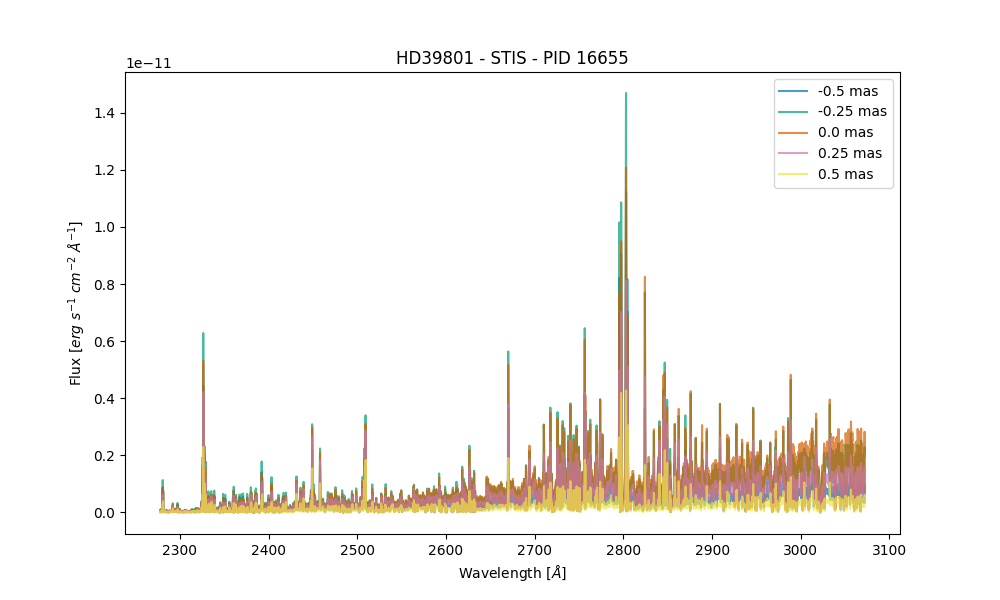

In [25]:
# Clear the older plot
plt.close()
plt.figure(4)

# Set sample factor to 2, which is size of STIS resolution element
samplefactor = 2

# Plot the coadds
for val in postvals:
    coadd_filename = 'hst_16655_stis_hd39801_e230m_oen7_cspec.fits'
    coaddfile = f"{datadir_ex2}/newcoadddata_p{val}/products/{coadd_filename}"
    label = f"{str(float(val) * 10)} mas"

    coadddata = fits.getdata(coaddfile)
    wavelength = coadddata['wavelength'][0]
    flux = coadddata['flux'][0]
    plt.plot(downsample_1d(wavelength, samplefactor),
             downsample_1d(flux, samplefactor),
             label=label,
             alpha=0.7)

    targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
    pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
    ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

    plt.title(r'{} - {} - PID {}'.format(targ, ins, pid))
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    plt.legend()

# Show the plot below
plt.show()

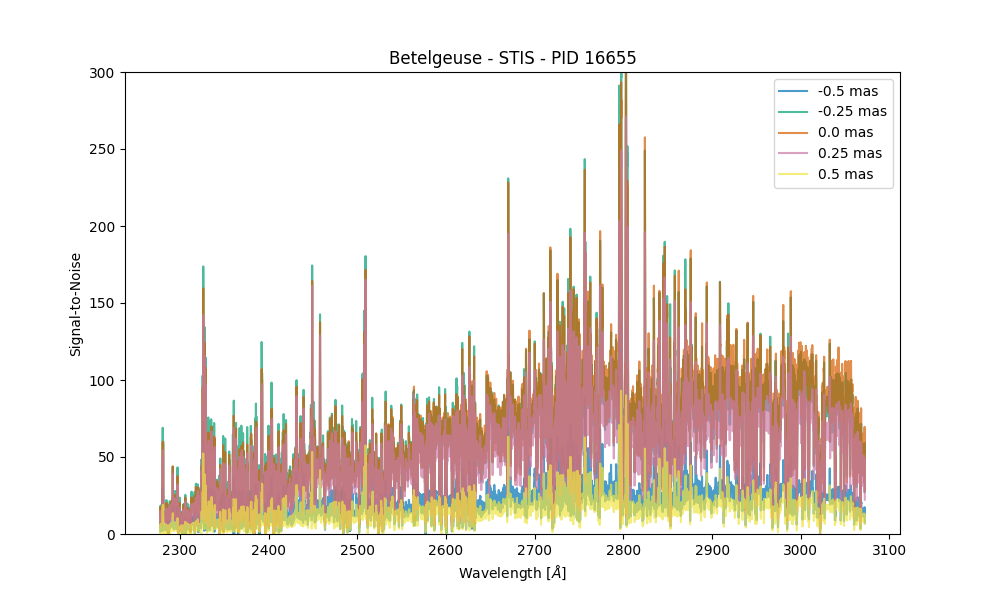

In [26]:
# Also plot the SNR
# Clear the older plot
plt.close()
plt.figure(5)

# Plot the coadds
for val in postvals:
    coadd_filename = 'hst_16655_stis_hd39801_e230m_oen7_cspec.fits'
    coaddfile = f"{datadir_ex2}/newcoadddata_p{val}/products/{coadd_filename}"
    label = f"{str(float(val) * 10)} mas"

    coadddata = fits.getdata(coaddfile)
    wavelength = coadddata['wavelength'][0]
    snr = coadddata['snr'][0]
    plt.plot(downsample_1d(wavelength, samplefactor),
             downsample_1d(snr, samplefactor),
             alpha=0.7,
             label=label)

    targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
    pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
    ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

    plt.title(r'{} - {} - PID {}'.format('Betelgeuse', ins, pid))
    plt.ylim(0, 300)
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Signal-to-Noise')
    plt.legend()

# Show the plot below
plt.show()

We can see from these plots that the flux and SNR decrease the further away from the center of the star you get.

<a id = stisflux></a>
# Example 3: A STIS dataset with flux rejection

<a id = data3></a>
### 3.1 Obtaining Data Products

For the next example, we will at Program ID 16196, a COS and STIS program that observed [MRK-817](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=mrk+817&submit=SIMBAD+search).

We will again use `astroquery` to download the dataproducts for this program. We will create a folder called `./16655` for the 1D extracted COS and STIS spectra (`x1ds` and `sx1s`) for all visits in this program, as well as the `x1dsums` for the COS data. We will also create a subfolder called `products`, which will store the downloaded coadded data. The log file for this program is named `HASP_16196.out`.

In [27]:
# Creating directories for our data and coadded products
datadir_ex3 = Path("./16196/")
productsdir_ex3 = Path("./16196/products/")

datadir_ex3.mkdir(exist_ok=True)
productsdir_ex3.mkdir(exist_ok=True)

In [28]:
# Querying and downloading calibrated products
query_ex3 = Observations.query_criteria(
    proposal_id=16196, 
    provenance_name=["CALSTIS", "CALCOS"],
    target_name="MRK-817"
)

prodlist_ex3 = Observations.get_product_list(
    query_ex3
)

prodlist_ex3 = Observations.filter_products(
    prodlist_ex3,
    project=["CALSTIS", "CALCOS"],
    productSubGroupDescription=["X1D", "X1DSUM", "SX1"]
)

# Querying and downloading coadded products
query_ex3_coadds = Observations.query_criteria(
    proposal_id=16196, 
    provenance_name="HASP",
    target_name="MRK-817"
)

prodlist_ex3_coadds = Observations.get_product_list(
    query_ex3_coadds
)

prodlist_ex3_coadds = Observations.filter_products(
    prodlist_ex3_coadds, 
    productType="SCIENCE",
    productSubGroupDescription="CSPEC"
)

# Combining the two product lists
combined_ex3 = vstack([prodlist_ex3, prodlist_ex3_coadds])

# Downloading the products
Observations.download_products(
    combined_ex3,
    download_dir=str(datadir_ex3)
)

# Organizing the files 
consolidate_files(datadir_ex3)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


In [29]:
# Use `glob` to make a list of every x1d file available in MAST for this PID
# Then print out a table of some table info on the program
# Note that this program has both x1d and sx1 extracted data products!
allfiles = glob.glob(os.path.join(datadir_ex3, '*_x1d.fits'))\
         + glob.glob(os.path.join(datadir_ex3, '*_sx1.fits'))
print('rootname  target  visit  grating')
for myfile in sorted(allfiles):
    hdr0 = fits.getheader(myfile, ext=0)
    print(hdr0['rootname'], hdr0['targname'],
          hdr0['obset_id'], hdr0['opt_elem'])
print(f'N files from MAST = {len(allfiles)}')

rootname  target  visit  grating
lede01icq MRK-817 01 G130M
lede01ieq MRK-817 01 G130M
lede01igq MRK-817 01 G130M
lede01iiq MRK-817 01 G130M
lede01iqq MRK-817 01 G160M
lede01isq MRK-817 01 G160M
lede01iuq MRK-817 01 G160M
lede01iwq MRK-817 01 G160M
lede02vbq MRK-817 02 G130M
lede02vdq MRK-817 02 G130M
lede02vfq MRK-817 02 G130M
lede02vhq MRK-817 02 G130M
lede02vjq MRK-817 02 G160M
lede02vlq MRK-817 02 G160M
lede02vnq MRK-817 02 G160M
lede02vpq MRK-817 02 G160M
lede03g0q MRK-817 03 G130M
lede03g2q MRK-817 03 G130M
lede03g4q MRK-817 03 G130M
lede03g6q MRK-817 03 G130M
lede03g8q MRK-817 03 G160M
lede03gaq MRK-817 03 G160M
lede03gcq MRK-817 03 G160M
lede03geq MRK-817 03 G160M
lede04maq MRK-817 04 G130M
lede04mcq MRK-817 04 G130M
lede04meq MRK-817 04 G130M
lede04mgq MRK-817 04 G130M
lede04miq MRK-817 04 G160M
lede04mkq MRK-817 04 G160M
lede04mmq MRK-817 04 G160M
lede04moq MRK-817 04 G160M
lede05qcq MRK-817 05 G130M
lede05qeq MRK-817 05 G130M
lede05qgq MRK-817 05 G130M
lede05qiq MRK-817 05 G

lede12m1q MRK-817 12 G130M
lede12m3q MRK-817 12 G130M
lede12m5q MRK-817 12 G130M
lede12m7q MRK-817 12 G160M
lede12m9q MRK-817 12 G160M
lede12mbq MRK-817 12 G160M
lede12mdq MRK-817 12 G160M
lede14jzq MRK-817 14 G130M
lede14k1q MRK-817 14 G130M
lede14k3q MRK-817 14 G130M
lede14k5q MRK-817 14 G130M
lede14k7q MRK-817 14 G160M
lede14k9q MRK-817 14 G160M
lede14kbq MRK-817 14 G160M
lede14kdq MRK-817 14 G160M
lede15ngq MRK-817 15 G130M
lede15niq MRK-817 15 G130M
lede15nkq MRK-817 15 G130M
lede15nmq MRK-817 15 G130M
lede15noq MRK-817 15 G160M
lede15nqq MRK-817 15 G160M
lede15nsq MRK-817 15 G160M
lede15nuq MRK-817 15 G160M
lede16vzq MRK-817 16 G130M
lede16w2q MRK-817 16 G130M
lede16w4q MRK-817 16 G130M
lede16w6q MRK-817 16 G130M
lede16w8q MRK-817 16 G160M
lede16waq MRK-817 16 G160M
lede16wcq MRK-817 16 G160M
lede16weq MRK-817 16 G160M
lede17hqq MRK-817 17 G130M
lede17hsq MRK-817 17 G130M
lede17huq MRK-817 17 G130M
lede17hwq MRK-817 17 G130M
lede17hyq MRK-817 17 G160M
lede17i0q MRK-817 17 G160M
l

lede1zlyq MRK-817 1Z G130M
lede1zm0q MRK-817 1Z G160M
lede1zm2q MRK-817 1Z G160M
lede1zm4q MRK-817 1Z G160M
lede1zm6q MRK-817 1Z G160M
lede20alq MRK-817 20 G130M
lede20anq MRK-817 20 G130M
lede20apq MRK-817 20 G130M
lede20arq MRK-817 20 G130M
lede20atq MRK-817 20 G160M
lede20avq MRK-817 20 G160M
lede20axq MRK-817 20 G160M
lede20azq MRK-817 20 G160M
lede21keq MRK-817 21 G130M
lede21kgq MRK-817 21 G130M
lede21kiq MRK-817 21 G130M
lede21kkq MRK-817 21 G130M
lede21kmq MRK-817 21 G160M
lede21koq MRK-817 21 G160M
lede21kqq MRK-817 21 G160M
lede21ksq MRK-817 21 G160M
lede22loq MRK-817 22 G130M
lede22lqq MRK-817 22 G130M
lede22lsq MRK-817 22 G130M
lede22luq MRK-817 22 G130M
lede22lwq MRK-817 22 G160M
lede22lyq MRK-817 22 G160M
lede22m0q MRK-817 22 G160M
lede22m2q MRK-817 22 G160M
lede23upq MRK-817 23 G130M
lede23urq MRK-817 23 G130M
lede23utq MRK-817 23 G130M
lede23uvq MRK-817 23 G130M
lede23uxq MRK-817 23 G160M
lede23uzq MRK-817 23 G160M
lede23v1q MRK-817 23 G160M
lede23v3q MRK-817 23 G160M
l

lede2tr9q MRK-817 2T G130M
lede2trbq MRK-817 2T G130M
lede2trdq MRK-817 2T G130M
lede2trfq MRK-817 2T G160M
lede2trhq MRK-817 2T G160M
lede2trjq MRK-817 2T G160M
lede2trlq MRK-817 2T G160M
lede2ua2q MRK-817 2U G130M
lede2ua4q MRK-817 2U G160M
lede2ua6q MRK-817 2U G160M
lede2ua8q MRK-817 2U G160M
lede2uaaq MRK-817 2U G160M
lede2uzvq MRK-817 2U G130M
lede2uzxq MRK-817 2U G130M
lede2uzzq MRK-817 2U G130M
lede2yd3q MRK-817 2Y G130M
lede2yd5q MRK-817 2Y G130M
lede2yd7q MRK-817 2Y G130M
lede2yd9q MRK-817 2Y G130M
lede2ydbq MRK-817 2Y G160M
lede2yddq MRK-817 2Y G160M
lede2ydfq MRK-817 2Y G160M
lede2ydhq MRK-817 2Y G160M
lede2zo6q MRK-817 2Z G130M
lede2zo8q MRK-817 2Z G130M
lede2zoaq MRK-817 2Z G130M
lede2zocq MRK-817 2Z G130M
lede2zoeq MRK-817 2Z G160M
lede2zogq MRK-817 2Z G160M
lede2zoiq MRK-817 2Z G160M
lede2zokq MRK-817 2Z G160M
lede30sbq MRK-817 30 G130M
lede30sdq MRK-817 30 G130M
lede30sfq MRK-817 30 G130M
lede30shq MRK-817 30 G130M
lede30sjq MRK-817 30 G160M
lede30slq MRK-817 30 G160M
l

lede3stgq MRK-817 3S G130M
lede3stjq MRK-817 3S G160M
lede3stpq MRK-817 3S G160M
lede3strq MRK-817 3S G160M
lede3sttq MRK-817 3S G160M
lede3ua1q MRK-817 3U G130M
lede3ua3q MRK-817 3U G130M
lede3ua5q MRK-817 3U G160M
lede3ua7q MRK-817 3U G160M
lede3ua9q MRK-817 3U G160M
lede3uabq MRK-817 3U G160M
lede3uzvq MRK-817 3U G130M
lede3uzyq MRK-817 3U G130M
lede3vijq MRK-817 3V G130M
lede3vimq MRK-817 3V G130M
lede3vioq MRK-817 3V G130M
lede3viqq MRK-817 3V G130M
lede3visq MRK-817 3V G160M
lede3viuq MRK-817 3V G160M
lede3viwq MRK-817 3V G160M
lede3viyq MRK-817 3V G160M
lede3wduq MRK-817 3W G130M
lede3wdwq MRK-817 3W G130M
lede3wdyq MRK-817 3W G130M
lede3we0q MRK-817 3W G130M
lede3we2q MRK-817 3W G160M
lede3we4q MRK-817 3W G160M
lede3we6q MRK-817 3W G160M
lede3we8q MRK-817 3W G160M
lede3xjdq MRK-817 3X G130M
lede3xjfq MRK-817 3X G130M
lede3xjhq MRK-817 3X G130M
lede3xjmq MRK-817 3X G130M
lede3xjoq MRK-817 3X G160M
lede3xk9q MRK-817 3X G160M
lede3xkhq MRK-817 3X G160M
lede3xkjq MRK-817 3X G160M
l

lede65e3q MRK-817 65 G130M
lede65e5q MRK-817 65 G160M
lede65e7q MRK-817 65 G160M
lede65e9q MRK-817 65 G160M
lede65ebq MRK-817 65 G160M
lede66lbq MRK-817 66 G130M
lede66ldq MRK-817 66 G130M
lede66lfq MRK-817 66 G130M
lede66lhq MRK-817 66 G130M
lede66ljq MRK-817 66 G160M
lede66llq MRK-817 66 G160M
lede66lnq MRK-817 66 G160M
lede66lpq MRK-817 66 G160M
lede67x1q MRK-817 67 G130M
lede67x3q MRK-817 67 G130M
lede67x5q MRK-817 67 G130M
lede67x7q MRK-817 67 G130M
lede67x9q MRK-817 67 G160M
lede67xbq MRK-817 67 G160M
lede67xdq MRK-817 67 G160M
lede67xfq MRK-817 67 G160M
lede68fvq MRK-817 68 G130M
lede68fxq MRK-817 68 G130M
lede68fzq MRK-817 68 G130M
lede68g1q MRK-817 68 G130M
lede68g3q MRK-817 68 G160M
lede68g5q MRK-817 68 G160M
lede68g7q MRK-817 68 G160M
lede68g9q MRK-817 68 G160M
lede69h8q MRK-817 69 G130M
lede69hbq MRK-817 69 G130M
lede69hdq MRK-817 69 G130M
lede69hfq MRK-817 69 G130M
lede69hhq MRK-817 69 G160M
lede69hjq MRK-817 69 G160M
lede69hmq MRK-817 69 G160M
lede69hoq MRK-817 69 G160M
l

oede4f050 MRK-817 4F G430L
oede4f060 MRK-817 4F G430L
oede4f070 MRK-817 4F G430L
oede4f080 MRK-817 4F G140L
oede4f090 MRK-817 4F G230L
oedea5020 MRK-817 A5 G750L
oedea5030 MRK-817 A5 G750L
oedea5040 MRK-817 A5 G750L
oedea5050 MRK-817 A5 G430L
oedea5060 MRK-817 A5 G430L
oedea5070 MRK-817 A5 G430L
oedea5080 MRK-817 A5 G230L
oedea6020 MRK-817 A6 G750L
oedea6030 MRK-817 A6 G750L
oedea6040 MRK-817 A6 G750L
oedea6050 MRK-817 A6 G430L
oedea6060 MRK-817 A6 G430L
oedea6070 MRK-817 A6 G430L
oedea6080 MRK-817 A6 G230L
oedean020 MRK-817 AN G750L
oedean030 MRK-817 AN G750L
oedean040 MRK-817 AN G750L
oedean050 MRK-817 AN G430L
oedean060 MRK-817 AN G430L
oedean070 MRK-817 AN G430L
oedean080 MRK-817 AN G230L
N files from MAST = 1443


<a id = logs3></a>
### 3.2 Examining Output Logs

In [30]:
# Set up path to the coadd log file
logfile = './logfiles/HASP_16196.out'

with open(logfile, 'r') as f:
    [print(line.strip()) for line in f.readlines()]

Program_id = EDE, Proposal_id=16196
First cut: 1547
With obsnums: 1673
with times: 1583
wht pdq_summary removed: 1583
Number removed = 0
dataset archive_class  ... member_type  exptime
0     lede01icq           CAL  ...         NaN   60.032
1     lede01ieq           CAL  ...         NaN   60.000
2     lede01igq           CAL  ...         NaN   60.000
3     lede01iiq           CAL  ...         NaN   60.032
4     lede01iqq           CAL  ...         NaN  175.040
...         ...           ...  ...         ...      ...
1578  lede3dtbq           CAL  ...         NaN  180.032
1579  lede3dt9q           CAL  ...         NaN  175.008
1580  lede81ngq           CAL  ...         NaN  307.712
1581  lede3fdrq           CAL  ...         NaN  180.000
1582  lede3fdpq           CAL  ...         NaN  175.008

[1583 rows x 10 columns]
with exclude removed: 1583
Number removed = 0
1547
File ./lede0zziq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./lede0zzkq_x1d.fits removed from products 

In [31]:
# Use find_rejects function from first example to make a list of rejected files
listofprerejects, listoffluxrejects = find_rejects(logfile, '16196', allfiles)
print(f'Files removed before co-addition:')
[print(f"{file}") for file in sorted(listofprerejects)]
print(f'Files removed by flux checker: {sorted(listoffluxrejects)}')
print(f'Number of files removed before co-addition = {len(listofprerejects)}')
print(f'Number of files removed by flux checker = {len(listoffluxrejects)}')

Files removed before co-addition:
lede0zziq_x1d.fits
lede0zzkq_x1d.fits
lede0zzmq_x1d.fits
lede0zzoq_x1d.fits
lede1ajaq_x1d.fits
lede1ajcq_x1d.fits
lede1ajeq_x1d.fits
lede1ajgq_x1d.fits
lede1ajiq_x1d.fits
lede1ajkq_x1d.fits
lede1ajmq_x1d.fits
lede1ajoq_x1d.fits
lede1dkfq_x1d.fits
lede1dkhq_x1d.fits
lede1dkjq_x1d.fits
lede1dklq_x1d.fits
lede1dknq_x1d.fits
lede1dkpq_x1d.fits
lede1dkrq_x1d.fits
lede1dktq_x1d.fits
lede1ftfq_x1d.fits
lede1fthq_x1d.fits
lede1ftjq_x1d.fits
lede1ftlq_x1d.fits
lede1ftoq_x1d.fits
lede1ftqq_x1d.fits
lede1fumq_x1d.fits
lede1fuoq_x1d.fits
lede1hhqq_x1d.fits
lede1jayq_x1d.fits
lede1jb0q_x1d.fits
lede1jb2q_x1d.fits
lede1jb4q_x1d.fits
lede1jb6q_x1d.fits
lede1jb8q_x1d.fits
lede1jbaq_x1d.fits
lede1jbcq_x1d.fits
lede1kmqq_x1d.fits
lede1kmsq_x1d.fits
lede1kmuq_x1d.fits
lede1kmwq_x1d.fits
lede1kmyq_x1d.fits
lede1kn0q_x1d.fits
lede1kn2q_x1d.fits
lede1kn4q_x1d.fits
lede1ljoq_x1d.fits
lede1ljqq_x1d.fits
lede1ljsq_x1d.fits
lede1ljuq_x1d.fits
lede1ljwq_x1d.fits
lede1ljzq_x1d.fi

As you can see, many files were removed before the co-add began, and many more were removed by the flux checker! If you're curious, we can also look through the headers for the rejected files too.

In [32]:
# Check out the headers of the files for quality
readheaders(listofprerejects, datadir_ex3)

16196/lede0zziq_x1d.fits
Exposure time = 0.0
Planned exposure time = 522.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede0z040_x1dsum.fits
    COM1 = Guide star acquisition delayed.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede0zzkq_x1d.fits
Exposure time = 0.0
Planned exposure time = 522.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede0z040_x1dsum.fits
    COM1 = Guide star acquisition delayed.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving tar

    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1dklq_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1d010_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1dknq_x1d.fits
Exposure time = 0.0
Planned exposure time = 175.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1

    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1ftjq_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1f010_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1ftlq_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating us

Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1j030_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1jbcq_x1d.fits


Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1j030_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1kmqq_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1k010_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than pl

Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1l030_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1lk6q_x1d.fits
Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1l030_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than p

    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1xz5q_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1x010_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1xz7q_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1x010_x1

    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1ylbq_x1d.fits
Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1y030_x1dsum.fits


    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1zlsq_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1z010_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede1zluq_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating us

    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2ohhq_x1d.fits
Exposure time = 195.008
Planned exposure time = 195.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2o030_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2pu8q_x1d.fits
Exposure time = 60.032000000000004
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2p010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2puaq_x1d.fits
Exposure ti

Exposure time = 180.0
Planned exposure time = 180.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2p020_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2pukq_x1d.fits
Exposure time = 195.04
Planned exposure time = 195.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2p030_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2pumq_x1d.fits
Exposure time = 195.008
Planned exposure time = 195.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.

Exposure time = 195.008
Planned exposure time = 195.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0


Quality comments from 16196/lede2q030_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2qd8q_x1d.fits
Exposure time = 195.04
Planned exposure time = 195.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2q030_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2rl6q_x1d.fits
Exposure time = 60.0
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2r010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


1

    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2sk6q_x1d.fits
Exposure time = 60.032000000000004
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2s010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2sk8q_x1d.fits
Exposure time = 60.0
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2s010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2skaq_x1d.fits
Exposure time =

Exposure time = 60.032000000000004
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2t010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2tr9q_x1d.fits
Exposure time = 60.0
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2t010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede2trbq_x1d.fits
Exposure time = 60.0
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2

    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede4dpbq_x1d.fits
Exposure time = 60.032000000000004
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede4d010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede4dpdq_x1d.fits
Exposure time = 175.008
Planned exposure time = 175.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede4d020_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede4dpfq_x1d.fits
Exposure time = 180.032

    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede99wjq_x1d.fits
Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede99030_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2023-08-17
Version of calibration software = HSTDP 2023_2


16196/lede99wlq_x1d.fits
Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede99030_

Taking a glance at the output in the cell above, we can see that many files have data quality issues. We can create a co-add with the data quality filtering left on, but the flux checker turned off. These types of data products can be useful in cases where the science doesn't depend on the accuracy of the data's absolute flux.

<a id = coadd3></a>
### 3.3 Running `coadd`

Since we want to co-add everything again, just without the flux filtering, we don't need to make a new data sub-directory. We should change the output directory name so that the original co-adds are not overwritten. We run `coadd` similarly to [Section 1.4](#coadd1), but this time with just the `-t -999` flag.

In [33]:
# Set up the path to your data directory
finaldatadir = os.path.join(datadir_ex3, 'products_nofluxfilter')

# Make on output directory
os.makedirs(finaldatadir, exist_ok=True)

And now we run `coadd`:

In [34]:
!swrapper -i ./16196/ -o ./16196/products_nofluxfilter -t -999

HASP version 0.9.6
Ullyses version 4.0.0


File ./16196/lede0zziq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede0zzkq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede0zzmq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede0zzoq_x1d.fits removed from products because EXPFLAG = NO DATA


File ./16196/lede1ajaq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ajcq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ajeq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ajgq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ajiq_x1d.fits removed from products because EXPFLAG = NO DATA


File ./16196/lede1ajkq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ajmq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ajoq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1dkfq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1dkhq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1dkjq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1dklq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1dknq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1dkpq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1dkrq_x1d.fits removed from products because EXPFLAG = NO DATA


File ./16196/lede1dktq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ftfq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1fthq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ftjq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ftlq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ftoq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ftqq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1fumq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1fuoq_x1d.fits removed from products because EXPFLAG = NO DATA


File ./16196/lede1hhqq_x1d.fits removed from products because EXPFLAG = INTERRUPTED
File ./16196/lede1jayq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1jb0q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1jb2q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1jb4q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1jb6q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1jb8q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1jbaq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1jbcq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1kmqq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1kmsq_x1d.fits removed from products because EXPFLAG = NO DATA


File ./16196/lede1kmuq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1kmwq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1kmyq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1kn0q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1kn2q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1kn4q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ljoq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ljqq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ljsq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ljuq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ljwq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ljzq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1lk4q_x1d.fits removed 

File ./16196/lede1rmmq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1rmoq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1rmqq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1rmsq_x1d.fits removed from products because EXPFLAG = NO DATA


File ./16196/lede1xz3q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1xz5q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1xz7q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1xzcq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1xzeq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1xzgq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1xziq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1xzkq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ykxq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1ykzq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1yl1q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1yl3q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1yl5q_x1d.fits removed 

File ./16196/lede1ylbq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1zlsq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1zluq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1zlwq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1zlyq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1zm0q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1zm2q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1zm4q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede1zm6q_x1d.fits removed from products because EXPFLAG = NO DATA


File ./16196/lede99w7q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede99w9q_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede99wbq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede99wdq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede99wfq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede99whq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede99wjq_x1d.fits removed from products because EXPFLAG = NO DATA
File ./16196/lede99wlq_x1d.fits removed from products because EXPFLAG = NO DATA


File ./16196/lede2ogxq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2ogzq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2oh1q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2oh7q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2oh9q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2ohbq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2ohdq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2ohhq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2pu8q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2puaq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2pucq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2pueq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/led

File ./16196/lede2qcwq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2qcyq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2qd0q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2qd2q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2qd4q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2qd6q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2qd8q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2rl6q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2rl8q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2rlaq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2rlcq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2rleq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/led

File ./16196/lede2trbq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2trdq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2trfq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2trhq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2trjq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede2trlq_x1d.fits removed from products because FGSLOCK = FINE/GYRO


File ./16196/lede4cehq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4cejq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4celq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4cenq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4cepq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4cerq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4cetq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4cevq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4dp5q_x1d.fits removed from products because FGSLOCK = FINE/GYRO


File ./16196/lede4dp7q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4dp9q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4dpbq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4dpdq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4dpfq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4dphq_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ./16196/lede4dpjq_x1d.fits removed from products because FGSLOCK = FINE/GYRO


Creating list of unique modes from these files:
./16196/lede01icq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '01')
./16196/lede01ieq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '01')
./16196/lede01igq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '01')
./16196/lede01iiq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '01')
./16196/lede01iqq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '01')
./16196/lede01isq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '01')
./16196/lede01iuq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '01')
./16196/lede01iwq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '01')
./16196/lede02vbq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '02')
./16196/lede02vdq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '02')
./16196/lede02vfq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '02')
./16196/lede02vhq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '02')
./16196/lede02vjq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '02')
./1

./16196/lede02vnq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '02')
./16196/lede02vpq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '02')
./16196/lede03g0q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '03')
./16196/lede03g2q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '03')
./16196/lede03g4q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '03')
./16196/lede03g6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '03')
./16196/lede03g8q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '03')
./16196/lede03gaq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '03')
./16196/lede03gcq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '03')
./16196/lede03geq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '03')
./16196/lede04maq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '04')
./16196/lede04mcq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '04')
./16196/lede04meq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '04')
./16196/lede04mgq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede09a9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '09')
./16196/lede09abq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '09')
./16196/lede09adq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '09')
./16196/lede09afq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '09')
./16196/lede0aetq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0a')
./16196/lede0aevq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0a')
./16196/lede0aexq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0a')
./16196/lede0aezq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0a')
./16196/lede0af2q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0a')
./16196/lede0af5q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0a')
./16196/lede0af7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0a')
./16196/lede0af9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0a')
./16196/lede0bj1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0b')
./16196/lede0bj3q_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede0kf7q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0k')
./16196/lede0kf9q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0k')
./16196/lede0kfbq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0k')
./16196/lede0kfeq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0k')
./16196/lede0kfgq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0k')
./16196/lede0kfiq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0k')
./16196/lede0kfkq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0k')
./16196/lede0loxq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0l')
./16196/lede0lozq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0l')
./16196/lede0lp1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0l')
./16196/lede0lp3q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0l')
./16196/lede0lp5q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0l')
./16196/lede0lp7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0l')
./16196/lede0lp9q_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede0qceq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0q')
./16196/lede0qcgq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0q')
./16196/lede0ra6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0r')
./16196/lede0ra8q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0r')
./16196/lede0rabq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0r')
./16196/lede0ragq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0r')
./16196/lede0raiq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0r')
./16196/lede0ranq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0r')
./16196/lede0rapq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0r')
./16196/lede0rarq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '0r')
./16196/lede0to1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0t')
./16196/lede0to4q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0t')
./16196/lede0to6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '0t')
./16196/lede0tobq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede12m1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '12')
./16196/lede12m3q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '12')
./16196/lede12m5q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '12')
./16196/lede12m7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '12')
./16196/lede12m9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '12')
./16196/lede12mbq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '12')
./16196/lede12mdq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '12')
./16196/lede14jzq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '14')
./16196/lede14k1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '14')
./16196/lede14k3q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '14')
./16196/lede14k5q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '14')
./16196/lede14k7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '14')
./16196/lede14k9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '14')
./16196/lede14kbq_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede19n5q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '19')
./16196/lede19n7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '19')
./16196/lede1bvgq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1b')
./16196/lede1bviq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1b')
./16196/lede1bvkq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1b')
./16196/lede1bvmq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1b')
./16196/lede1bvoq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1b')
./16196/lede1bvqq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1b')
./16196/lede1bvsq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1b')
./16196/lede1bvuq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1b')
./16196/lede1cf2q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1c')
./16196/lede1cf4q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1c')
./16196/lede1cf6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1c')
./16196/lede1cf8q_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede1mu3q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1m')
./16196/lede1mu5q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1m')
./16196/lede1mu7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1m')
./16196/lede1mu9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1m')
./16196/lede1noiq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1n')
./16196/lede1nokq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1n')
./16196/lede1nomq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1n')
./16196/lede1nooq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1n')
./16196/lede1noqq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1n')
./16196/lede1nosq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1n')
./16196/lede1nouq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1n')
./16196/lede1nowq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1n')
./16196/lede1oceq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1o')
./16196/lede1ocgq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede1wsxq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1w')
./16196/lede1wszq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1w')
./16196/lede1wt1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '1w')
./16196/lede1wt3q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1w')
./16196/lede1wt5q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1w')
./16196/lede1wt7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1w')
./16196/lede1wt9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '1w')
./16196/lede20alq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '20')
./16196/lede20anq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '20')
./16196/lede20apq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '20')
./16196/lede20arq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '20')
./16196/lede20atq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '20')
./16196/lede20avq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '20')
./16196/lede20axq_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede24juq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '24')
./16196/lede24jwq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '24')
./16196/lede24jyq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '24')
./16196/lede24k0q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '24')
./16196/lede24k2q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '24')
./16196/lede24k4q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '24')
./16196/lede24k6q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '24')
./16196/lede25rzq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '25')
./16196/lede25s1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '25')
./16196/lede25s3q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '25')
./16196/lede25s5q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '25')
./16196/lede25s7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '25')
./16196/lede25s9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '25')
./16196/lede25sbq_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede2atmq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2a')
./16196/lede2atoq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2a')
./16196/lede2bb4q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2b')
./16196/lede2bb6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2b')
./16196/lede2bb8q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2b')
./16196/lede2bbaq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2b')
./16196/lede2bbcq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2b')
./16196/lede2bbhq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2b')
./16196/lede2bbjq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2b')
./16196/lede2bblq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2b')
./16196/lede2cisq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2c')
./16196/lede2ciuq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2c')
./16196/lede2ciwq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2c')
./16196/lede2ciyq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede2hr5q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2h')
./16196/lede2hr7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2h')
./16196/lede2hr9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2h')
./16196/lede2hrbq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2h')
./16196/lede2ib3q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2i')
./16196/lede2ib5q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2i')
./16196/lede2ib7q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2i')
./16196/lede2ib9q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2i')
./16196/lede2ibbq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2i')
./16196/lede2ibdq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2i')
./16196/lede2ibfq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2i')
./16196/lede2ibhq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2i')
./16196/lede2jjoq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2j')
./16196/lede2jjqq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede2ua8q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2u')
./16196/lede2uaaq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2u')
./16196/lede2uzvq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2u')
./16196/lede2uzxq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2u')
./16196/lede2uzzq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2u')
./16196/lede2yd3q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2y')
./16196/lede2yd5q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2y')
./16196/lede2yd7q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2y')
./16196/lede2yd9q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '2y')
./16196/lede2ydbq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2y')
./16196/lede2yddq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2y')
./16196/lede2ydfq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2y')
./16196/lede2ydhq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '2y')
./16196/lede2zo6q_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede34lrq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '34')
./16196/lede34luq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '34')
./16196/lede34lwq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '34')
./16196/lede34lyq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '34')
./16196/lede34m0q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '34')
./16196/lede34m3q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '34')
./16196/lede35xrq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '35')
./16196/lede35xtq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '35')
./16196/lede35xvq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '35')
./16196/lede35xxq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '35')
./16196/lede35xzq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '35')
./16196/lede35y1q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '35')
./16196/lede35y3q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '35')
./16196/lede35y5q_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede3bk0q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3b')
./16196/lede3bk2q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3b')
./16196/lede3bk4q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3b')
./16196/lede3bk6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3b')
./16196/lede3bk8q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3b')
./16196/lede3bkaq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3b')
./16196/lede3bkcq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3b')
./16196/lede3bkeq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3b')
./16196/lede3ck6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3c')
./16196/lede3ck8q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3c')
./16196/lede3ckaq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3c')
./16196/lede3ckcq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3c')
./16196/lede3ckeq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3c')
./16196/lede3ckgq_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede3hbtq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3h')
./16196/lede3irrq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3i')
./16196/lede3irtq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3i')
./16196/lede3irvq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3i')
./16196/lede3irxq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3i')
./16196/lede3irzq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3i')
./16196/lede3is1q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3i')
./16196/lede3is3q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3i')
./16196/lede3is6q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3i')
./16196/lede3lppq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3l')
./16196/lede3lprq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3l')
./16196/lede3lptq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3l')
./16196/lede3lpvq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3l')
./16196/lede3lpxq_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede3rh4q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3r')
./16196/lede3rh6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3r')
./16196/lede3rh8q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3r')
./16196/lede3rhaq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3r')
./16196/lede3rhcq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3r')
./16196/lede3rheq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3r')
./16196/lede3staq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3s')
./16196/lede3stcq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3s')
./16196/lede3steq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3s')
./16196/lede3stgq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3s')
./16196/lede3stjq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3s')
./16196/lede3stpq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3s')
./16196/lede3strq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3s')
./16196/lede3sttq_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede3za1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3z')
./16196/lede3za3q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3z')
./16196/lede3za5q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3z')
./16196/lede3za7q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3z')
./16196/lede3za9q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '3z')
./16196/lede3zzuq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3z')
./16196/lede3zzwq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3z')
./16196/lede3zzyq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '3z')
./16196/lede40mcq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '40')
./16196/lede40meq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '40')
./16196/lede40mgq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '40')
./16196/lede40miq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '40')
./16196/lede40mkq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '40')
./16196/lede40mmq_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede45qfq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '45')
./16196/lede45qhq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '45')
./16196/lede46ynq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '46')
./16196/lede46ypq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '46')
./16196/lede46yrq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '46')
./16196/lede46ytq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '46')
./16196/lede46yvq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '46')
./16196/lede46yxq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '46')
./16196/lede46yzq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '46')
./16196/lede46z1q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '46')
./16196/lede47b4q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '47')
./16196/lede47b6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '47')
./16196/lede47b8q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '47')
./16196/lede47baq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede51hbq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '51')
./16196/lede51hdq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '51')
./16196/lede51hfq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '51')
./16196/lede52mkq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '52')
./16196/lede52mmq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '52')
./16196/lede52moq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '52')
./16196/lede52mqq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '52')
./16196/lede53mvq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '53')
./16196/lede53mxq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '53')
./16196/lede56a3q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '56')
./16196/lede56a5q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '56')
./16196/lede56a7q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '56')
./16196/lede56ahq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '56')
./16196/lede57azq_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede63xmq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '63')
./16196/lede64imq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '64')
./16196/lede64ioq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '64')
./16196/lede64iqq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '64')
./16196/lede64isq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '64')
./16196/lede64iuq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '64')
./16196/lede64iwq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '64')
./16196/lede64iyq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '64')
./16196/lede64j0q_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '64')
./16196/lede65dxq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '65')
./16196/lede65dzq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '65')
./16196/lede65e1q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '65')
./16196/lede65e3q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '65')
./16196/lede65e5q_x1d.fits MRK-817 COS FUV G160M PS

./16196/lede70tfq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '70')
./16196/lede70thq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '70')
./16196/lede70tjq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '70')
./16196/lede71bfq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '71')
./16196/lede71bhq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '71')
./16196/lede71bjq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '71')
./16196/lede71blq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '71')
./16196/lede71bnq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '71')
./16196/lede71bpq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '71')
./16196/lede71brq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '71')
./16196/lede71btq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '71')
./16196/lede72c8q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '72')
./16196/lede72caq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '72')
./16196/lede72ccq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede80n6q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '80')
./16196/lede80n8q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '80')
./16196/lede80naq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '80')
./16196/lede81neq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '81')
./16196/lede81ngq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '81')
./16196/lede82i5q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '82')
./16196/lede82i7q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '82')
./16196/lede82i9q_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '82')
./16196/lede82ibq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '82')
./16196/lede82idq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '82')
./16196/lede82ifq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '82')
./16196/lede83ijq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '83')
./16196/lede83ilq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '83')
./16196/lede83inq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede88tjq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '88')
./16196/lede88tlq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '88')
./16196/lede88tnq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '88')
./16196/lede88tpq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '88')
./16196/lede88trq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '88')
./16196/lede89bcq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '89')
./16196/lede89beq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '89')
./16196/lede89bgq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '89')
./16196/lede89biq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '89')
./16196/lede89bkq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '89')
./16196/lede89bmq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '89')
./16196/lede89boq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '89')
./16196/lede89bqq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '89')
./16196/lede90dnq_x1d.fits MRK-817 COS FUV G130M PS

./16196/lede96ebq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '96')
./16196/lede96edq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '96')
./16196/lede96efq_x1d.fits MRK-817 COS FUV G130M PSA 16196 (16196, '96')
./16196/lede97ejq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '97')
./16196/lede97elq_x1d.fits MRK-817 COS FUV G160M PSA 16196 (16196, '97')
./16196/oede3o020_sx1.fits MRK-817 STIS CCD G750L 52X0.2 16196 (16196, '3o')
./16196/oede3o030_sx1.fits MRK-817 STIS CCD G750L 52X0.2 16196 (16196, '3o')
./16196/oede3o040_sx1.fits MRK-817 STIS CCD G750L 52X0.2 16196 (16196, '3o')
./16196/oede3o050_sx1.fits MRK-817 STIS CCD G430L 52X0.2 16196 (16196, '3o')
./16196/oede3o060_sx1.fits MRK-817 STIS CCD G430L 52X0.2 16196 (16196, '3o')
./16196/oede3o070_sx1.fits MRK-817 STIS CCD G430L 52X0.2 16196 (16196, '3o')
./16196/oede3o080_x1d.fits MRK-817 STIS FUV-MAMA G140L 52X0.2 16196 (16196, '3o')
./16196/oede3o090_x1d.fits MRK-817 STIS NUV-MAMA G230L 52X0.2 16196 (16196, '3o')
./16196/o

./16196/oedean030_sx1.fits MRK-817 STIS CCD G750L 52X0.2 16196 (16196, 'an')
./16196/oedean040_sx1.fits MRK-817 STIS CCD G750L 52X0.2 16196 (16196, 'an')
./16196/oedean050_sx1.fits MRK-817 STIS CCD G430L 52X0.2 16196 (16196, 'an')
./16196/oedean060_sx1.fits MRK-817 STIS CCD G430L 52X0.2 16196 (16196, 'an')
./16196/oedean070_sx1.fits MRK-817 STIS CCD G430L 52X0.2 16196 (16196, 'an')
./16196/oedean080_x1d.fits MRK-817 STIS NUV-MAMA G230L 52X0.2 16196 (16196, 'an')
Looping over visits
Processing product (16196, '01')
Targets in visit (16196, '01'): ['MRK-817']
Processing target MRK-817 in visit (16196, '01')
Processing grating COS/G130M
Importing files ['./16196/lede01icq_x1d.fits', './16196/lede01ieq_x1d.fits', './16196/lede01igq_x1d.fits', './16196/lede01iiq_x1d.fits']
Processing file ./16196/lede01icq_x1d.fits
Processing file ./16196/lede01ieq_x1d.fits
Processing file ./16196/lede01igq_x1d.fits
Processing file ./16196/lede01iiq_x1d.fits


/usr/share/miniconda/lib/python3.11/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


/usr/share/miniconda/lib/python3.11/site-packages/ullyses/coadd.py:238: RuntimeWarning: invalid value encountered in divide
  conversion = self.output_flux[nonzeros] / self.sumnetcounts[nonzeros]
Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede01_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede01_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede01iqq_x1d.fits', './16196/lede01isq_x1d.fits', './16196/lede01iuq_x1d.fits', './16196/lede01iwq_x1d.fits']
Processing file ./16196/lede01iqq_x1d.fits
Processing file ./16196/lede01isq_x1d.fits
Processing file ./16196/lede01iuq_x1d.fits
Processing file ./16196/lede01iwq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede01_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede01_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.326905690119
Truncating current grating at 1747.893994864158
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede01_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede01_cspec.fits
Processing product (16196, '02')
Targets in visit (16196, '02'): ['MRK-817']
Processing target MRK-817 in visit (16196, '02')
Processing grating COS/G130M
Importing files ['./

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede02_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede02_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede02vjq_x1d.fits', './16196/lede02vlq_x1d.fits', './16196/lede02vnq_x1d.fits', './16196/lede02vpq_x1d.fits']
Processing file ./16196/lede02vjq_x1d.fits
Processing file ./16196/lede02vlq_x1d.fits
Processing file ./16196/lede02vnq_x1d.fits
Processing file ./16196/lede02vpq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede02_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede02_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.2)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2274253744195
Truncating current grating at 1747.8819450777246
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede02_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede02_cspec.fits
Processing product (16196, '03')
Targets in visit (16196, '03'): ['MRK-817']
Processing target MRK-817 in visit (16196, '03')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede03_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede03_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede03g8q_x1d.fits', './16196/lede03gaq_x1d.fits', './16196/lede03gcq_x1d.fits', './16196/lede03geq_x1d.fits']
Processing file ./16196/lede03g8q_x1d.fits
Processing file ./16196/lede03gaq_x1d.fits
Processing file ./16196/lede03gcq_x1d.fits
Processing file ./16196/lede03geq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede03_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede03_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1346.0-1748.0)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2275769071362
Truncating current grating at 1747.9678824552072
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede03_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede03_cspec.fits
Processing product (16196, '04')
Targets in visit (16196, '04'): ['MRK-817']
Processing target MRK-817 in visit (16196, '04')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede04meq_x1d.fits
Processing file ./16196/lede04mgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede04_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede04_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede04miq_x1d.fits', './16196/lede04mkq_x1d.fits', './16196/lede04mmq_x1d.fits', './16196/lede04moq_x1d.fits']
Processing file ./16196/lede04miq_x1d.fits


Processing file ./16196/lede04mkq_x1d.fits
Processing file ./16196/lede04mmq_x1d.fits
Processing file ./16196/lede04moq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede04_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede04_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.3-1367.4)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.3771240606993
Truncating current grating at 1747.9190324722601
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede04_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede04_cspec.fits
Processing product (16196, '05')
Targets in visit (16196, '05'): ['MRK-817']
Processing target MRK-817 in visit (16196, '05')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede05_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede05_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede05qlq_x1d.fits', './16196/lede05r6q_x1d.fits', './16196/lede05r8q_x1d.fits', './16196/lede05raq_x1d.fits']
Processing file ./16196/lede05qlq_x1d.fits


Processing file ./16196/lede05r6q_x1d.fits
Processing file ./16196/lede05r8q_x1d.fits
Processing file ./16196/lede05raq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede05_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede05_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.5-1367.4)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.417127026532
Truncating current grating at 1747.882496538914
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede05_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede05_cspec.fits
Processing product (16196, '06')
Targets in visit (16196, '06'): ['MRK-817']
Processing target MRK-817 in visit (16196, '06')
Processing grating COS/G130M
Importing files ['./

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede06_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede06_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede06z7q_x1d.fits', './16196/lede06z9q_x1d.fits', './16196/lede06zbq_x1d.fits', './16196/lede06zdq_x1d.fits']
Processing file ./16196/lede06z7q_x1d.fits
Processing file ./16196/lede06z9q_x1d.fits
Processing file ./16196/lede06zbq_x1d.fits
Processing file ./16196/lede06zdq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede06_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede06_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1346.1-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2179271413936
Truncating current grating at 1747.931562721271
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede06_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede06_cspec.fits
Processing product (16196, '07')
Targets in visit (16196, '07'): ['MRK-817']
Processing target MRK-817 in visit (16196, '07')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede07k2q_x1d.fits
Processing file ./16196/lede07k4q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede07_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede07_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede07k6q_x1d.fits', './16196/lede07k8q_x1d.fits', './16196/lede07kaq_x1d.fits', './16196/lede07kcq_x1d.fits']
Processing file ./16196/lede07k6q_x1d.fits
Processing file ./16196/lede07k8q_x1d.fits


Processing file ./16196/lede07kaq_x1d.fits
Processing file ./16196/lede07kcq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede07_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede07_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.4-1367.4)
COS/G160M 1342-1800 (Actual: 1346.0-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.3674529863483
Truncating current grating at 1747.8336941074513
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede07_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede07_cspec.fits
Processing product (16196, '08')
Targets in visit (16196, '08'): ['MRK-817']
Processing target MRK-817 in visit (16196, '08')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede08f5q_x1d.fits
Processing file ./16196/lede08f7q_x1d.fits
Processing file ./16196/lede08fcq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede08_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede08_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede08feq_x1d.fits', './16196/lede08fgq_x1d.fits', './16196/lede08fiq_x1d.fits', './16196/lede08fkq_x1d.fits']
Processing file ./16196/lede08feq_x1d.fits


Processing file ./16196/lede08fgq_x1d.fits
Processing file ./16196/lede08fiq_x1d.fits
Processing file ./16196/lede08fkq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede08_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede08_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.3-1367.3)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2579327310818
Truncating current grating at 1747.8827802718752


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede08_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede08_cspec.fits
Processing product (16196, '09')
Targets in visit (16196, '09'): ['MRK-817']
Processing target MRK-817 in visit (16196, '09')
Processing grating COS/G130M
Importing files ['./16196/lede09a1q_x1d.fits', './16196/lede09a3q_x1d.fits', './16196/lede09a5q_x1d.fits', './16196/lede09a7q_x1d.fits']
Processing file ./16196/lede09a1q_x1d.fits
Processing file ./16196/lede09a3q_x1d.fits
Processing file ./16196/lede09a5q_x1d.fits
Processing file ./16196/lede09a7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede09_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede09_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede09a9q_x1d.fits', './16196/lede09abq_x1d.fits', './16196/lede09adq_x1d.fits', './16196/lede09afq_x1d.fits']
Processing file ./16196/lede09a9q_x1d.fits


Processing file ./16196/lede09abq_x1d.fits
Processing file ./16196/lede09adq_x1d.fits
Processing file ./16196/lede09afq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede09_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede09_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2579894554744
Truncating current grating at 1747.8828567578967
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede09_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede09_cspec.fits
Processing product (16196, '0a')
Targets in visit (16196, '0a'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0a')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0a_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0af2q_x1d.fits', './16196/lede0af5q_x1d.fits', './16196/lede0af7q_x1d.fits', './16196/lede0af9q_x1d.fits']
Processing file ./16196/lede0af2q_x1d.fits


Processing file ./16196/lede0af5q_x1d.fits
Processing file ./16196/lede0af7q_x1d.fits
Processing file ./16196/lede0af9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0a_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.7-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.3130430937558
Truncating current grating at 1747.6823166955037


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0a_cspec.fits
Processing product (16196, '0b')
Targets in visit (16196, '0b'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0b')
Processing grating COS/G130M
Importing files ['./16196/lede0bj1q_x1d.fits', './16196/lede0bj3q_x1d.fits', './16196/lede0bj5q_x1d.fits', './16196/lede0bj7q_x1d.fits']
Processing file ./16196/lede0bj1q_x1d.fits
Processing file ./16196/lede0bj3q_x1d.fits
Processing file ./16196/lede0bj5q_x1d.fits
Processing file ./16196/lede0bj7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0b_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0bj9q_x1d.fits', './16196/lede0bjbq_x1d.fits', './16196/lede0bjdq_x1d.fits', './16196/lede0bjyq_x1d.fits']
Processing file ./16196/lede0bj9q_x1d.fits


Processing file ./16196/lede0bjbq_x1d.fits
Processing file ./16196/lede0bjdq_x1d.fits
Processing file ./16196/lede0bjyq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0b_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.9-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.243265327722
Truncating current grating at 1747.7189978695003
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0b_cspec.fits
Processing product (16196, '0c')
Targets in visit (16196, '0c'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0c')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede0cvrq_x1d.fits
Processing file ./16196/lede0cvtq_x1d.fits
Processing file ./16196/lede0cvvq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0c_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0cvxq_x1d.fits', './16196/lede0cvzq_x1d.fits', './16196/lede0cw1q_x1d.fits', './16196/lede0cw3q_x1d.fits']
Processing file ./16196/lede0cvxq_x1d.fits


Processing file ./16196/lede0cvzq_x1d.fits
Processing file ./16196/lede0cw1q_x1d.fits
Processing file ./16196/lede0cw3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0c_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.3)
COS/G160M 1342-1800 (Actual: 1345.7-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2830621654111
Truncating current grating at 1747.7189283065552


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0c_cspec.fits
Processing product (16196, '0d')
Targets in visit (16196, '0d'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0d')
Processing grating COS/G130M
Importing files ['./16196/lede0df6q_x1d.fits', './16196/lede0df8q_x1d.fits', './16196/lede0dfaq_x1d.fits', './16196/lede0dfcq_x1d.fits']
Processing file ./16196/lede0df6q_x1d.fits
Processing file ./16196/lede0df8q_x1d.fits
Processing file ./16196/lede0dfaq_x1d.fits
Processing file ./16196/lede0dfcq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0d_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0dfeq_x1d.fits', './16196/lede0dfgq_x1d.fits', './16196/lede0dfiq_x1d.fits', './16196/lede0dfoq_x1d.fits']
Processing file ./16196/lede0dfeq_x1d.fits
Processing file ./16196/lede0dfgq_x1d.fits
Processing file ./16196/lede0dfiq_x1d.fits
Processing file ./16196/lede0dfoq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0d_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.153534716562
Truncating current grating at 1747.7189009804765
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0d_cspec.fits
Processing product (16196, '0i')
Targets in visit (16196, '0i'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0i')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0i_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0ikvq_x1d.fits', './16196/lede0ikxq_x1d.fits', './16196/lede0ikzq_x1d.fits', './16196/lede0il1q_x1d.fits']
Processing file ./16196/lede0ikvq_x1d.fits
Processing file ./16196/lede0ikxq_x1d.fits
Processing file ./16196/lede0ikzq_x1d.fits
Processing file ./16196/lede0il1q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0i_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.7-1366.9)
COS/G160M 1342-1800 (Actual: 1346.0-1748.0)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.949131349409
Truncating current grating at 1747.9563298335283
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0i_cspec.fits
Processing product (16196, '0j')
Targets in visit (16196, '0j'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0j')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0j_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0j_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0jw9q_x1d.fits', './16196/lede0jwbq_x1d.fits', './16196/lede0jwdq_x1d.fits', './16196/lede0jwfq_x1d.fits']
Processing file ./16196/lede0jw9q_x1d.fits
Processing file ./16196/lede0jwbq_x1d.fits
Processing file ./16196/lede0jwdq_x1d.fits
Processing file ./16196/lede0jwfq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0j_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0j_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.6-1366.7)
COS/G160M 1342-1800 (Actual: 1346.1-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.7299868866985
Truncating current grating at 1747.944135095638
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0j_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0j_cspec.fits
Processing product (16196, '0k')
Targets in visit (16196, '0k'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0k')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0k_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0k_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0kfeq_x1d.fits', './16196/lede0kfgq_x1d.fits', './16196/lede0kfiq_x1d.fits', './16196/lede0kfkq_x1d.fits']
Processing file ./16196/lede0kfeq_x1d.fits
Processing file ./16196/lede0kfgq_x1d.fits
Processing file ./16196/lede0kfiq_x1d.fits
Processing file ./16196/lede0kfkq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0k_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0k_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.5-1366.8)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.8196776207672
Truncating current grating at 1747.9319209806872
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0k_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0k_cspec.fits
Processing product (16196, '0l')
Targets in visit (16196, '0l'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0l')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0l_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0lp5q_x1d.fits', './16196/lede0lp7q_x1d.fits', './16196/lede0lp9q_x1d.fits', './16196/lede0lpbq_x1d.fits']
Processing file ./16196/lede0lp5q_x1d.fits
Processing file ./16196/lede0lp7q_x1d.fits
Processing file ./16196/lede0lp9q_x1d.fits
Processing file ./16196/lede0lpbq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0l_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.6-1366.9)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9392420144077
Truncating current grating at 1747.9074390952806
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0l_cspec.fits
Processing product (16196, '0m')
Targets in visit (16196, '0m'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0m')
Processing grating COS/G160M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0m_cspec.fits
Processing grating COS/G130M
Importing files ['./16196/lede0mz6q_x1d.fits', './16196/lede0mz8q_x1d.fits', './16196/lede0mzaq_x1d.fits', './16196/lede0mzvq_x1d.fits']
Processing file ./16196/lede0mz6q_x1d.fits
Processing file ./16196/lede0mz8q_x1d.fits
Processing file ./16196/lede0mzaq_x1d.fits
Processing file ./16196/lede0mzvq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0m_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.4-1366.8)
COS/G160M 1342-1800 (Actual: 1345.9-1748.0)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.839611497799
Truncating current grating at 1747.9564265073204
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0m_cspec.fits
Processing product (16196, '0n')
Targets in visit (16196, '0n'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0n')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0n_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0njkq_x1d.fits', './16196/lede0njmq_x1d.fits', './16196/lede0njoq_x1d.fits', './16196/lede0nk9q_x1d.fits']
Processing file ./16196/lede0njkq_x1d.fits
Processing file ./16196/lede0njmq_x1d.fits
Processing file ./16196/lede0njoq_x1d.fits


Processing file ./16196/lede0nk9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0n_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.6-1366.9)
COS/G160M 1342-1800 (Actual: 1346.0-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.94918619098
Truncating current grating at 1747.8339287513736
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0n_cspec.fits
Processing product (16196, '0o')
Targets in visit (16196, '0o'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0o')
Processing grating COS/G130M
Importing files ['./

Processing file ./16196/lede0ognq_x1d.fits
Processing file ./16196/lede0ogpq_x1d.fits
Processing file ./16196/lede0ogrq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0o_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0ogtq_x1d.fits', './16196/lede0ogvq_x1d.fits', './16196/lede0ogxq_x1d.fits', './16196/lede0ogzq_x1d.fits']
Processing file ./16196/lede0ogtq_x1d.fits
Processing file ./16196/lede0ogvq_x1d.fits


Processing file ./16196/lede0ogxq_x1d.fits
Processing file ./16196/lede0ogzq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0o_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.8-1366.9)
COS/G160M 1342-1800 (Actual: 1346.2-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.8694507172818
Truncating current grating at 1747.944111810499
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0o_cspec.fits
Processing product (16196, '0p')
Targets in visit (16196, '0p'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0p')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede0pskq_x1d.fits
Processing file ./16196/lede0psmq_x1d.fits
Processing file ./16196/lede0psoq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0p_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0psqq_x1d.fits', './16196/lede0pssq_x1d.fits', './16196/lede0psuq_x1d.fits', './16196/lede0pswq_x1d.fits']
Processing file ./16196/lede0psqq_x1d.fits
Processing file ./16196/lede0pssq_x1d.fits


Processing file ./16196/lede0psuq_x1d.fits
Processing file ./16196/lede0pswq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0p_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.4-1366.8)
COS/G160M 1342-1800 (Actual: 1346.2-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.8395162322117
Truncating current grating at 1747.9073072948245
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0p_cspec.fits
Processing product (16196, '0q')
Targets in visit (16196, '0q'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0q')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede0qc4q_x1d.fits
Processing file ./16196/lede0qc6q_x1d.fits
Processing file ./16196/lede0qc8q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0q_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0qcaq_x1d.fits', './16196/lede0qccq_x1d.fits', './16196/lede0qceq_x1d.fits', './16196/lede0qcgq_x1d.fits']
Processing file ./16196/lede0qcaq_x1d.fits


Processing file ./16196/lede0qccq_x1d.fits
Processing file ./16196/lede0qceq_x1d.fits
Processing file ./16196/lede0qcgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0q_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.3-1367.0)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9590083120634
Truncating current grating at 1747.9072224950255
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0q_cspec.fits
Processing product (16196, '0r')
Targets in visit (16196, '0r'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0r')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0r_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0r_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0raiq_x1d.fits', './16196/lede0ranq_x1d.fits', './16196/lede0rapq_x1d.fits', './16196/lede0rarq_x1d.fits']
Processing file ./16196/lede0raiq_x1d.fits
Processing file ./16196/lede0ranq_x1d.fits
Processing file ./16196/lede0rapq_x1d.fits
Processing file ./16196/lede0rarq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0r_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0r_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.5-1367.0)
COS/G160M 1342-1800 (Actual: 1346.0-1748.0)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9987820309273
Truncating current grating at 1747.9683542610364
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0r_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0r_cspec.fits
Processing product (16196, '0t')
Targets in visit (16196, '0t'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0t')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0t_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0t_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0togq_x1d.fits', './16196/lede0toiq_x1d.fits', './16196/lede0tokq_x1d.fits', './16196/lede0tomq_x1d.fits']
Processing file ./16196/lede0togq_x1d.fits
Processing file ./16196/lede0toiq_x1d.fits
Processing file ./16196/lede0tokq_x1d.fits
Processing file ./16196/lede0tomq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0t_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0t_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.6-1366.8)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.809394449967
Truncating current grating at 1747.8824963992702
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0t_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0t_cspec.fits
Processing product (16196, '0u')
Targets in visit (16196, '0u'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0u')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0u_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0uztq_x1d.fits', './16196/lede0uzvq_x1d.fits', './16196/lede0uzxq_x1d.fits', './16196/lede0uzzq_x1d.fits']
Processing file ./16196/lede0uztq_x1d.fits
Processing file ./16196/lede0uzvq_x1d.fits
Processing file ./16196/lede0uzxq_x1d.fits
Processing file ./16196/lede0uzzq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0u_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.5-1367.1)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0583583721166
Truncating current grating at 1747.8701026912433
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0u_cspec.fits
Processing product (16196, '0x')
Targets in visit (16196, '0x'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0x')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0x_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0x_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '0y')
Targets in visit (16196, '0y'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0y')
Processing grating COS/G160M
Importing files ['./16196/lede0yh2q_x1d.fits', './16196/lede0yh4q_x1d.fits']
Processing file ./16196/lede0yh2q_x1d.fits
Processing file ./16196/lede0yh4q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0y_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0y_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '0z')
Targets in visit (16196, '0z'): ['MRK-817']
Processing target MRK-817 in visit (16196, '0z')
Processing grating COS/G130M
Importing files ['./16196/lede0zz2q_x1d.fits', './16196/lede0zz4q_x1d.fits', './16196/lede0zz6q_x1d.fits', './16196/lede0zz8q_x1d.fits']
Processing file ./16196/lede0zz2q_x1d.fits
Processing file ./16196/lede0zz4q_x1d.fits
Processing file ./16196/lede0zz6q_x1d.fits


Processing file ./16196/lede0zz8q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede0z_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede0zzaq_x1d.fits', './16196/lede0zzcq_x1d.fits', './16196/lede0zzeq_x1d.fits', './16196/lede0zzgq_x1d.fits']
Processing file ./16196/lede0zzaq_x1d.fits
Processing file ./16196/lede0zzcq_x1d.fits
Processing file ./16196/lede0zzeq_x1d.fits
Processing file ./16196/lede0zzgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede0z_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1346.0-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1861183868532
Truncating current grating at 1747.7348034867864
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede0z_cspec.fits
Processing product (16196, '10')
Targets in visit (16196, '10'): ['MRK-817']
Processing target MRK-817 in visit (16196, '10')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede10j4q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede10_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede10_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede10j6q_x1d.fits', './16196/lede10j8q_x1d.fits', './16196/lede10jaq_x1d.fits', './16196/lede10jcq_x1d.fits']
Processing file ./16196/lede10j6q_x1d.fits
Processing file ./16196/lede10j8q_x1d.fits
Processing file ./16196/lede10jaq_x1d.fits
Processing file ./16196/lede10jcq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede10_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede10_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.3-1367.3)
COS/G160M 1342-1800 (Actual: 1346.1-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2978793770124
Truncating current grating at 1747.9318982160767
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede10_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede10_cspec.fits
Processing product (16196, '11')
Targets in visit (16196, '11'): ['MRK-817']
Processing target MRK-817 in visit (16196, '11')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede11aaq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede11_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede11_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede11adq_x1d.fits', './16196/lede11afq_x1d.fits', './16196/lede11ahq_x1d.fits', './16196/lede11ajq_x1d.fits']
Processing file ./16196/lede11adq_x1d.fits
Processing file ./16196/lede11afq_x1d.fits
Processing file ./16196/lede11ahq_x1d.fits


Processing file ./16196/lede11ajq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede11_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede11_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.337752894577
Truncating current grating at 1747.9319277231707
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede11_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede11_cspec.fits
Processing product (16196, '12')
Targets in visit (16196, '12'): ['MRK-817']
Processing target MRK-817 in visit (16196, '12')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede12m5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede12_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede12_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede12m7q_x1d.fits', './16196/lede12m9q_x1d.fits', './16196/lede12mbq_x1d.fits', './16196/lede12mdq_x1d.fits']
Processing file ./16196/lede12m7q_x1d.fits
Processing file ./16196/lede12m9q_x1d.fits
Processing file ./16196/lede12mbq_x1d.fits


Processing file ./16196/lede12mdq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede12_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede12_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.4-1367.3)
COS/G160M 1342-1800 (Actual: 1346.1-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.3078698171475
Truncating current grating at 1747.8217080879983
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede12_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede12_cspec.fits
Processing product (16196, '14')
Targets in visit (16196, '14'): ['MRK-817']
Processing target MRK-817 in visit (16196, '14')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede14k1q_x1d.fits
Processing file ./16196/lede14k3q_x1d.fits
Processing file ./16196/lede14k5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede14_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede14_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede14k7q_x1d.fits', './16196/lede14k9q_x1d.fits', './16196/lede14kbq_x1d.fits', './16196/lede14kdq_x1d.fits']
Processing file ./16196/lede14k7q_x1d.fits


Processing file ./16196/lede14k9q_x1d.fits
Processing file ./16196/lede14kbq_x1d.fits
Processing file ./16196/lede14kdq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede14_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede14_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2082080932832
Truncating current grating at 1747.882900606055


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede14_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede14_cspec.fits
Processing product (16196, '15')
Targets in visit (16196, '15'): ['MRK-817']
Processing target MRK-817 in visit (16196, '15')
Processing grating COS/G130M
Importing files ['./16196/lede15ngq_x1d.fits', './16196/lede15niq_x1d.fits', './16196/lede15nkq_x1d.fits', './16196/lede15nmq_x1d.fits']
Processing file ./16196/lede15ngq_x1d.fits
Processing file ./16196/lede15niq_x1d.fits
Processing file ./16196/lede15nkq_x1d.fits
Processing file ./16196/lede15nmq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede15_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede15_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede15noq_x1d.fits', './16196/lede15nqq_x1d.fits', './16196/lede15nsq_x1d.fits', './16196/lede15nuq_x1d.fits']
Processing file ./16196/lede15noq_x1d.fits


Processing file ./16196/lede15nqq_x1d.fits
Processing file ./16196/lede15nsq_x1d.fits
Processing file ./16196/lede15nuq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede15_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede15_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2480184516899
Truncating current grating at 1747.8705973106605
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede15_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede15_cspec.fits
Processing product (16196, '16')
Targets in visit (16196, '16'): ['MRK-817']
Processing target MRK-817 in visit (16196, '16')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede16_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede16_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede16w8q_x1d.fits', './16196/lede16waq_x1d.fits', './16196/lede16wcq_x1d.fits', './16196/lede16weq_x1d.fits']
Processing file ./16196/lede16w8q_x1d.fits
Processing file ./16196/lede16waq_x1d.fits
Processing file ./16196/lede16wcq_x1d.fits
Processing file ./16196/lede16weq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede16_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede16_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1084907517666
Truncating current grating at 1747.8705332315428
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede16_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede16_cspec.fits
Processing product (16196, '17')
Targets in visit (16196, '17'): ['MRK-817']
Processing target MRK-817 in visit (16196, '17')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede17hwq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede17_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede17_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede17hyq_x1d.fits', './16196/lede17i0q_x1d.fits', './16196/lede17i2q_x1d.fits', './16196/lede17i4q_x1d.fits']
Processing file ./16196/lede17hyq_x1d.fits
Processing file ./16196/lede17i0q_x1d.fits
Processing file ./16196/lede17i2q_x1d.fits


Processing file ./16196/lede17i4q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede17_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede17_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1681864577022
Truncating current grating at 1747.8826701627258
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede17_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede17_cspec.fits
Processing product (16196, '18')
Targets in visit (16196, '18'): ['MRK-817']
Processing target MRK-817 in visit (16196, '18')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede18scq_x1d.fits
Processing file ./16196/lede18seq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede18_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede18_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede18sgq_x1d.fits', './16196/lede18siq_x1d.fits', './16196/lede18skq_x1d.fits', './16196/lede18smq_x1d.fits']
Processing file ./16196/lede18sgq_x1d.fits
Processing file ./16196/lede18siq_x1d.fits


Processing file ./16196/lede18skq_x1d.fits
Processing file ./16196/lede18smq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede18_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede18_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0883968896887
Truncating current grating at 1747.870305587762
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede18_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede18_cspec.fits
Processing product (16196, '19')
Targets in visit (16196, '19'): ['MRK-817']
Processing target MRK-817 in visit (16196, '19')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede19muq_x1d.fits
Processing file ./16196/lede19mwq_x1d.fits
Processing file ./16196/lede19myq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede19_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede19_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede19n1q_x1d.fits', './16196/lede19n3q_x1d.fits', './16196/lede19n5q_x1d.fits', './16196/lede19n7q_x1d.fits']
Processing file ./16196/lede19n1q_x1d.fits


Processing file ./16196/lede19n3q_x1d.fits
Processing file ./16196/lede19n5q_x1d.fits
Processing file ./16196/lede19n7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede19_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede19_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.9-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2078783727902
Truncating current grating at 1747.7967220944997
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede19_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede19_cspec.fits
Processing product (16196, '1b')
Targets in visit (16196, '1b'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1b')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1b_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1bvoq_x1d.fits', './16196/lede1bvqq_x1d.fits', './16196/lede1bvsq_x1d.fits', './16196/lede1bvuq_x1d.fits']
Processing file ./16196/lede1bvoq_x1d.fits
Processing file ./16196/lede1bvqq_x1d.fits
Processing file ./16196/lede1bvsq_x1d.fits
Processing file ./16196/lede1bvuq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1b_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.9-1367.1)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1069462489859
Truncating current grating at 1747.7600084548149
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1b_cspec.fits
Processing product (16196, '1c')
Targets in visit (16196, '1c'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1c')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede1cf8q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1c_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1cfaq_x1d.fits', './16196/lede1cfcq_x1d.fits', './16196/lede1cfeq_x1d.fits', './16196/lede1cfgq_x1d.fits']
Processing file ./16196/lede1cfaq_x1d.fits
Processing file ./16196/lede1cfcq_x1d.fits
Processing file ./16196/lede1cfeq_x1d.fits


Processing file ./16196/lede1cfgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1c_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1869549950916
Truncating current grating at 1747.6747038209066
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1c_cspec.fits
Processing product (16196, '1e')
Targets in visit (16196, '1e'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1e')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede1ejnq_x1d.fits
Processing file ./16196/lede1ejpq_x1d.fits
Processing file ./16196/lede1ejrq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1e_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1ejtq_x1d.fits', './16196/lede1ejvq_x1d.fits', './16196/lede1ejxq_x1d.fits', './16196/lede1ejzq_x1d.fits']
Processing file ./16196/lede1ejtq_x1d.fits
Processing file ./16196/lede1ejvq_x1d.fits


Processing file ./16196/lede1ejxq_x1d.fits
Processing file ./16196/lede1ejzq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1e_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.3-1367.3)
COS/G160M 1342-1800 (Actual: 1345.8-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.287058967394
Truncating current grating at 1747.7120962336303
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1e_cspec.fits
Processing product (16196, '1g')
Targets in visit (16196, '1g'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1g')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede1gahq_x1d.fits
Processing file ./16196/lede1gajq_x1d.fits
Processing file ./16196/lede1gamq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1g_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1gaoq_x1d.fits', './16196/lede1gaqq_x1d.fits', './16196/lede1gbiq_x1d.fits', './16196/lede1gbkq_x1d.fits']
Processing file ./16196/lede1gaoq_x1d.fits
Processing file ./16196/lede1gaqq_x1d.fits
Processing file ./16196/lede1gbiq_x1d.fits
Processing file ./16196/lede1gbkq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1g_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.6-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2677828249352
Truncating current grating at 1747.6884903471391
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1g_cspec.fits
Processing product (16196, '1h')
Targets in visit (16196, '1h'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1h')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1h_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1hhkq_x1d.fits', './16196/lede1hhmq_x1d.fits', './16196/lede1hhoq_x1d.fits']
Processing file ./16196/lede1hhkq_x1d.fits
Processing file ./16196/lede1hhmq_x1d.fits
Processing file ./16196/lede1hhoq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1h_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.3-1367.3)
COS/G160M 1342-1800 (Actual: 1345.7-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.31798721702
Truncating current grating at 1747.7012590313404
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1h_cspec.fits
Processing product (16196, '1i')
Targets in visit (16196, '1i'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1i')
Processing grating COS/G130M
Importing files ['./

Processing file ./16196/lede1irdq_x1d.fits
Processing file ./16196/lede1irfq_x1d.fits
Processing file ./16196/lede1irhq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1i_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1irjq_x1d.fits', './16196/lede1irlq_x1d.fits', './16196/lede1irnq_x1d.fits', './16196/lede1irpq_x1d.fits']
Processing file ./16196/lede1irjq_x1d.fits
Processing file ./16196/lede1irlq_x1d.fits


Processing file ./16196/lede1irnq_x1d.fits
Processing file ./16196/lede1irpq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1i_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.8-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2585164262593
Truncating current grating at 1747.7261631327144
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1i_cspec.fits
Processing product (16196, '1m')
Targets in visit (16196, '1m'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1m')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede1mtuq_x1d.fits
Processing file ./16196/lede1mtwq_x1d.fits
Processing file ./16196/lede1mu1q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1m_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1mu3q_x1d.fits', './16196/lede1mu5q_x1d.fits', './16196/lede1mu7q_x1d.fits', './16196/lede1mu9q_x1d.fits']
Processing file ./16196/lede1mu3q_x1d.fits
Processing file ./16196/lede1mu5q_x1d.fits


Processing file ./16196/lede1mu7q_x1d.fits
Processing file ./16196/lede1mu9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1m_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.2)
COS/G160M 1342-1800 (Actual: 1345.9-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2400241903026
Truncating current grating at 1747.8015832487984
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1m_cspec.fits
Processing product (16196, '1n')
Targets in visit (16196, '1n'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1n')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede1noiq_x1d.fits
Processing file ./16196/lede1nokq_x1d.fits
Processing file ./16196/lede1nomq_x1d.fits
Processing file ./16196/lede1nooq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1n_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1noqq_x1d.fits', './16196/lede1nosq_x1d.fits', './16196/lede1nouq_x1d.fits', './16196/lede1nowq_x1d.fits']
Processing file ./16196/lede1noqq_x1d.fits


Processing file ./16196/lede1nosq_x1d.fits
Processing file ./16196/lede1nouq_x1d.fits
Processing file ./16196/lede1nowq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1n_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.1)
COS/G160M 1342-1800 (Actual: 1345.9-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.140760841836
Truncating current grating at 1747.814317404721


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1n_cspec.fits
Processing product (16196, '1o')
Targets in visit (16196, '1o'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1o')
Processing grating COS/G130M
Importing files ['./16196/lede1oceq_x1d.fits', './16196/lede1ocgq_x1d.fits', './16196/lede1ociq_x1d.fits', './16196/lede1ockq_x1d.fits']
Processing file ./16196/lede1oceq_x1d.fits
Processing file ./16196/lede1ocgq_x1d.fits
Processing file ./16196/lede1ociq_x1d.fits
Processing file ./16196/lede1ockq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1o_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1ocmq_x1d.fits', './16196/lede1ocoq_x1d.fits', './16196/lede1ocqq_x1d.fits', './16196/lede1ocsq_x1d.fits']
Processing file ./16196/lede1ocmq_x1d.fits


Processing file ./16196/lede1ocoq_x1d.fits
Processing file ./16196/lede1ocqq_x1d.fits
Processing file ./16196/lede1ocsq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1o_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.2)
COS/G160M 1342-1800 (Actual: 1346.1-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2107947999061
Truncating current grating at 1747.9004499693488
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1o_cspec.fits
Processing product (16196, '1p')


Targets in visit (16196, '1p'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1p')
Processing grating COS/G130M
Importing files ['./16196/lede1pkjq_x1d.fits', './16196/lede1pklq_x1d.fits', './16196/lede1pknq_x1d.fits', './16196/lede1pkpq_x1d.fits']
Processing file ./16196/lede1pkjq_x1d.fits
Processing file ./16196/lede1pklq_x1d.fits
Processing file ./16196/lede1pknq_x1d.fits
Processing file ./16196/lede1pkpq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1p_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1pkrq_x1d.fits', './16196/lede1pktq_x1d.fits', './16196/lede1pkvq_x1d.fits', './16196/lede1pkxq_x1d.fits']
Processing file ./16196/lede1pkrq_x1d.fits


Processing file ./16196/lede1pktq_x1d.fits
Processing file ./16196/lede1pkvq_x1d.fits
Processing file ./16196/lede1pkxq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1p_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.1)
COS/G160M 1342-1800 (Actual: 1345.9-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1414288409007
Truncating current grating at 1747.8397176049875
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1p_cspec.fits
Processing product (16196, '1q')
Targets in visit (16196, '1q'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1q')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1q_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1qsxq_x1d.fits', './16196/lede1qszq_x1d.fits', './16196/lede1qt1q_x1d.fits', './16196/lede1qt3q_x1d.fits']
Processing file ./16196/lede1qsxq_x1d.fits
Processing file ./16196/lede1qszq_x1d.fits
Processing file ./16196/lede1qt1q_x1d.fits
Processing file ./16196/lede1qt3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1q_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1716697052416
Truncating current grating at 1747.8279486541135
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1q_cspec.fits
Processing product (16196, '1r')
Targets in visit (16196, '1r'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1r')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede1rmiq_x1d.fits
Processing file ./16196/lede1rmkq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1r_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1r_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '1s')
Targets in visit (16196, '1s'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1s')
Processing grating COS/G130M
Importing files ['./16196/lede1suaq_x1d.fits', './16196/lede1sucq_x1d.fits', './16196/lede1sueq_x1d.fits', './16196/lede1sugq_x1d.fits']
Processing file ./16196/lede1suaq_x1d.fits
Processing file ./16196/lede1sucq_x1d.fits
Processing file ./16196/lede1sueq_x1d.fits


Processing file ./16196/lede1sugq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1s_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1s_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '1t')
Targets in visit (16196, '1t'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1t')
Processing grating COS/G160M
Importing files ['./16196/lede1tukq_x1d.fits', './16196/lede1tumq_x1d.fits']
Processing file ./16196/lede1tukq_x1d.fits
Processing file ./16196/lede1tumq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1t_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1t_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '1u')
Targets in visit (16196, '1u'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1u')
Processing grating COS/G130M
Importing files ['./16196/lede1ucsq_x1d.fits', './16196/lede1ucuq_x1d.fits', './16196/lede1ucwq_x1d.fits', './16196/lede1ucyq_x1d.fits']
Processing file ./16196/lede1ucsq_x1d.fits
Processing file ./16196/lede1ucuq_x1d.fits
Processing file ./16196/lede1ucwq_x1d.fits
Processing file ./16196/lede1ucyq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1u_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '1v')
Targets in visit (16196, '1v'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1v')
Processing grating COS/G160M
Importing files ['./16196/lede1vd2q_x1d.fits', './16196/lede1vd4q_x1d.fits']
Processing file ./16196/lede1vd2q_x1d.fits
Processing file ./16196/lede1vd4q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1v_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1v_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '1w')
Targets in visit (16196, '1w'): ['MRK-817']
Processing target MRK-817 in visit (16196, '1w')
Processing grating COS/G130M
Importing files ['./16196/lede1wsvq_x1d.fits', './16196/lede1wsxq_x1d.fits', './16196/lede1wszq_x1d.fits', './16196/lede1wt1q_x1d.fits']
Processing file ./16196/lede1wsvq_x1d.fits
Processing file ./16196/lede1wsxq_x1d.fits
Processing file ./16196/lede1wszq_x1d.fits
Processing file ./16196/lede1wt1q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1w_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede1w_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede1wt3q_x1d.fits', './16196/lede1wt5q_x1d.fits', './16196/lede1wt7q_x1d.fits', './16196/lede1wt9q_x1d.fits']
Processing file ./16196/lede1wt3q_x1d.fits
Processing file ./16196/lede1wt5q_x1d.fits
Processing file ./16196/lede1wt7q_x1d.fits
Processing file ./16196/lede1wt9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1w_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede1w_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1742595491237
Truncating current grating at 1747.8517059566843
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1w_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede1w_cspec.fits
Processing product (16196, '20')
Targets in visit (16196, '20'): ['MRK-817']
Processing target MRK-817 in visit (16196, '20')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede20_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede20_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede20atq_x1d.fits', './16196/lede20avq_x1d.fits', './16196/lede20axq_x1d.fits', './16196/lede20azq_x1d.fits']
Processing file ./16196/lede20atq_x1d.fits
Processing file ./16196/lede20avq_x1d.fits
Processing file ./16196/lede20axq_x1d.fits
Processing file ./16196/lede20azq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede20_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede20_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2177245632445
Truncating current grating at 1747.7965642440402
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede20_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede20_cspec.fits
Processing product (16196, '21')
Targets in visit (16196, '21'): ['MRK-817']
Processing target MRK-817 in visit (16196, '21')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede21kkq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede21_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede21_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede21kmq_x1d.fits', './16196/lede21koq_x1d.fits', './16196/lede21kqq_x1d.fits', './16196/lede21ksq_x1d.fits']
Processing file ./16196/lede21kmq_x1d.fits
Processing file ./16196/lede21koq_x1d.fits
Processing file ./16196/lede21kqq_x1d.fits
Processing file ./16196/lede21ksq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede21_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede21_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2076291135818
Truncating current grating at 1747.8453746288017
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede21_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede21_cspec.fits
Processing product (16196, '22')
Targets in visit (16196, '22'): ['MRK-817']
Processing target MRK-817 in visit (16196, '22')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede22_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede22_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede22lwq_x1d.fits', './16196/lede22lyq_x1d.fits', './16196/lede22m0q_x1d.fits', './16196/lede22m2q_x1d.fits']
Processing file ./16196/lede22lwq_x1d.fits
Processing file ./16196/lede22lyq_x1d.fits
Processing file ./16196/lede22m0q_x1d.fits


Processing file ./16196/lede22m2q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede22_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede22_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.6-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.277205709817
Truncating current grating at 1747.8574009633462
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede22_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede22_cspec.fits
Processing product (16196, '23')
Targets in visit (16196, '23'): ['MRK-817']
Processing target MRK-817 in visit (16196, '23')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede23utq_x1d.fits
Processing file ./16196/lede23uvq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede23_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede23_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede23uxq_x1d.fits', './16196/lede23uzq_x1d.fits', './16196/lede23v1q_x1d.fits', './16196/lede23v3q_x1d.fits']
Processing file ./16196/lede23uxq_x1d.fits
Processing file ./16196/lede23uzq_x1d.fits


Processing file ./16196/lede23v1q_x1d.fits
Processing file ./16196/lede23v3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede23_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede23_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.207339045076
Truncating current grating at 1747.8817245568644
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede23_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede23_cspec.fits
Processing product (16196, '24')
Targets in visit (16196, '24'): ['MRK-817']
Processing target MRK-817 in visit (16196, '24')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede24jwq_x1d.fits
Processing file ./16196/lede24jyq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede24_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede24_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede24k0q_x1d.fits', './16196/lede24k2q_x1d.fits', './16196/lede24k4q_x1d.fits', './16196/lede24k6q_x1d.fits']
Processing file ./16196/lede24k0q_x1d.fits
Processing file ./16196/lede24k2q_x1d.fits


Processing file ./16196/lede24k4q_x1d.fits
Processing file ./16196/lede24k6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede24_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede24_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.5-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1473848124633
Truncating current grating at 1747.881485021171
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede24_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede24_cspec.fits
Processing product (16196, '25')
Targets in visit (16196, '25'): ['MRK-817']
Processing target MRK-817 in visit (16196, '25')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede25s1q_x1d.fits
Processing file ./16196/lede25s3q_x1d.fits
Processing file ./16196/lede25s5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede25_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede25_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede25s7q_x1d.fits', './16196/lede25s9q_x1d.fits', './16196/lede25sbq_x1d.fits', './16196/lede25sdq_x1d.fits']
Processing file ./16196/lede25s7q_x1d.fits
Processing file ./16196/lede25s9q_x1d.fits


Processing file ./16196/lede25sbq_x1d.fits
Processing file ./16196/lede25sdq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede25_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede25_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.9-1366.9)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9280420329596
Truncating current grating at 1747.8812684879176


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede25_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede25_cspec.fits
Processing product (16196, '26')
Targets in visit (16196, '26'): ['MRK-817']
Processing target MRK-817 in visit (16196, '26')
Processing grating COS/G130M
Importing files ['./16196/lede26k2q_x1d.fits', './16196/lede26k4q_x1d.fits', './16196/lede26k6q_x1d.fits', './16196/lede26k8q_x1d.fits']
Processing file ./16196/lede26k2q_x1d.fits
Processing file ./16196/lede26k4q_x1d.fits
Processing file ./16196/lede26k6q_x1d.fits
Processing file ./16196/lede26k8q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede26_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede26_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede26kaq_x1d.fits', './16196/lede26kcq_x1d.fits', './16196/lede26keq_x1d.fits', './16196/lede26kgq_x1d.fits']
Processing file ./16196/lede26kaq_x1d.fits


Processing file ./16196/lede26kcq_x1d.fits
Processing file ./16196/lede26keq_x1d.fits
Processing file ./16196/lede26kgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede26_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede26_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1569138940433
Truncating current grating at 1747.8686509501283
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede26_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede26_cspec.fits
Processing product (16196, '27')
Targets in visit (16196, '27'): ['MRK-817']
Processing target MRK-817 in visit (16196, '27')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede27_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede27_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede27qrq_x1d.fits', './16196/lede27qtq_x1d.fits', './16196/lede27qvq_x1d.fits', './16196/lede27qxq_x1d.fits']
Processing file ./16196/lede27qrq_x1d.fits
Processing file ./16196/lede27qtq_x1d.fits
Processing file ./16196/lede27qvq_x1d.fits
Processing file ./16196/lede27qxq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede27_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede27_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.5-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.067098247392
Truncating current grating at 1747.8194583912114
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede27_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede27_cspec.fits
Processing product (16196, '28')
Targets in visit (16196, '28'): ['MRK-817']
Processing target MRK-817 in visit (16196, '28')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede28_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede28_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede28adq_x1d.fits', './16196/lede28afq_x1d.fits', './16196/lede28ahq_x1d.fits', './16196/lede28ajq_x1d.fits']
Processing file ./16196/lede28adq_x1d.fits
Processing file ./16196/lede28afq_x1d.fits
Processing file ./16196/lede28ahq_x1d.fits
Processing file ./16196/lede28ajq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede28_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede28_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2462034354685
Truncating current grating at 1747.7946583418768
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede28_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede28_cspec.fits
Processing product (16196, '29')
Targets in visit (16196, '29'): ['MRK-817']
Processing target MRK-817 in visit (16196, '29')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede29i3q_x1d.fits
Processing file ./16196/lede29i5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede29_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede29_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede29i8q_x1d.fits', './16196/lede29iaq_x1d.fits', './16196/lede29icq_x1d.fits', './16196/lede29ieq_x1d.fits']
Processing file ./16196/lede29i8q_x1d.fits
Processing file ./16196/lede29iaq_x1d.fits


Processing file ./16196/lede29icq_x1d.fits
Processing file ./16196/lede29ieq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede29_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede29_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0865018709774
Truncating current grating at 1747.8554944405
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede29_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede29_cspec.fits
Processing product (16196, '2a')
Targets in visit (16196, '2a'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2a')
Processing grating COS/G130M
Importing files ['./1

Processing file ./16196/lede2ateq_x1d.fits
Processing file ./16196/lede2atgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2a_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2atiq_x1d.fits', './16196/lede2atkq_x1d.fits', './16196/lede2atmq_x1d.fits', './16196/lede2atoq_x1d.fits']
Processing file ./16196/lede2atiq_x1d.fits
Processing file ./16196/lede2atkq_x1d.fits


Processing file ./16196/lede2atmq_x1d.fits
Processing file ./16196/lede2atoq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2a_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.9-1367.1)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1458461395873
Truncating current grating at 1747.8659451391923
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2a_cspec.fits
Processing product (16196, '2b')
Targets in visit (16196, '2b'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2b')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede2bb4q_x1d.fits
Processing file ./16196/lede2bb6q_x1d.fits
Processing file ./16196/lede2bb8q_x1d.fits
Processing file ./16196/lede2bbaq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2b_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2bbcq_x1d.fits', './16196/lede2bbhq_x1d.fits', './16196/lede2bbjq_x1d.fits', './16196/lede2bblq_x1d.fits']
Processing file ./16196/lede2bbcq_x1d.fits
Processing file ./16196/lede2bbhq_x1d.fits
Processing file ./16196/lede2bbjq_x1d.fits
Processing file ./16196/lede2bblq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2b_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.156200125195
Truncating current grating at 1747.8542273458413
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2b_cspec.fits
Processing product (16196, '2c')
Targets in visit (16196, '2c'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2c')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2c_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2cj0q_x1d.fits', './16196/lede2cj2q_x1d.fits', './16196/lede2cj4q_x1d.fits', './16196/lede2cj6q_x1d.fits']
Processing file ./16196/lede2cj0q_x1d.fits
Processing file ./16196/lede2cj2q_x1d.fits
Processing file ./16196/lede2cj4q_x1d.fits
Processing file ./16196/lede2cj6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2c_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2562311403804
Truncating current grating at 1747.8180350368111
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2c_cspec.fits
Processing product (16196, '2d')
Targets in visit (16196, '2d'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2d')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2d_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2dowq_x1d.fits', './16196/lede2doyq_x1d.fits', './16196/lede2dp0q_x1d.fits', './16196/lede2dp3q_x1d.fits']
Processing file ./16196/lede2dowq_x1d.fits
Processing file ./16196/lede2doyq_x1d.fits
Processing file ./16196/lede2dp0q_x1d.fits
Processing file ./16196/lede2dp3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2d_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.9-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.216828239596
Truncating current grating at 1747.8186392125253
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2d_cspec.fits
Processing product (16196, '2e')
Targets in visit (16196, '2e'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2e')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2e_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2eynq_x1d.fits', './16196/lede2eyqq_x1d.fits', './16196/lede2eysq_x1d.fits', './16196/lede2eyuq_x1d.fits']
Processing file ./16196/lede2eynq_x1d.fits
Processing file ./16196/lede2eyqq_x1d.fits
Processing file ./16196/lede2eysq_x1d.fits
Processing file ./16196/lede2eyuq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2e_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2471344944581
Truncating current grating at 1747.8804399631226
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2e_cspec.fits
Processing product (16196, '2f')
Targets in visit (16196, '2f'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2f')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2f_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2fi3q_x1d.fits', './16196/lede2fi5q_x1d.fits', './16196/lede2fi7q_x1d.fits', './16196/lede2fi9q_x1d.fits']
Processing file ./16196/lede2fi3q_x1d.fits
Processing file ./16196/lede2fi5q_x1d.fits
Processing file ./16196/lede2fi7q_x1d.fits


Processing file ./16196/lede2fi9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2f_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2675048043247
Truncating current grating at 1747.8687945014462
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2f_cspec.fits
Processing product (16196, '2g')
Targets in visit (16196, '2g'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2g')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede2gf4q_x1d.fits
Processing file ./16196/lede2gf6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2g_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2gf8q_x1d.fits', './16196/lede2gfaq_x1d.fits', './16196/lede2gfcq_x1d.fits', './16196/lede2gfxq_x1d.fits']
Processing file ./16196/lede2gf8q_x1d.fits
Processing file ./16196/lede2gfaq_x1d.fits


Processing file ./16196/lede2gfcq_x1d.fits
Processing file ./16196/lede2gfxq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2g_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.3)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2579578139598
Truncating current grating at 1747.8448618853731
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2g_cspec.fits
Processing product (16196, '2h')
Targets in visit (16196, '2h'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2h')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede2hqxq_x1d.fits
Processing file ./16196/lede2hqzq_x1d.fits
Processing file ./16196/lede2hr1q_x1d.fits
Processing file ./16196/lede2hr3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2h_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2hr5q_x1d.fits', './16196/lede2hr7q_x1d.fits', './16196/lede2hr9q_x1d.fits', './16196/lede2hrbq_x1d.fits']
Processing file ./16196/lede2hr5q_x1d.fits


Processing file ./16196/lede2hr7q_x1d.fits
Processing file ./16196/lede2hr9q_x1d.fits
Processing file ./16196/lede2hrbq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2h_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.6-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.308184004033
Truncating current grating at 1747.8454202727467
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2h_cspec.fits
Processing product (16196, '2i')
Targets in visit (16196, '2i'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2i')


Processing grating COS/G130M
Importing files ['./16196/lede2ib3q_x1d.fits', './16196/lede2ib5q_x1d.fits', './16196/lede2ib7q_x1d.fits', './16196/lede2ib9q_x1d.fits']
Processing file ./16196/lede2ib3q_x1d.fits
Processing file ./16196/lede2ib5q_x1d.fits
Processing file ./16196/lede2ib7q_x1d.fits
Processing file ./16196/lede2ib9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2i_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2ibbq_x1d.fits', './16196/lede2ibdq_x1d.fits', './16196/lede2ibfq_x1d.fits', './16196/lede2ibhq_x1d.fits']
Processing file ./16196/lede2ibbq_x1d.fits


Processing file ./16196/lede2ibdq_x1d.fits
Processing file ./16196/lede2ibfq_x1d.fits
Processing file ./16196/lede2ibhq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2i_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked


Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2388564623252
Truncating current grating at 1747.7479982654177
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2i_cspec.fits
Processing product (16196, '2j')
Targets in visit (16196, '2j'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2j')
Processing grating COS/G130M
Importing files ['./16196/lede2jjoq_x1d.fits', './16196/lede2jjqq_x1d.fits', './16196/lede2jjsq_x1d.fits', './16196/lede2jjuq_x1d.fits']
Processing file ./16196/lede2jjoq_x1d.fits
Processing file ./16196/lede2jjqq_x1d.fits
Processing file ./16196/lede2jjsq_x1d.fits
Processing file ./16196/lede2jjuq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2j_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2j_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2jjwq_x1d.fits', './16196/lede2jjyq_x1d.fits', './16196/lede2jk0q_x1d.fits', './16196/lede2jk2q_x1d.fits']
Processing file ./16196/lede2jjwq_x1d.fits


Processing file ./16196/lede2jjyq_x1d.fits
Processing file ./16196/lede2jk0q_x1d.fits
Processing file ./16196/lede2jk2q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2j_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2j_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2391825623781
Truncating current grating at 1747.7606858548975
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2j_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2j_cspec.fits
Processing product (16196, '2k')
Targets in visit (16196, '2k'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2k')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2k_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2k_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2kkmq_x1d.fits', './16196/lede2kkoq_x1d.fits', './16196/lede2kkqq_x1d.fits', './16196/lede2kktq_x1d.fits']
Processing file ./16196/lede2kkmq_x1d.fits
Processing file ./16196/lede2kkoq_x1d.fits
Processing file ./16196/lede2kkqq_x1d.fits
Processing file ./16196/lede2kktq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2k_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2k_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.8-1367.0)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0404150266204
Truncating current grating at 1747.8225763496657
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2k_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2k_cspec.fits
Processing product (16196, '2l')
Targets in visit (16196, '2l'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2l')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2l_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2ls8q_x1d.fits', './16196/lede2lsaq_x1d.fits', './16196/lede2lscq_x1d.fits', './16196/lede2lseq_x1d.fits']
Processing file ./16196/lede2ls8q_x1d.fits
Processing file ./16196/lede2lsaq_x1d.fits
Processing file ./16196/lede2lscq_x1d.fits
Processing file ./16196/lede2lseq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2l_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.230010888438
Truncating current grating at 1747.8229899416738
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2l_cspec.fits
Processing product (16196, '2m')
Targets in visit (16196, '2m'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2m')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2m_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2mb2q_x1d.fits', './16196/lede2mb4q_x1d.fits', './16196/lede2mb6q_x1d.fits', './16196/lede2mb8q_x1d.fits']
Processing file ./16196/lede2mb2q_x1d.fits
Processing file ./16196/lede2mb4q_x1d.fits
Processing file ./16196/lede2mb6q_x1d.fits


Processing file ./16196/lede2mb8q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2m_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.7-1366.8)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.8119756877566
Truncating current grating at 1747.8112774168255
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2m_cspec.fits
Processing product (16196, '2n')
Targets in visit (16196, '2n'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2n')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede2nkwq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2n_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2nkyq_x1d.fits', './16196/lede2nl3q_x1d.fits', './16196/lede2nl5q_x1d.fits', './16196/lede2nl7q_x1d.fits']
Processing file ./16196/lede2nkyq_x1d.fits
Processing file ./16196/lede2nl3q_x1d.fits
Processing file ./16196/lede2nl5q_x1d.fits


Processing file ./16196/lede2nl7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2n_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.5-1367.1)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.098086882625
Truncating current grating at 1747.8699362406926
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2n_cspec.fits
Processing product (16196, '2u')
Targets in visit (16196, '2u'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2u')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede2uzxq_x1d.fits
Processing file ./16196/lede2uzzq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2u_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2ua4q_x1d.fits', './16196/lede2ua6q_x1d.fits', './16196/lede2ua8q_x1d.fits', './16196/lede2uaaq_x1d.fits']
Processing file ./16196/lede2ua4q_x1d.fits
Processing file ./16196/lede2ua6q_x1d.fits


Processing file ./16196/lede2ua8q_x1d.fits
Processing file ./16196/lede2uaaq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2u_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.5-1367.0)
COS/G160M 1342-1800 (Actual: 1346.0-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0470248264046
Truncating current grating at 1747.8070111746379
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2u_cspec.fits
Processing product (16196, '2y')
Targets in visit (16196, '2y'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2y')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede2yd7q_x1d.fits
Processing file ./16196/lede2yd9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2y_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2y_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2ydbq_x1d.fits', './16196/lede2yddq_x1d.fits', './16196/lede2ydfq_x1d.fits', './16196/lede2ydhq_x1d.fits']
Processing file ./16196/lede2ydbq_x1d.fits
Processing file ./16196/lede2yddq_x1d.fits
Processing file ./16196/lede2ydfq_x1d.fits


Processing file ./16196/lede2ydhq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2y_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2y_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.5-1367.1)
COS/G160M 1342-1800 (Actual: 1346.1-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0966367790202
Truncating current grating at 1747.8802219195768
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2y_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2y_cspec.fits
Processing product (16196, '2z')
Targets in visit (16196, '2z'): ['MRK-817']
Processing target MRK-817 in visit (16196, '2z')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede2zoaq_x1d.fits
Processing file ./16196/lede2zocq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede2z_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede2zoeq_x1d.fits', './16196/lede2zogq_x1d.fits', './16196/lede2zoiq_x1d.fits', './16196/lede2zokq_x1d.fits']
Processing file ./16196/lede2zoeq_x1d.fits
Processing file ./16196/lede2zogq_x1d.fits


Processing file ./16196/lede2zoiq_x1d.fits
Processing file ./16196/lede2zokq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede2z_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.5-1366.9)
COS/G160M 1342-1800 (Actual: 1346.0-1748.0)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9270235881559
Truncating current grating at 1747.9656143450768
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede2z_cspec.fits
Processing product (16196, '30')
Targets in visit (16196, '30'): ['MRK-817']
Processing target MRK-817 in visit (16196, '30')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede30sdq_x1d.fits
Processing file ./16196/lede30sfq_x1d.fits
Processing file ./16196/lede30shq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede30_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede30_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede30sjq_x1d.fits', './16196/lede30slq_x1d.fits', './16196/lede30snq_x1d.fits', './16196/lede30spq_x1d.fits']
Processing file ./16196/lede30sjq_x1d.fits
Processing file ./16196/lede30slq_x1d.fits


Processing file ./16196/lede30snq_x1d.fits
Processing file ./16196/lede30spq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede30_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede30_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.1)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1361305920218
Truncating current grating at 1747.879738472684
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede30_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede30_cspec.fits
Processing product (16196, '31')
Targets in visit (16196, '31'): ['MRK-817']
Processing target MRK-817 in visit (16196, '31')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede31_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede31_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede31deq_x1d.fits', './16196/lede31dgq_x1d.fits', './16196/lede31diq_x1d.fits', './16196/lede31dkq_x1d.fits']
Processing file ./16196/lede31deq_x1d.fits
Processing file ./16196/lede31dgq_x1d.fits
Processing file ./16196/lede31diq_x1d.fits
Processing file ./16196/lede31dkq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede31_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede31_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1657913390045
Truncating current grating at 1747.867183251296
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede31_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede31_cspec.fits
Processing product (16196, '32')
Targets in visit (16196, '32'): ['MRK-817']
Processing target MRK-817 in visit (16196, '32')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede32s7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede32_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede32_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede32s9q_x1d.fits', './16196/lede32sbq_x1d.fits', './16196/lede32sdq_x1d.fits', './16196/lede32sfq_x1d.fits']
Processing file ./16196/lede32s9q_x1d.fits
Processing file ./16196/lede32sbq_x1d.fits
Processing file ./16196/lede32sdq_x1d.fits
Processing file ./16196/lede32sfq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede32_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede32_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.205359063777
Truncating current grating at 1747.8545526369562
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede32_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede32_cspec.fits
Processing product (16196, '33')
Targets in visit (16196, '33'): ['MRK-817']
Processing target MRK-817 in visit (16196, '33')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede33s7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede33_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede33_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede33s9q_x1d.fits', './16196/lede33syq_x1d.fits', './16196/lede33t0q_x1d.fits', './16196/lede33t2q_x1d.fits']
Processing file ./16196/lede33s9q_x1d.fits
Processing file ./16196/lede33syq_x1d.fits
Processing file ./16196/lede33t0q_x1d.fits
Processing file ./16196/lede33t2q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede33_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede33_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1751413236816
Truncating current grating at 1747.9030966395549
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede33_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede33_cspec.fits
Processing product (16196, '34')
Targets in visit (16196, '34'): ['MRK-817']
Processing target MRK-817 in visit (16196, '34')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede34lrq_x1d.fits
Processing file ./16196/lede34luq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede34_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede34_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede34lwq_x1d.fits', './16196/lede34lyq_x1d.fits', './16196/lede34m0q_x1d.fits', './16196/lede34m3q_x1d.fits']
Processing file ./16196/lede34lwq_x1d.fits
Processing file ./16196/lede34lyq_x1d.fits


Processing file ./16196/lede34m0q_x1d.fits
Processing file ./16196/lede34m3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede34_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede34_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2446045465476
Truncating current grating at 1747.8904758532185
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede34_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede34_cspec.fits
Processing product (16196, '35')
Targets in visit (16196, '35'): ['MRK-817']
Processing target MRK-817 in visit (16196, '35')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede35xtq_x1d.fits
Processing file ./16196/lede35xvq_x1d.fits
Processing file ./16196/lede35xxq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede35_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede35_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede35xzq_x1d.fits', './16196/lede35y1q_x1d.fits', './16196/lede35y3q_x1d.fits', './16196/lede35y5q_x1d.fits']
Processing file ./16196/lede35xzq_x1d.fits
Processing file ./16196/lede35y1q_x1d.fits


Processing file ./16196/lede35y3q_x1d.fits
Processing file ./16196/lede35y5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede35_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede35_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1944911949759
Truncating current grating at 1747.8165871998533
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede35_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede35_cspec.fits
Processing product (16196, '36')
Targets in visit (16196, '36'): ['MRK-817']
Processing target MRK-817 in visit (16196, '36')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede36g2q_x1d.fits
Processing file ./16196/lede36g4q_x1d.fits
Processing file ./16196/lede36g6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede36_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede36_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede36g8q_x1d.fits', './16196/lede36gaq_x1d.fits', './16196/lede36gcq_x1d.fits', './16196/lede36geq_x1d.fits']
Processing file ./16196/lede36g8q_x1d.fits


Processing file ./16196/lede36gaq_x1d.fits
Processing file ./16196/lede36gcq_x1d.fits
Processing file ./16196/lede36geq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede36_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede36_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.5-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1443902092465
Truncating current grating at 1747.840693582324
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede36_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede36_cspec.fits
Processing product (16196, '37')
Targets in visit (16196, '37'): ['MRK-817']
Processing target MRK-817 in visit (16196, '37')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede37_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede37_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede37ldq_x1d.fits', './16196/lede37lfq_x1d.fits', './16196/lede37lhq_x1d.fits', './16196/lede37ljq_x1d.fits']
Processing file ./16196/lede37ldq_x1d.fits
Processing file ./16196/lede37lfq_x1d.fits
Processing file ./16196/lede37lhq_x1d.fits
Processing file ./16196/lede37ljq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede37_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede37_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1838792746948
Truncating current grating at 1747.8402042746272
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede37_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede37_cspec.fits
Processing product (16196, '38')
Targets in visit (16196, '38'): ['MRK-817']
Processing target MRK-817 in visit (16196, '38')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede38_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede38_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede38u0q_x1d.fits', './16196/lede38u2q_x1d.fits', './16196/lede38u4q_x1d.fits', './16196/lede38u6q_x1d.fits']
Processing file ./16196/lede38u0q_x1d.fits
Processing file ./16196/lede38u2q_x1d.fits
Processing file ./16196/lede38u4q_x1d.fits


Processing file ./16196/lede38u6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede38_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede38_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.0)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0340990913444
Truncating current grating at 1747.8152513068835
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede38_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede38_cspec.fits
Processing product (16196, '39')
Targets in visit (16196, '39'): ['MRK-817']
Processing target MRK-817 in visit (16196, '39')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede39cpq_x1d.fits
Processing file ./16196/lede39crq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede39_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede39_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede39ctq_x1d.fits', './16196/lede39cvq_x1d.fits', './16196/lede39cxq_x1d.fits', './16196/lede39czq_x1d.fits']
Processing file ./16196/lede39ctq_x1d.fits
Processing file ./16196/lede39cvq_x1d.fits


Processing file ./16196/lede39cxq_x1d.fits
Processing file ./16196/lede39czq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede39_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede39_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2230896629117
Truncating current grating at 1747.8025967161402
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede39_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede39_cspec.fits
Processing product (16196, '3a')
Targets in visit (16196, '3a'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3a')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede3axeq_x1d.fits
Processing file ./16196/lede3axgq_x1d.fits
Processing file ./16196/lede3axiq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3a_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3axkq_x1d.fits', './16196/lede3axmq_x1d.fits', './16196/lede3axoq_x1d.fits', './16196/lede3axqq_x1d.fits']
Processing file ./16196/lede3axkq_x1d.fits
Processing file ./16196/lede3axmq_x1d.fits


Processing file ./16196/lede3axoq_x1d.fits
Processing file ./16196/lede3axqq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3a_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.4-1366.8)
COS/G160M 1342-1800 (Actual: 1345.9-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.787251312674
Truncating current grating at 1747.8427516270822
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3a_cspec.fits
Processing product (16196, '3b')
Targets in visit (16196, '3b'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3b')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede3bk4q_x1d.fits
Processing file ./16196/lede3bk6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3b_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3bk8q_x1d.fits', './16196/lede3bkaq_x1d.fits', './16196/lede3bkcq_x1d.fits', './16196/lede3bkeq_x1d.fits']
Processing file ./16196/lede3bk8q_x1d.fits
Processing file ./16196/lede3bkaq_x1d.fits


Processing file ./16196/lede3bkcq_x1d.fits
Processing file ./16196/lede3bkeq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3b_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.3-1366.8)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.7869892195263
Truncating current grating at 1747.9158808531713
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3b_cspec.fits
Processing product (16196, '3c')
Targets in visit (16196, '3c'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3c')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede3ckaq_x1d.fits
Processing file ./16196/lede3ckcq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3c_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3ckeq_x1d.fits', './16196/lede3ckgq_x1d.fits', './16196/lede3ckiq_x1d.fits', './16196/lede3ckkq_x1d.fits']
Processing file ./16196/lede3ckeq_x1d.fits
Processing file ./16196/lede3ckgq_x1d.fits
Processing file ./16196/lede3ckiq_x1d.fits


Processing file ./16196/lede3ckkq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3c_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.4-1367.1)
COS/G160M 1342-1800 (Actual: 1345.9-1748.0)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.075617739116
Truncating current grating at 1747.9522269819631
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3c_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3c_cspec.fits
Processing product (16196, '3d')
Targets in visit (16196, '3d'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3d')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede3dt5q_x1d.fits
Processing file ./16196/lede3dt7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3d_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3dt9q_x1d.fits', './16196/lede3dtbq_x1d.fits', './16196/lede3dtdq_x1d.fits', './16196/lede3dtfq_x1d.fits']
Processing file ./16196/lede3dt9q_x1d.fits
Processing file ./16196/lede3dtbq_x1d.fits


Processing file ./16196/lede3dtdq_x1d.fits
Processing file ./16196/lede3dtfq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3d_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.1-1366.7)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.726625407703
Truncating current grating at 1747.853849385373
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3d_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3d_cspec.fits
Processing product (16196, '3e')
Targets in visit (16196, '3e'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3e')
Processing grating COS/G130M
Importing files ['./

Processing file ./16196/lede3efeq_x1d.fits
Processing file ./16196/lede3efgq_x1d.fits
Processing file ./16196/lede3efiq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3e_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3efkq_x1d.fits', './16196/lede3efmq_x1d.fits', './16196/lede3efoq_x1d.fits', './16196/lede3efqq_x1d.fits']
Processing file ./16196/lede3efkq_x1d.fits


Processing file ./16196/lede3efmq_x1d.fits
Processing file ./16196/lede3efoq_x1d.fits
Processing file ./16196/lede3efqq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3e_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.2-1367.0)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9654157837194
Truncating current grating at 1747.9024106223706


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3e_cspec.fits
Processing product (16196, '3f')
Targets in visit (16196, '3f'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3f')
Processing grating COS/G130M
Importing files ['./16196/lede3fdhq_x1d.fits', './16196/lede3fdjq_x1d.fits', './16196/lede3fdlq_x1d.fits', './16196/lede3fdnq_x1d.fits']
Processing file ./16196/lede3fdhq_x1d.fits
Processing file ./16196/lede3fdjq_x1d.fits
Processing file ./16196/lede3fdlq_x1d.fits
Processing file ./16196/lede3fdnq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3f_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3fdpq_x1d.fits', './16196/lede3fdrq_x1d.fits', './16196/lede3fdtq_x1d.fits', './16196/lede3fe0q_x1d.fits']
Processing file ./16196/lede3fdpq_x1d.fits
Processing file ./16196/lede3fdrq_x1d.fits
Processing file ./16196/lede3fdtq_x1d.fits
Processing file ./16196/lede3fe0q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3f_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1068.3-1367.2)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1942425647744
Truncating current grating at 1747.9264767239847
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3f_cspec.fits
Processing product (16196, '3g')
Targets in visit (16196, '3g'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3g')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3g_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3gmrq_x1d.fits', './16196/lede3gmtq_x1d.fits', './16196/lede3gmvq_x1d.fits', './16196/lede3gmxq_x1d.fits']
Processing file ./16196/lede3gmrq_x1d.fits
Processing file ./16196/lede3gmtq_x1d.fits
Processing file ./16196/lede3gmvq_x1d.fits
Processing file ./16196/lede3gmxq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3g_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.4-1366.8)
COS/G160M 1342-1800 (Actual: 1346.0-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.795493457642
Truncating current grating at 1747.8771644337303
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3g_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3g_cspec.fits
Processing product (16196, '3h')
Targets in visit (16196, '3h'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3h')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3h_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3hbnq_x1d.fits', './16196/lede3hbpq_x1d.fits', './16196/lede3hbrq_x1d.fits', './16196/lede3hbtq_x1d.fits']
Processing file ./16196/lede3hbnq_x1d.fits
Processing file ./16196/lede3hbpq_x1d.fits
Processing file ./16196/lede3hbrq_x1d.fits
Processing file ./16196/lede3hbtq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3h_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.3-1367.0)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0242113820054
Truncating current grating at 1747.9010836102557
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3h_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3h_cspec.fits
Processing product (16196, '3i')
Targets in visit (16196, '3i'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3i')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3i_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3irzq_x1d.fits', './16196/lede3is1q_x1d.fits', './16196/lede3is3q_x1d.fits', './16196/lede3is6q_x1d.fits']
Processing file ./16196/lede3irzq_x1d.fits
Processing file ./16196/lede3is1q_x1d.fits
Processing file ./16196/lede3is3q_x1d.fits
Processing file ./16196/lede3is6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3i_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.3-1366.7)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.675169771459
Truncating current grating at 1747.8883681240497
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3i_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3i_cspec.fits
Processing product (16196, '3l')
Targets in visit (16196, '3l'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3l')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3l_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3lpxq_x1d.fits', './16196/lede3lpzq_x1d.fits', './16196/lede3lq1q_x1d.fits', './16196/lede3lq3q_x1d.fits']
Processing file ./16196/lede3lpxq_x1d.fits
Processing file ./16196/lede3lpzq_x1d.fits
Processing file ./16196/lede3lq1q_x1d.fits
Processing file ./16196/lede3lq3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3l_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.5-1366.9)
COS/G160M 1342-1800 (Actual: 1345.6-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9040481681063
Truncating current grating at 1747.8880104702378
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3l_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3l_cspec.fits
Processing product (16196, '3m')
Targets in visit (16196, '3m'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3m')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3m_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3medq_x1d.fits', './16196/lede3mefq_x1d.fits', './16196/lede3mehq_x1d.fits', './16196/lede3mejq_x1d.fits']
Processing file ./16196/lede3medq_x1d.fits
Processing file ./16196/lede3mefq_x1d.fits
Processing file ./16196/lede3mehq_x1d.fits
Processing file ./16196/lede3mejq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3m_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.7-1366.9)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9088569448104
Truncating current grating at 1747.8822739001225
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3m_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3m_cspec.fits
Processing product (16196, '3n')
Targets in visit (16196, '3n'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3n')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede3ncqq_x1d.fits
Processing file ./16196/lede3nctq_x1d.fits
Processing file ./16196/lede3ncwq_x1d.fits
Processing file ./16196/lede3nd5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3n_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3ncdq_x1d.fits', './16196/lede3ncgq_x1d.fits', './16196/lede3ncjq_x1d.fits', './16196/lede3nclq_x1d.fits']
Processing file ./16196/lede3ncdq_x1d.fits


Processing file ./16196/lede3ncgq_x1d.fits
Processing file ./16196/lede3ncjq_x1d.fits
Processing file ./16196/lede3nclq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3n_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 940.2-1367.2)
COS/G160M 1342-1800 (Actual: 1346.1-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2088811507729
Truncating current grating at 1747.9196641290177
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3n_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3n_cspec.fits
Processing product (16196, '3o')
Targets in visit (16196, '3o'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3o')
Processing grating STIS/G750L
Importing files ['

./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oede3o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oede3o_cspec.fits
Processing grating STIS/G430L
Importing files ['./16196/oede3o050_sx1.fits', './16196/oede3o060_sx1.fits', './16196/oede3o070_sx1.fits']
Processing file ./16196/oede3o050_sx1.fits
Processing file ./16196/oede3o060_sx1.fits
Processing file ./16196/oede3o070_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oede3o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oede3o_cspec.fits
Processing grating STIS/G140L
Importing files ['./16196/oede3o080_x1d.fits']
Processing file ./16196/oede3o080_x1d.fits
/usr/share/miniconda/lib/python3.11/site-packages/ullyses/coadd.py:550: RuntimeWarning: divide by zero encountered in divide
  weighted_gross = weight_function[self.weighting_method](gross, exptime, net/flux)
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg140l_oede3o_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg140l_oede3o_cspec.fits
Processing grating STIS/G230L
Importing files ['./16196/oede3o090_x1d.fits']
Processing file ./16196/oede3o090_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_

Processing file ./16196/lede3pr6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3p_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3pr9q_x1d.fits', './16196/lede3prbq_x1d.fits', './16196/lede3prdq_x1d.fits', './16196/lede3prfq_x1d.fits']
Processing file ./16196/lede3pr9q_x1d.fits
Processing file ./16196/lede3prbq_x1d.fits
Processing file ./16196/lede3prdq_x1d.fits


Processing file ./16196/lede3prfq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3p_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.7-1367.0)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9787081706947
Truncating current grating at 1747.870176599446
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3p_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3p_cspec.fits
Processing product (16196, '3q')
Targets in visit (16196, '3q'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3q')
Processing grating COS/G160M
Importing files ['.

Processing file ./16196/lede3qzxq_x1d.fits
Processing file ./16196/lede3qzzq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3q_cspec.fits
Processing grating COS/G130M
Importing files ['./16196/lede3qzpq_x1d.fits', './16196/lede3qzrq_x1d.fits', './16196/lede3qztq_x1d.fits', './16196/lede3qzvq_x1d.fits']
Processing file ./16196/lede3qzpq_x1d.fits
Processing file ./16196/lede3qzrq_x1d.fits


Processing file ./16196/lede3qztq_x1d.fits
Processing file ./16196/lede3qzvq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3q_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.7-1367.0)
COS/G160M 1342-1800 (Actual: 1346.0-1748.0)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9887714931879
Truncating current grating at 1747.9560443436148
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3q_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3q_cspec.fits
Processing product (16196, '3r')
Targets in visit (16196, '3r'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3r')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede3rh4q_x1d.fits
Processing file ./16196/lede3rh6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3r_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3r_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3rh8q_x1d.fits', './16196/lede3rhaq_x1d.fits', './16196/lede3rhcq_x1d.fits', './16196/lede3rheq_x1d.fits']
Processing file ./16196/lede3rh8q_x1d.fits
Processing file ./16196/lede3rhaq_x1d.fits
Processing file ./16196/lede3rhcq_x1d.fits


Processing file ./16196/lede3rheq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3r_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3r_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.9-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1382816451737
Truncating current grating at 1747.9438873001686
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3r_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3r_cspec.fits
Processing product (16196, '3s')
Targets in visit (16196, '3s'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3s')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede3steq_x1d.fits
Processing file ./16196/lede3stgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3s_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3s_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3stjq_x1d.fits', './16196/lede3stpq_x1d.fits', './16196/lede3strq_x1d.fits', './16196/lede3sttq_x1d.fits']
Processing file ./16196/lede3stjq_x1d.fits
Processing file ./16196/lede3stpq_x1d.fits


Processing file ./16196/lede3strq_x1d.fits
Processing file ./16196/lede3sttq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3s_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3s_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.7-1366.9)
COS/G160M 1342-1800 (Actual: 1346.2-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9490780590268
Truncating current grating at 1747.944010445268
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3s_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3s_cspec.fits
Processing product (16196, '3u')
Targets in visit (16196, '3u'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3u')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede3ua3q_x1d.fits
Processing file ./16196/lede3uzvq_x1d.fits
Processing file ./16196/lede3uzyq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3u_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3ua5q_x1d.fits', './16196/lede3ua7q_x1d.fits', './16196/lede3ua9q_x1d.fits', './16196/lede3uabq_x1d.fits']
Processing file ./16196/lede3ua5q_x1d.fits


Processing file ./16196/lede3ua7q_x1d.fits
Processing file ./16196/lede3ua9q_x1d.fits
Processing file ./16196/lede3uabq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3u_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.6-1366.9)
COS/G160M 1342-1800 (Actual: 1345.5-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9335883959939
Truncating current grating at 1747.8997869646928
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3u_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3u_cspec.fits
Processing product (16196, '3v')
Targets in visit (16196, '3v'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3v')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3v_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3v_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3visq_x1d.fits', './16196/lede3viuq_x1d.fits', './16196/lede3viwq_x1d.fits', './16196/lede3viyq_x1d.fits']
Processing file ./16196/lede3visq_x1d.fits
Processing file ./16196/lede3viuq_x1d.fits
Processing file ./16196/lede3viwq_x1d.fits
Processing file ./16196/lede3viyq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3v_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3v_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.3-1367.1)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0726971146764
Truncating current grating at 1747.8992877010273
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3v_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3v_cspec.fits
Processing product (16196, '3w')
Targets in visit (16196, '3w'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3w')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3w_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3w_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3we2q_x1d.fits', './16196/lede3we4q_x1d.fits', './16196/lede3we6q_x1d.fits', './16196/lede3we8q_x1d.fits']
Processing file ./16196/lede3we2q_x1d.fits
Processing file ./16196/lede3we4q_x1d.fits
Processing file ./16196/lede3we6q_x1d.fits
Processing file ./16196/lede3we8q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3w_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3w_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.3-1367.0)
COS/G160M 1342-1800 (Actual: 1345.6-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9924807564626
Truncating current grating at 1747.8863441448354
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3w_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3w_cspec.fits
Processing product (16196, '3x')
Targets in visit (16196, '3x'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3x')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3x_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3x_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3xjoq_x1d.fits', './16196/lede3xk9q_x1d.fits', './16196/lede3xkhq_x1d.fits', './16196/lede3xkjq_x1d.fits']
Processing file ./16196/lede3xjoq_x1d.fits
Processing file ./16196/lede3xk9q_x1d.fits
Processing file ./16196/lede3xkhq_x1d.fits
Processing file ./16196/lede3xkjq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3x_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3x_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.2-1366.9)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9324459189104
Truncating current grating at 1747.8247462997979
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3x_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3x_cspec.fits
Processing product (16196, '3y')
Targets in visit (16196, '3y'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3y')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3y_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3y_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3yqfq_x1d.fits', './16196/lede3yqhq_x1d.fits', './16196/lede3yqjq_x1d.fits', './16196/lede3yqlq_x1d.fits']
Processing file ./16196/lede3yqfq_x1d.fits
Processing file ./16196/lede3yqhq_x1d.fits
Processing file ./16196/lede3yqjq_x1d.fits
Processing file ./16196/lede3yqlq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3y_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3y_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.3-1367.1)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.071560717101
Truncating current grating at 1747.885503759234
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3y_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3y_cspec.fits
Processing product (16196, '3z')
Targets in visit (16196, '3z'): ['MRK-817']
Processing target MRK-817 in visit (16196, '3z')
Processing grating COS/G130M
Importing files ['./

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede3z_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede3za3q_x1d.fits', './16196/lede3za5q_x1d.fits', './16196/lede3za7q_x1d.fits', './16196/lede3za9q_x1d.fits']
Processing file ./16196/lede3za3q_x1d.fits
Processing file ./16196/lede3za5q_x1d.fits
Processing file ./16196/lede3za7q_x1d.fits
Processing file ./16196/lede3za9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede3z_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.4-1367.0)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0114022189198
Truncating current grating at 1747.872739222039
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3z_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede3z_cspec.fits
Processing product (16196, '40')
Targets in visit (16196, '40'): ['MRK-817']
Processing target MRK-817 in visit (16196, '40')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede40_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede40_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede40mkq_x1d.fits', './16196/lede40mmq_x1d.fits', './16196/lede40moq_x1d.fits', './16196/lede40mqq_x1d.fits']
Processing file ./16196/lede40mkq_x1d.fits
Processing file ./16196/lede40mmq_x1d.fits
Processing file ./16196/lede40moq_x1d.fits
Processing file ./16196/lede40mqq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede40_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede40_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.9-1367.0)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.99356725021
Truncating current grating at 1747.8143304133027
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede40_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede40_cspec.fits
Processing product (16196, '41')
Targets in visit (16196, '41'): ['MRK-817']
Processing target MRK-817 in visit (16196, '41')
Processing grating COS/G130M
Importing files ['./

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede41_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede41_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede41uiq_x1d.fits', './16196/lede41ukq_x1d.fits', './16196/lede41umq_x1d.fits', './16196/lede41uoq_x1d.fits']
Processing file ./16196/lede41uiq_x1d.fits
Processing file ./16196/lede41ukq_x1d.fits
Processing file ./16196/lede41umq_x1d.fits
Processing file ./16196/lede41uoq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede41_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede41_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1526550084182
Truncating current grating at 1747.7894092847218
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede41_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede41_cspec.fits
Processing product (16196, '42')
Targets in visit (16196, '42'): ['MRK-817']
Processing target MRK-817 in visit (16196, '42')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede42hjq_x1d.fits
Processing file ./16196/lede42hlq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede42_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede42_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede42hnq_x1d.fits', './16196/lede42hpq_x1d.fits', './16196/lede42hrq_x1d.fits', './16196/lede42htq_x1d.fits']
Processing file ./16196/lede42hnq_x1d.fits
Processing file ./16196/lede42hpq_x1d.fits


Processing file ./16196/lede42hrq_x1d.fits
Processing file ./16196/lede42htq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede42_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede42_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.0)
COS/G160M 1342-1800 (Actual: 1346.0-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0226807043255
Truncating current grating at 1747.8255300053788
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede42_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede42_cspec.fits
Processing product (16196, '43')
Targets in visit (16196, '43'): ['MRK-817']
Processing target MRK-817 in visit (16196, '43')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede43pcq_x1d.fits
Processing file ./16196/lede43peq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede43_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede43_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede43pgq_x1d.fits', './16196/lede43piq_x1d.fits', './16196/lede43pkq_x1d.fits', './16196/lede43pmq_x1d.fits']
Processing file ./16196/lede43pgq_x1d.fits
Processing file ./16196/lede43piq_x1d.fits


Processing file ./16196/lede43pkq_x1d.fits
Processing file ./16196/lede43pmq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede43_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede43_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.0)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.972588971387
Truncating current grating at 1747.8006592274237
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede43_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede43_cspec.fits
Processing product (16196, '44')
Targets in visit (16196, '44'): ['MRK-817']
Processing target MRK-817 in visit (16196, '44')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede44gtq_x1d.fits
Processing file ./16196/lede44gvq_x1d.fits
Processing file ./16196/lede44gxq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede44_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede44_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede44gzq_x1d.fits', './16196/lede44h1q_x1d.fits', './16196/lede44h3q_x1d.fits', './16196/lede44h5q_x1d.fits']
Processing file ./16196/lede44gzq_x1d.fits
Processing file ./16196/lede44h1q_x1d.fits
Processing file ./16196/lede44h3q_x1d.fits
Processing file ./16196/lede44h5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede44_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede44_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.071752284569
Truncating current grating at 1747.8367741250431
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede44_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede44_cspec.fits
Processing product (16196, '45')
Targets in visit (16196, '45'): ['MRK-817']
Processing target MRK-817 in visit (16196, '45')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede45_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede45_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede45qbq_x1d.fits', './16196/lede45qdq_x1d.fits', './16196/lede45qfq_x1d.fits', './16196/lede45qhq_x1d.fits']
Processing file ./16196/lede45qbq_x1d.fits
Processing file ./16196/lede45qdq_x1d.fits
Processing file ./16196/lede45qfq_x1d.fits
Processing file ./16196/lede45qhq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede45_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede45_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2207856133177
Truncating current grating at 1747.8239774102403
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede45_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede45_cspec.fits
Processing product (16196, '46')
Targets in visit (16196, '46'): ['MRK-817']
Processing target MRK-817 in visit (16196, '46')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede46_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede46_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede46yvq_x1d.fits', './16196/lede46yxq_x1d.fits', './16196/lede46yzq_x1d.fits', './16196/lede46z1q_x1d.fits']
Processing file ./16196/lede46yvq_x1d.fits
Processing file ./16196/lede46yxq_x1d.fits
Processing file ./16196/lede46yzq_x1d.fits
Processing file ./16196/lede46z1q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede46_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede46_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.1)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1407920937286
Truncating current grating at 1747.8358294401132
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede46_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede46_cspec.fits
Processing product (16196, '47')
Targets in visit (16196, '47'): ['MRK-817']
Processing target MRK-817 in visit (16196, '47')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede47_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede47_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede47bcq_x1d.fits', './16196/lede47beq_x1d.fits', './16196/lede47bgq_x1d.fits', './16196/lede47biq_x1d.fits']
Processing file ./16196/lede47bcq_x1d.fits
Processing file ./16196/lede47beq_x1d.fits
Processing file ./16196/lede47bgq_x1d.fits
Processing file ./16196/lede47biq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede47_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede47_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1204500378353
Truncating current grating at 1747.8230188988546
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede47_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede47_cspec.fits
Processing product (16196, '48')
Targets in visit (16196, '48'): ['MRK-817']
Processing target MRK-817 in visit (16196, '48')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede48t8q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede48_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede48_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede48taq_x1d.fits', './16196/lede48tcq_x1d.fits', './16196/lede48teq_x1d.fits', './16196/lede48tgq_x1d.fits']
Processing file ./16196/lede48taq_x1d.fits
Processing file ./16196/lede48tcq_x1d.fits


Processing file ./16196/lede48teq_x1d.fits
Processing file ./16196/lede48tgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede48_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede48_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.1)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1199732431223
Truncating current grating at 1747.8346214876751
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede48_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede48_cspec.fits
Processing product (16196, '49')
Targets in visit (16196, '49'): ['MRK-817']
Processing target MRK-817 in visit (16196, '49')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede49h8q_x1d.fits
Processing file ./16196/lede49haq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede49_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede49_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede49hcq_x1d.fits', './16196/lede49heq_x1d.fits', './16196/lede49hgq_x1d.fits', './16196/lede49hiq_x1d.fits']
Processing file ./16196/lede49hcq_x1d.fits
Processing file ./16196/lede49heq_x1d.fits


Processing file ./16196/lede49hgq_x1d.fits
Processing file ./16196/lede49hiq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede49_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede49_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.0)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0398312036677
Truncating current grating at 1747.8462721043988
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede49_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede49_cspec.fits
Processing product (16196, '4a')
Targets in visit (16196, '4a'): ['MRK-817']
Processing target MRK-817 in visit (16196, '4a')


Processing grating COS/G130M
Importing files ['./16196/lede4ak6q_x1d.fits', './16196/lede4ak8q_x1d.fits', './16196/lede4akaq_x1d.fits', './16196/lede4akcq_x1d.fits']
Processing file ./16196/lede4ak6q_x1d.fits
Processing file ./16196/lede4ak8q_x1d.fits
Processing file ./16196/lede4akaq_x1d.fits
Processing file ./16196/lede4akcq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede4a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede4a_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '4b')
Targets in visit (16196, '4b'): ['MRK-817']
Processing target MRK-817 in visit (16196, '4b')
Processing grating STIS/G750L
Importing files ['./16196/oede4b020_sx1.fits', './16196/oede4b030_sx1.fits', './16196/oede4b040_sx1.fits']
Processing file ./16196/oede4b020_sx1.fits
Processing file ./16196/oede4b030_sx1.fits
Processing file ./16196/oede4b040_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oede4b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oede4b_cspec.fits
Processing grating STIS/G430L
Importing files ['./16196/oede4b050_sx1.fits', './16196/oede4b060_sx1.fits', './16196/oede4b070_sx1.fits']
Processing file ./16196/oede4b050_sx1.fits
Processing file ./16196/oede4b060_sx1.fits
Processing file ./16196/oede4b070_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oede4b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oede4b_cspec.fits
Processing grating STIS/G140L
Importing files ['./16196/oede4b080_x1d.fits']
Processing file ./16196/oede4b080_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg140l_oede4b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg140l_oede4b_cspec.fits
Processing grating STIS/G230L
Importing files ['./16196/oede4b090_x1d.fits']
Processing file ./16196/oede4b090_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oede4b_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oede4b_cspec.fits
Making a p

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede4e_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede4e_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '4f')
Targets in visit (16196, '4f'): ['MRK-817']
Processing target MRK-817 in visit (16196, '4f')
Processing grating STIS/G750L
Importing files ['./16196/oede4f020_sx1.fits', './16196/oede4f030_sx1.fits', './16196/oede4f040_sx1.fits']
Processing file ./16196/oede4f020_sx1.fits
Processing file ./16196/oede4f030_sx1.fits
Processing file ./16196/oede4f040_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oede4f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oede4f_cspec.fits
Processing grating STIS/G430L
Importing files ['./16196/oede4f050_sx1.fits', './16196/oede4f060_sx1.fits', './16196/oede4f070_sx1.fits']
Processing file ./16196/oede4f050_sx1.fits
Processing file ./16196/oede4f060_sx1.fits
Processing file ./16196/oede4f070_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oede4f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oede4f_cspec.fits
Processing grating STIS/G140L
Importing files ['./16196/oede4f080_x1d.fits']
Processing file ./16196/oede4f080_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg140l_oede4f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg140l_oede4f_cspec.fits
Processing grating STIS/G230L
Importing files ['./16196/oede4f090_x1d.fits']
Processing file ./16196/oede4f090_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oede4f_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16

Processing file ./16196/lede50wuq_x1d.fits
Processing file ./16196/lede50wwq_x1d.fits
Processing file ./16196/lede50wyq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede50_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede50_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede50x0q_x1d.fits', './16196/lede50x2q_x1d.fits', './16196/lede50x4q_x1d.fits', './16196/lede50x6q_x1d.fits']
Processing file ./16196/lede50x0q_x1d.fits


Processing file ./16196/lede50x2q_x1d.fits
Processing file ./16196/lede50x4q_x1d.fits
Processing file ./16196/lede50x6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede50_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede50_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1346.0-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.3283286767298
Truncating current grating at 1747.8334604591912
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede50_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede50_cspec.fits
Processing product (16196, '51')
Targets in visit (16196, '51'): ['MRK-817']
Processing target MRK-817 in visit (16196, '51')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede51_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede51_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede51h9q_x1d.fits', './16196/lede51hbq_x1d.fits', './16196/lede51hdq_x1d.fits', './16196/lede51hfq_x1d.fits']
Processing file ./16196/lede51h9q_x1d.fits
Processing file ./16196/lede51hbq_x1d.fits
Processing file ./16196/lede51hdq_x1d.fits
Processing file ./16196/lede51hfq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede51_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede51_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.9-1367.0)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9992830877218
Truncating current grating at 1747.7595990921022
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede51_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede51_cspec.fits
Processing product (16196, '52')
Targets in visit (16196, '52'): ['MRK-817']
Processing target MRK-817 in visit (16196, '52')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede52_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede52_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '53')
Targets in visit (16196, '53'): ['MRK-817']
Processing target MRK-817 in visit (16196, '53')
Processing grating COS/G160M
Importing files ['./16196/lede53mvq_x1d.fits', './16196/lede53mxq_x1d.fits']
Processing file ./16196/lede53mvq_x1d.fits
Processing file ./16196/lede53mxq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede53_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede53_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '56')
Targets in visit (16196, '56'): ['MRK-817']
Processing target MRK-817 in visit (16196, '56')
Processing grating COS/G130M
Importing files ['./16196/lede56a3q_x1d.fits', './16196/lede56a5q_x1d.fits', './16196/lede56a7q_x1d.fits', './16196/lede56ahq_x1d.fits']
Processing file ./16196/lede56a3q_x1d.fits
Processing file ./16196/lede56a5q_x1d.fits
Processing file ./16196/lede56a7q_x1d.fits


Processing file ./16196/lede56ahq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede56_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede56_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '57')
Targets in visit (16196, '57'): ['MRK-817']
Processing target MRK-817 in visit (16196, '57')
Processing grating COS/G160M
Importing files ['./16196/lede57azq_x1d.fits', './16196/lede57b2q_x1d.fits']
Processing file ./16196/lede57azq_x1d.fits
Processing file ./16196/lede57b2q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede57_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede57_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '59')
Targets in visit (16196, '59'): ['MRK-817']
Processing target MRK-817 in visit (16196, '59')
Processing grating COS/G130M
Importing files ['./16196/lede59npq_x1d.fits', './16196/lede59nrq_x1d.fits', './16196/lede59ntq_x1d.fits', './16196/lede59nvq_x1d.fits']
Processing file ./16196/lede59npq_x1d.fits
Processing file ./16196/lede59nrq_x1d.fits
Processing file ./16196/lede59ntq_x1d.fits


Processing file ./16196/lede59nvq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede59_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede59_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede59nxq_x1d.fits', './16196/lede59nzq_x1d.fits', './16196/lede59o1q_x1d.fits', './16196/lede59o3q_x1d.fits']
Processing file ./16196/lede59nxq_x1d.fits
Processing file ./16196/lede59nzq_x1d.fits
Processing file ./16196/lede59o1q_x1d.fits
Processing file ./16196/lede59o3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede59_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede59_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.3)
COS/G160M 1342-1800 (Actual: 1345.7-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.314679402225
Truncating current grating at 1747.8652211015196
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede59_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede59_cspec.fits
Processing product (16196, '60')
Targets in visit (16196, '60'): ['MRK-817']
Processing target MRK-817 in visit (16196, '60')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede60wiq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede60_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede60_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede60wkq_x1d.fits', './16196/lede60x5q_x1d.fits', './16196/lede60x7q_x1d.fits', './16196/lede60xbq_x1d.fits']
Processing file ./16196/lede60wkq_x1d.fits
Processing file ./16196/lede60x5q_x1d.fits
Processing file ./16196/lede60x7q_x1d.fits


Processing file ./16196/lede60xbq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede60_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede60_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.214581113572
Truncating current grating at 1747.8033465311353
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede60_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede60_cspec.fits
Processing product (16196, '61')
Targets in visit (16196, '61'): ['MRK-817']
Processing target MRK-817 in visit (16196, '61')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede61dzq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede61_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede61_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede61e1q_x1d.fits', './16196/lede61e3q_x1d.fits', './16196/lede61e5q_x1d.fits', './16196/lede61e7q_x1d.fits']
Processing file ./16196/lede61e1q_x1d.fits
Processing file ./16196/lede61e3q_x1d.fits
Processing file ./16196/lede61e5q_x1d.fits


Processing file ./16196/lede61e7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede61_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede61_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.9-1367.0)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9950572553043
Truncating current grating at 1747.8273672103642
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede61_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede61_cspec.fits
Processing product (16196, '62')
Targets in visit (16196, '62'): ['MRK-817']
Processing target MRK-817 in visit (16196, '62')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede62mcq_x1d.fits
Processing file ./16196/lede62meq_x1d.fits
Processing file ./16196/lede62mgq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede62_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede62_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede62miq_x1d.fits', './16196/lede62mkq_x1d.fits', './16196/lede62mmq_x1d.fits', './16196/lede62moq_x1d.fits']
Processing file ./16196/lede62miq_x1d.fits
Processing file ./16196/lede62mkq_x1d.fits


Processing file ./16196/lede62mmq_x1d.fits
Processing file ./16196/lede62moq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede62_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede62_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.8-1367.1)
COS/G160M 1342-1800 (Actual: 1345.4-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0742751159814
Truncating current grating at 1747.7819725453642
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede62_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede62_cspec.fits
Processing product (16196, '63')
Targets in visit (16196, '63'): ['MRK-817']
Processing target MRK-817 in visit (16196, '63')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede63x2q_x1d.fits
Processing file ./16196/lede63x4q_x1d.fits
Processing file ./16196/lede63x6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede63_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede63_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede63x8q_x1d.fits', './16196/lede63xaq_x1d.fits', './16196/lede63xcq_x1d.fits', './16196/lede63xmq_x1d.fits']
Processing file ./16196/lede63x8q_x1d.fits


Processing file ./16196/lede63xaq_x1d.fits
Processing file ./16196/lede63xcq_x1d.fits
Processing file ./16196/lede63xmq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede63_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede63_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.4-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0738557603036
Truncating current grating at 1747.7324169254396


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede63_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede63_cspec.fits
Processing product (16196, '64')
Targets in visit (16196, '64'): ['MRK-817']
Processing target MRK-817 in visit (16196, '64')
Processing grating COS/G130M
Importing files ['./16196/lede64imq_x1d.fits', './16196/lede64ioq_x1d.fits', './16196/lede64iqq_x1d.fits', './16196/lede64isq_x1d.fits']
Processing file ./16196/lede64imq_x1d.fits
Processing file ./16196/lede64ioq_x1d.fits
Processing file ./16196/lede64iqq_x1d.fits
Processing file ./16196/lede64isq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede64_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede64_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede64iuq_x1d.fits', './16196/lede64iwq_x1d.fits', './16196/lede64iyq_x1d.fits', './16196/lede64j0q_x1d.fits']
Processing file ./16196/lede64iuq_x1d.fits


Processing file ./16196/lede64iwq_x1d.fits
Processing file ./16196/lede64iyq_x1d.fits
Processing file ./16196/lede64j0q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede64_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede64_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.5-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1332663047183
Truncating current grating at 1747.719668904264
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede64_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede64_cspec.fits
Processing product (16196, '65')
Targets in visit (16196, '65'): ['MRK-817']
Processing target MRK-817 in visit (16196, '65')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede65e3q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede65_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede65_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede65e5q_x1d.fits', './16196/lede65e7q_x1d.fits', './16196/lede65e9q_x1d.fits', './16196/lede65ebq_x1d.fits']
Processing file ./16196/lede65e5q_x1d.fits
Processing file ./16196/lede65e7q_x1d.fits
Processing file ./16196/lede65e9q_x1d.fits
Processing file ./16196/lede65ebq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede65_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede65_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.4-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1627034739777
Truncating current grating at 1747.7558082026344
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede65_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede65_cspec.fits
Processing product (16196, '66')
Targets in visit (16196, '66'): ['MRK-817']
Processing target MRK-817 in visit (16196, '66')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede66lhq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede66_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede66_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede66ljq_x1d.fits', './16196/lede66llq_x1d.fits', './16196/lede66lnq_x1d.fits', './16196/lede66lpq_x1d.fits']
Processing file ./16196/lede66ljq_x1d.fits
Processing file ./16196/lede66llq_x1d.fits
Processing file ./16196/lede66lnq_x1d.fits


Processing file ./16196/lede66lpq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede66_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede66_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1822880628297
Truncating current grating at 1747.7675943267077
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede66_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede66_cspec.fits
Processing product (16196, '67')
Targets in visit (16196, '67'): ['MRK-817']
Processing target MRK-817 in visit (16196, '67')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede67x5q_x1d.fits
Processing file ./16196/lede67x7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede67_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede67_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede67x9q_x1d.fits', './16196/lede67xbq_x1d.fits', './16196/lede67xdq_x1d.fits', './16196/lede67xfq_x1d.fits']
Processing file ./16196/lede67x9q_x1d.fits
Processing file ./16196/lede67xbq_x1d.fits


Processing file ./16196/lede67xdq_x1d.fits
Processing file ./16196/lede67xfq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede67_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede67_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.23165529377
Truncating current grating at 1747.8159794348267
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede67_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede67_cspec.fits
Processing product (16196, '68')
Targets in visit (16196, '68'): ['MRK-817']
Processing target MRK-817 in visit (16196, '68')
Processing grating COS/G130M
Importing files ['./

Processing file ./16196/lede68fxq_x1d.fits
Processing file ./16196/lede68fzq_x1d.fits
Processing file ./16196/lede68g1q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede68_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede68_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede68g3q_x1d.fits', './16196/lede68g5q_x1d.fits', './16196/lede68g7q_x1d.fits', './16196/lede68g9q_x1d.fits']
Processing file ./16196/lede68g3q_x1d.fits


Processing file ./16196/lede68g5q_x1d.fits
Processing file ./16196/lede68g7q_x1d.fits
Processing file ./16196/lede68g9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede68_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede68_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.1)
COS/G160M 1342-1800 (Actual: 1346.0-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.131685858688
Truncating current grating at 1747.7910173798828
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede68_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede68_cspec.fits
Processing product (16196, '69')
Targets in visit (16196, '69'): ['MRK-817']
Processing target MRK-817 in visit (16196, '69')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede69_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede69_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede69hhq_x1d.fits', './16196/lede69hjq_x1d.fits', './16196/lede69hmq_x1d.fits', './16196/lede69hoq_x1d.fits']
Processing file ./16196/lede69hhq_x1d.fits
Processing file ./16196/lede69hjq_x1d.fits
Processing file ./16196/lede69hmq_x1d.fits
Processing file ./16196/lede69hoq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede69_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede69_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1711413566263
Truncating current grating at 1747.7782371271112
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede69_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede69_cspec.fits
Processing product (16196, '70')
Targets in visit (16196, '70'): ['MRK-817']
Processing target MRK-817 in visit (16196, '70')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede70_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede70_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede70tdq_x1d.fits', './16196/lede70tfq_x1d.fits', './16196/lede70thq_x1d.fits', './16196/lede70tjq_x1d.fits']
Processing file ./16196/lede70tdq_x1d.fits
Processing file ./16196/lede70tfq_x1d.fits
Processing file ./16196/lede70thq_x1d.fits
Processing file ./16196/lede70tjq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede70_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede70_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.3)
COS/G160M 1342-1800 (Actual: 1345.9-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2603503013827
Truncating current grating at 1747.838858788149
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede70_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede70_cspec.fits
Processing product (16196, '71')
Targets in visit (16196, '71'): ['MRK-817']
Processing target MRK-817 in visit (16196, '71')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede71_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede71_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede71bnq_x1d.fits', './16196/lede71bpq_x1d.fits', './16196/lede71brq_x1d.fits', './16196/lede71btq_x1d.fits']
Processing file ./16196/lede71bnq_x1d.fits
Processing file ./16196/lede71bpq_x1d.fits


Processing file ./16196/lede71brq_x1d.fits
Processing file ./16196/lede71btq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede71_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede71_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1404847972692
Truncating current grating at 1747.7771947970941
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede71_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede71_cspec.fits
Processing product (16196, '72')
Targets in visit (16196, '72'): ['MRK-817']
Processing target MRK-817 in visit (16196, '72')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede72ccq_x1d.fits
Processing file ./16196/lede72chq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede72_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede72_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede72cjq_x1d.fits', './16196/lede72clq_x1d.fits', './16196/lede72cnq_x1d.fits', './16196/lede72cpq_x1d.fits']
Processing file ./16196/lede72cjq_x1d.fits
Processing file ./16196/lede72clq_x1d.fits


Processing file ./16196/lede72cnq_x1d.fits
Processing file ./16196/lede72cpq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede72_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede72_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.0)
COS/G160M 1342-1800 (Actual: 1345.6-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.0205503145753
Truncating current grating at 1747.8134109418088
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede72_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede72_cspec.fits
Processing product (16196, '73')
Targets in visit (16196, '73'): ['MRK-817']
Processing target MRK-817 in visit (16196, '73')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede73o9q_x1d.fits
Processing file ./16196/lede73obq_x1d.fits
Processing file ./16196/lede73odq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede73_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede73_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede73ogq_x1d.fits', './16196/lede73ojq_x1d.fits', './16196/lede73olq_x1d.fits', './16196/lede73onq_x1d.fits']
Processing file ./16196/lede73ogq_x1d.fits
Processing file ./16196/lede73ojq_x1d.fits


Processing file ./16196/lede73olq_x1d.fits
Processing file ./16196/lede73onq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede73_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede73_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.6-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1097711075663
Truncating current grating at 1747.727088106873
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede73_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede73_cspec.fits
Processing product (16196, '74')
Targets in visit (16196, '74'): ['MRK-817']
Processing target MRK-817 in visit (16196, '74')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede74udq_x1d.fits
Processing file ./16196/lede74ufq_x1d.fits
Processing file ./16196/lede74uhq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede74_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede74_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede74ukq_x1d.fits', './16196/lede74umq_x1d.fits', './16196/lede74uoq_x1d.fits', './16196/lede74v9q_x1d.fits']
Processing file ./16196/lede74ukq_x1d.fits
Processing file ./16196/lede74umq_x1d.fits


Processing file ./16196/lede74uoq_x1d.fits
Processing file ./16196/lede74v9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede74_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede74_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.1)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1294443353058
Truncating current grating at 1747.7757345040995
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede74_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede74_cspec.fits
Processing product (16196, '75')
Targets in visit (16196, '75'): ['MRK-817']
Processing target MRK-817 in visit (16196, '75')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede75cbq_x1d.fits
Processing file ./16196/lede75cdq_x1d.fits
Processing file ./16196/lede75cfq_x1d.fits
Processing file ./16196/lede75cqq_x1d.fits
Processing file ./16196/lede75csq_x1d.fits
Processing file ./16196/lede75cuq_x1d.fits


Processing file ./16196/lede75cwq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede75_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede75_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede75chq_x1d.fits', './16196/lede75cjq_x1d.fits', './16196/lede75clq_x1d.fits', './16196/lede75cnq_x1d.fits']
Processing file ./16196/lede75chq_x1d.fits
Processing file ./16196/lede75cjq_x1d.fits


Processing file ./16196/lede75clq_x1d.fits
Processing file ./16196/lede75cnq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede75_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede75_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 940.2-1367.1)
COS/G160M 1342-1800 (Actual: 1345.6-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1418511159732
Truncating current grating at 1747.7508268918807
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede75_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede75_cspec.fits
Processing product (16196, '77')
Targets in visit (16196, '77'): ['MRK-817']
Processing target MRK-817 in visit (16196, '77')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede77vaq_x1d.fits
Processing file ./16196/lede77vcq_x1d.fits
Processing file ./16196/lede77veq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede77_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede77_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '78')
Targets in visit (16196, '78'): ['MRK-817']
Processing target MRK-817 in visit (16196, '78')
Processing grating COS/G160M
Importing files ['./16196/lede78vjq_x1d.fits', './16196/lede78vlq_x1d.fits']
Processing file ./16196/lede78vjq_x1d.fits


Processing file ./16196/lede78vlq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede78_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede78_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '80')
Targets in visit (16196, '80'): ['MRK-817']
Processing target MRK-817 in visit (16196, '80')
Processing grating COS/G130M
Importing files ['./16196/lede80n4q_x1d.fits', './16196/lede80n6q_x1d.fits', './16196/lede80n8q_x1d.fits', './16196/lede80naq_x1d.fits']
Processing file ./16196/lede80n4q_x1d.fits


Processing file ./16196/lede80n6q_x1d.fits
Processing file ./16196/lede80n8q_x1d.fits
Processing file ./16196/lede80naq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede80_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede80_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '81')
Targets in visit (16196, '81'): ['MRK-817']
Processing target MRK-817 in visit (16196, '81')
Processing grating COS/G160M
Importing files ['./16196/lede81neq_x1d.fits', './16196/lede81ngq_x1d.fits']
Processing file ./16196/lede81neq_x1d.fits


Processing file ./16196/lede81ngq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede81_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede81_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '82')
Targets in visit (16196, '82'): ['MRK-817']
Processing target MRK-817 in visit (16196, '82')
Processing grating COS/G130M
Importing files ['./16196/lede82i5q_x1d.fits', './16196/lede82i7q_x1d.fits', './16196/lede82i9q_x1d.fits', './16196/lede82ibq_x1d.fits']
Processing file ./16196/lede82i5q_x1d.fits


Processing file ./16196/lede82i7q_x1d.fits
Processing file ./16196/lede82i9q_x1d.fits
Processing file ./16196/lede82ibq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede82_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede82_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede82idq_x1d.fits', './16196/lede82ifq_x1d.fits']
Processing file ./16196/lede82idq_x1d.fits
Processing file ./16196/lede82ifq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede82_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede82_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.2-1367.2)
COS/G160M 1342-1800 (Actual: 1343.3-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2361429629557
Truncating current grating at 1747.7718266198465


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede82_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede82_cspec.fits
Processing product (16196, '83')
Targets in visit (16196, '83'): ['MRK-817']
Processing target MRK-817 in visit (16196, '83')
Processing grating COS/G130M
Importing files ['./16196/lede83ijq_x1d.fits', './16196/lede83ilq_x1d.fits', './16196/lede83inq_x1d.fits', './16196/lede83ipq_x1d.fits']
Processing file ./16196/lede83ijq_x1d.fits
Processing file ./16196/lede83ilq_x1d.fits
Processing file ./16196/lede83inq_x1d.fits
Processing file ./16196/lede83ipq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede83_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede83_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede83irq_x1d.fits', './16196/lede83itq_x1d.fits']
Processing file ./16196/lede83irq_x1d.fits


Processing file ./16196/lede83itq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede83_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede83_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1343.3-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.206247463418
Truncating current grating at 1747.7718145063297
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede83_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede83_cspec.fits
Processing product (16196, '84')


Targets in visit (16196, '84'): ['MRK-817']
Processing target MRK-817 in visit (16196, '84')
Processing grating COS/G130M
Importing files ['./16196/lede84qmq_x1d.fits', './16196/lede84qoq_x1d.fits', './16196/lede84qqq_x1d.fits', './16196/lede84qsq_x1d.fits']
Processing file ./16196/lede84qmq_x1d.fits
Processing file ./16196/lede84qoq_x1d.fits
Processing file ./16196/lede84qqq_x1d.fits
Processing file ./16196/lede84qsq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede84_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede84_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede84quq_x1d.fits', './16196/lede84qwq_x1d.fits', './16196/lede84qyq_x1d.fits', './16196/lede84r0q_x1d.fits']
Processing file ./16196/lede84quq_x1d.fits
Processing file ./16196/lede84qwq_x1d.fits
Processing file ./16196/lede84qyq_x1d.fits
Processing file ./16196/lede84r0q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede84_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede84_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.1)
COS/G160M 1342-1800 (Actual: 1345.8-1747.9)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.106371580946
Truncating current grating at 1747.8694431084082
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede84_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede84_cspec.fits
Processing product (16196, '85')
Targets in visit (16196, '85'): ['MRK-817']
Processing target MRK-817 in visit (16196, '85')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede85_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede85_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede85byq_x1d.fits', './16196/lede85c0q_x1d.fits', './16196/lede85c2q_x1d.fits', './16196/lede85c4q_x1d.fits']
Processing file ./16196/lede85byq_x1d.fits
Processing file ./16196/lede85c0q_x1d.fits
Processing file ./16196/lede85c2q_x1d.fits
Processing file ./16196/lede85c4q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede85_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede85_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1366.9)
COS/G160M 1342-1800 (Actual: 1345.9-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9467249756499
Truncating current grating at 1747.7833759298528
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede85_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede85_cspec.fits
Processing product (16196, '86')
Targets in visit (16196, '86'): ['MRK-817']
Processing target MRK-817 in visit (16196, '86')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede86_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede86_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede86j8q_x1d.fits', './16196/lede86jaq_x1d.fits', './16196/lede86jcq_x1d.fits', './16196/lede86jeq_x1d.fits']
Processing file ./16196/lede86j8q_x1d.fits
Processing file ./16196/lede86jaq_x1d.fits
Processing file ./16196/lede86jcq_x1d.fits
Processing file ./16196/lede86jeq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede86_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede86_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.9-1366.9)
COS/G160M 1342-1800 (Actual: 1345.6-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.9266391134242
Truncating current grating at 1747.8076501637902
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede86_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede86_cspec.fits
Processing product (16196, '87')
Targets in visit (16196, '87'): ['MRK-817']
Processing target MRK-817 in visit (16196, '87')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede87_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede87_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede87jkq_x1d.fits', './16196/lede87jmq_x1d.fits', './16196/lede87joq_x1d.fits', './16196/lede87jqq_x1d.fits']
Processing file ./16196/lede87jkq_x1d.fits
Processing file ./16196/lede87jmq_x1d.fits
Processing file ./16196/lede87joq_x1d.fits
Processing file ./16196/lede87jqq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede87_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede87_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1065.6-1366.9)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1366.946304118068
Truncating current grating at 1747.8317918737994
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede87_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede87_cspec.fits
Processing product (16196, '88')
Targets in visit (16196, '88'): ['MRK-817']
Processing target MRK-817 in visit (16196, '88')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede88tjq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede88_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede88_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede88tlq_x1d.fits', './16196/lede88tnq_x1d.fits', './16196/lede88tpq_x1d.fits', './16196/lede88trq_x1d.fits']
Processing file ./16196/lede88tlq_x1d.fits
Processing file ./16196/lede88tnq_x1d.fits
Processing file ./16196/lede88tpq_x1d.fits


Processing file ./16196/lede88trq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede88_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede88_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.6-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1453350676074
Truncating current grating at 1747.672299663824
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede88_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede88_cspec.fits
Processing product (16196, '89')
Targets in visit (16196, '89'): ['MRK-817']
Processing target MRK-817 in visit (16196, '89')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede89bgq_x1d.fits
Processing file ./16196/lede89biq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede89_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede89_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede89bkq_x1d.fits', './16196/lede89bmq_x1d.fits', './16196/lede89boq_x1d.fits', './16196/lede89bqq_x1d.fits']
Processing file ./16196/lede89bkq_x1d.fits
Processing file ./16196/lede89bmq_x1d.fits


Processing file ./16196/lede89boq_x1d.fits
Processing file ./16196/lede89bqq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede89_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede89_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.0-1367.1)
COS/G160M 1342-1800 (Actual: 1345.8-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1252031478302
Truncating current grating at 1747.7577443041564
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede89_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede89_cspec.fits
Processing product (16196, '90')
Targets in visit (16196, '90'): ['MRK-817']
Processing target MRK-817 in visit (16196, '90')
Processing grating COS/G130M
Importing files ['

Processing file ./16196/lede90dpq_x1d.fits
Processing file ./16196/lede90drq_x1d.fits
Processing file ./16196/lede90dtq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede90_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede90_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede90dvq_x1d.fits', './16196/lede90dxq_x1d.fits', './16196/lede90dzq_x1d.fits', './16196/lede90e1q_x1d.fits']
Processing file ./16196/lede90dvq_x1d.fits


Processing file ./16196/lede90dxq_x1d.fits
Processing file ./16196/lede90dzq_x1d.fits
Processing file ./16196/lede90e1q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede90_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede90_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.7-1747.8)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.2345908305585
Truncating current grating at 1747.769725741073
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede90_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede90_cspec.fits
Processing product (16196, '91')
Targets in visit (16196, '91'): ['MRK-817']
Processing target MRK-817 in visit (16196, '91')
Processing grating COS/G130M
Importing files ['.

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede91_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede91_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede91pgq_x1d.fits', './16196/lede91piq_x1d.fits', './16196/lede91pkq_x1d.fits', './16196/lede91pmq_x1d.fits']
Processing file ./16196/lede91pgq_x1d.fits
Processing file ./16196/lede91piq_x1d.fits
Processing file ./16196/lede91pkq_x1d.fits
Processing file ./16196/lede91pmq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede91_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede91_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.6-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1846147374881
Truncating current grating at 1747.745008794437
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede91_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede91_cspec.fits
Processing product (16196, '92')
Targets in visit (16196, '92'): ['MRK-817']
Processing target MRK-817 in visit (16196, '92')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede92k9q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede92_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede92_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede92kbq_x1d.fits', './16196/lede92kdq_x1d.fits', './16196/lede92kfq_x1d.fits', './16196/lede92khq_x1d.fits']
Processing file ./16196/lede92kbq_x1d.fits
Processing file ./16196/lede92kdq_x1d.fits
Processing file ./16196/lede92kfq_x1d.fits


Processing file ./16196/lede92khq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede92_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede92_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.5-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.164524114105
Truncating current grating at 1747.7080440929208
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede92_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede92_cspec.fits
Processing product (16196, '93')
Targets in visit (16196, '93'): ['MRK-817']
Processing target MRK-817 in visit (16196, '93')
Processing grating COS/G130M
Importing files ['.

Processing file ./16196/lede93sxq_x1d.fits
Processing file ./16196/lede93szq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede93_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede93_cspec.fits
Processing grating COS/G160M
Importing files ['./16196/lede93t1q_x1d.fits', './16196/lede93t3q_x1d.fits', './16196/lede93t5q_x1d.fits', './16196/lede93t7q_x1d.fits']
Processing file ./16196/lede93t1q_x1d.fits
Processing file ./16196/lede93t3q_x1d.fits


Processing file ./16196/lede93t5q_x1d.fits
Processing file ./16196/lede93t7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede93_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede93_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1066.1-1367.2)
COS/G160M 1342-1800 (Actual: 1345.5-1747.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.1743114182987
Truncating current grating at 1747.7078075018667
./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede93_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m-g160m_lede93_cspec.fits
Processing product (16196, '94')
Targets in visit (16196, '94'): ['MRK-817']
Processing target MRK-817 in visit (16196, '94')
Processing grating COS/G130M
Importing files ['

Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede94_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede94_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '95')
Targets in visit (16196, '95'): ['MRK-817']
Processing target MRK-817 in visit (16196, '95')
Processing grating COS/G160M
Importing files ['./16196/lede95roq_x1d.fits', './16196/lede95rwq_x1d.fits']
Processing file ./16196/lede95roq_x1d.fits
Processing file ./16196/lede95rwq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede95_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede95_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '96')
Targets in visit (16196, '96'): ['MRK-817']
Processing target MRK-817 in visit (16196, '96')
Processing grating COS/G130M
Importing files ['./16196/lede96e9q_x1d.fits', './16196/lede96ebq_x1d.fits', './16196/lede96edq_x1d.fits', './16196/lede96efq_x1d.fits']
Processing file ./16196/lede96e9q_x1d.fits
Processing file ./16196/lede96ebq_x1d.fits
Processing file ./16196/lede96edq_x1d.fits
Processing file ./16196/lede96efq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede96_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede96_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, '97')
Targets in visit (16196, '97'): ['MRK-817']
Processing target MRK-817 in visit (16196, '97')
Processing grating COS/G160M
Importing files ['./16196/lede97ejq_x1d.fits', './16196/lede97elq_x1d.fits']
Processing file ./16196/lede97ejq_x1d.fits


Processing file ./16196/lede97elq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede97_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede97_cspec.fits
No need to create abutted product as < 2 single grating products
Processing product (16196, 'a5')
Targets in visit (16196, 'a5'): ['MRK-817']
Processing target MRK-817 in visit (16196, 'a5')
Processing grating STIS/G750L
Importing files ['./16196/oedea5020_sx1.fits', './16196/oedea5030_sx1.fits', './16196/oedea5040_sx1.fits']


Processing file ./16196/oedea5020_sx1.fits
Processing file ./16196/oedea5030_sx1.fits
Processing file ./16196/oedea5040_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oedea5_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oedea5_cspec.fits
Processing grating STIS/G430L
Importing files ['./16196/oedea5050_sx1.fits', './16196/oedea5060_sx1.fits', './16196/oedea5070_sx1.fits']
Processing file ./16196/oedea5050_sx1.fits


Processing file ./16196/oedea5060_sx1.fits
Processing file ./16196/oedea5070_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oedea5_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oedea5_cspec.fits
Processing grating STIS/G230L
Importing files ['./16196/oedea5080_x1d.fits']
Processing file ./16196/oedea5080_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oedea5_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oedea5_cspec.fits
Making a product from these gratings
STIS/G230L 1582.0-3158.7 (Actual: 1579.4-3143.2)
STIS/G430L 2895.9-5704.4 (Actual: 2975.5-5700.3)
STIS/G750L 5261.3-10252.3 (Actual: 5303.8-10242.2)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/G230L
Abutting STIS/G430L product to current result
With a trans

Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oedea6_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oedea6_cspec.fits
Processing grating STIS/G430L
Importing files ['./16196/oedea6050_sx1.fits', './16196/oedea6060_sx1.fits', './16196/oedea6070_sx1.fits']
Processing file ./16196/oedea6050_sx1.fits
Processing file ./16196/oedea6060_sx1.fits
Processing file ./16196/oedea6070_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oedea6_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oedea6_cspec.fits
Processing grating STIS/G230L
Importing files ['./16196/oedea6080_x1d.fits']
Processing file ./16196/oedea6080_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oedea6_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oedea6_cspec.fits
Making a product from these gratings
STIS/G230L 1582.0-3158.7 (Actual: 1588.8-3157.1)
STIS/G430L 2895.9-5704.4 (Actual: 2975.5-5700.5)
STIS/G750L 5261.3-10252.3 (Actual: 5304.8-10243.5)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/G230L
Abutti

Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oedean_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oedean_cspec.fits
Processing grating STIS/G430L
Importing files ['./16196/oedean050_sx1.fits', './16196/oedean060_sx1.fits', './16196/oedean070_sx1.fits']
Processing file ./16196/oedean050_sx1.fits
Processing file ./16196/oedean060_sx1.fits
Processing file ./16196/oedean070_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oedean_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oedean_cspec.fits
Processing grating STIS/G230L
Importing files ['./16196/oedean080_x1d.fits']
Processing file ./16196/oedean080_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oedean_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oedean_cspec.fits
Making a product from these gratings
STIS/G230L 1582.0-3158.7 (Actual: 1582.8-3151.2)
STIS/G430L 2895.9-5704.4 (Actual: 2976.5-5701.5)
STIS/G750L 5261.3-10252.3 (Actual: 5304.8-10243.5)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/G230L
Abutti

Importing files ['./16196/lede01icq_x1d.fits', './16196/lede01ieq_x1d.fits', './16196/lede01igq_x1d.fits', './16196/lede01iiq_x1d.fits', './16196/lede02vbq_x1d.fits', './16196/lede02vdq_x1d.fits', './16196/lede02vfq_x1d.fits', './16196/lede02vhq_x1d.fits', './16196/lede03g0q_x1d.fits', './16196/lede03g2q_x1d.fits', './16196/lede03g4q_x1d.fits', './16196/lede03g6q_x1d.fits', './16196/lede04maq_x1d.fits', './16196/lede04mcq_x1d.fits', './16196/lede04meq_x1d.fits', './16196/lede04mgq_x1d.fits', './16196/lede05qcq_x1d.fits', './16196/lede05qeq_x1d.fits', './16196/lede05qgq_x1d.fits', './16196/lede05qiq_x1d.fits', './16196/lede06yyq_x1d.fits', './16196/lede06z0q_x1d.fits', './16196/lede06z2q_x1d.fits', './16196/lede06z4q_x1d.fits', './16196/lede07jyq_x1d.fits', './16196/lede07k0q_x1d.fits', './16196/lede07k2q_x1d.fits', './16196/lede07k4q_x1d.fits', './16196/lede08f3q_x1d.fits', './16196/lede08f5q_x1d.fits', './16196/lede08f7q_x1d.fits', './16196/lede08fcq_x1d.fits', './16196/lede09a1q_x1d.

Processing file ./16196/lede02vfq_x1d.fits
Processing file ./16196/lede02vhq_x1d.fits
Processing file ./16196/lede03g0q_x1d.fits
Processing file ./16196/lede03g2q_x1d.fits
Processing file ./16196/lede03g4q_x1d.fits
Processing file ./16196/lede03g6q_x1d.fits
Processing file ./16196/lede04maq_x1d.fits


Processing file ./16196/lede04mcq_x1d.fits
Processing file ./16196/lede04meq_x1d.fits
Processing file ./16196/lede04mgq_x1d.fits
Processing file ./16196/lede05qcq_x1d.fits
Processing file ./16196/lede05qeq_x1d.fits
Processing file ./16196/lede05qgq_x1d.fits


Processing file ./16196/lede05qiq_x1d.fits
Processing file ./16196/lede06yyq_x1d.fits
Processing file ./16196/lede06z0q_x1d.fits
Processing file ./16196/lede06z2q_x1d.fits
Processing file ./16196/lede06z4q_x1d.fits
Processing file ./16196/lede07jyq_x1d.fits


Processing file ./16196/lede07k0q_x1d.fits
Processing file ./16196/lede07k2q_x1d.fits
Processing file ./16196/lede07k4q_x1d.fits
Processing file ./16196/lede08f3q_x1d.fits
Processing file ./16196/lede08f5q_x1d.fits
Processing file ./16196/lede08f7q_x1d.fits


Processing file ./16196/lede08fcq_x1d.fits
Processing file ./16196/lede09a1q_x1d.fits
Processing file ./16196/lede09a3q_x1d.fits
Processing file ./16196/lede09a5q_x1d.fits


Processing file ./16196/lede09a7q_x1d.fits
Processing file ./16196/lede0aetq_x1d.fits
Processing file ./16196/lede0aevq_x1d.fits
Processing file ./16196/lede0aexq_x1d.fits
Processing file ./16196/lede0aezq_x1d.fits
Processing file ./16196/lede0bj1q_x1d.fits


Processing file ./16196/lede0bj3q_x1d.fits
Processing file ./16196/lede0bj5q_x1d.fits
Processing file ./16196/lede0bj7q_x1d.fits
Processing file ./16196/lede0cvpq_x1d.fits
Processing file ./16196/lede0cvrq_x1d.fits
Processing file ./16196/lede0cvtq_x1d.fits


Processing file ./16196/lede0cvvq_x1d.fits
Processing file ./16196/lede0df6q_x1d.fits
Processing file ./16196/lede0df8q_x1d.fits
Processing file ./16196/lede0dfaq_x1d.fits
Processing file ./16196/lede0dfcq_x1d.fits
Processing file ./16196/lede0iknq_x1d.fits


Processing file ./16196/lede0ikpq_x1d.fits
Processing file ./16196/lede0ikrq_x1d.fits
Processing file ./16196/lede0iktq_x1d.fits
Processing file ./16196/lede0jw1q_x1d.fits
Processing file ./16196/lede0jw3q_x1d.fits
Processing file ./16196/lede0jw5q_x1d.fits


Processing file ./16196/lede0jw7q_x1d.fits
Processing file ./16196/lede0kf5q_x1d.fits
Processing file ./16196/lede0kf7q_x1d.fits
Processing file ./16196/lede0kf9q_x1d.fits
Processing file ./16196/lede0kfbq_x1d.fits


Processing file ./16196/lede0loxq_x1d.fits
Processing file ./16196/lede0lozq_x1d.fits
Processing file ./16196/lede0lp1q_x1d.fits
Processing file ./16196/lede0lp3q_x1d.fits
Processing file ./16196/lede0mz6q_x1d.fits
Processing file ./16196/lede0mz8q_x1d.fits


Processing file ./16196/lede0mzaq_x1d.fits
Processing file ./16196/lede0mzvq_x1d.fits
Processing file ./16196/lede0njbq_x1d.fits
Processing file ./16196/lede0njeq_x1d.fits
Processing file ./16196/lede0njgq_x1d.fits
Processing file ./16196/lede0njiq_x1d.fits


Processing file ./16196/lede0oglq_x1d.fits
Processing file ./16196/lede0ognq_x1d.fits
Processing file ./16196/lede0ogpq_x1d.fits
Processing file ./16196/lede0ogrq_x1d.fits
Processing file ./16196/lede0psiq_x1d.fits
Processing file ./16196/lede0pskq_x1d.fits
Processing file ./16196/lede0psmq_x1d.fits


Processing file ./16196/lede0psoq_x1d.fits
Processing file ./16196/lede0qc2q_x1d.fits
Processing file ./16196/lede0qc4q_x1d.fits
Processing file ./16196/lede0qc6q_x1d.fits
Processing file ./16196/lede0qc8q_x1d.fits


Processing file ./16196/lede0ra6q_x1d.fits
Processing file ./16196/lede0ra8q_x1d.fits


Processing file ./16196/lede0rabq_x1d.fits
Processing file ./16196/lede0ragq_x1d.fits
Processing file ./16196/lede0to1q_x1d.fits
Processing file ./16196/lede0to4q_x1d.fits
Processing file ./16196/lede0to6q_x1d.fits
Processing file ./16196/lede0tobq_x1d.fits
Processing file ./16196/lede0uzeq_x1d.fits


Processing file ./16196/lede0uzhq_x1d.fits
Processing file ./16196/lede0uzjq_x1d.fits
Processing file ./16196/lede0uzoq_x1d.fits
Processing file ./16196/lede0xgrq_x1d.fits
Processing file ./16196/lede0xgtq_x1d.fits
Processing file ./16196/lede0xgvq_x1d.fits


Processing file ./16196/lede0xgyq_x1d.fits
Processing file ./16196/lede0zz2q_x1d.fits
Processing file ./16196/lede0zz4q_x1d.fits
Processing file ./16196/lede0zz6q_x1d.fits
Processing file ./16196/lede0zz8q_x1d.fits
Processing file ./16196/lede10iyq_x1d.fits


Processing file ./16196/lede10j0q_x1d.fits
Processing file ./16196/lede10j2q_x1d.fits
Processing file ./16196/lede10j4q_x1d.fits
Processing file ./16196/lede11a4q_x1d.fits
Processing file ./16196/lede11a6q_x1d.fits
Processing file ./16196/lede11a8q_x1d.fits


Processing file ./16196/lede11aaq_x1d.fits
Processing file ./16196/lede12lzq_x1d.fits
Processing file ./16196/lede12m1q_x1d.fits
Processing file ./16196/lede12m3q_x1d.fits
Processing file ./16196/lede12m5q_x1d.fits
Processing file ./16196/lede14jzq_x1d.fits


Processing file ./16196/lede14k1q_x1d.fits
Processing file ./16196/lede14k3q_x1d.fits
Processing file ./16196/lede14k5q_x1d.fits
Processing file ./16196/lede15ngq_x1d.fits
Processing file ./16196/lede15niq_x1d.fits


Processing file ./16196/lede15nkq_x1d.fits
Processing file ./16196/lede15nmq_x1d.fits
Processing file ./16196/lede16vzq_x1d.fits
Processing file ./16196/lede16w2q_x1d.fits
Processing file ./16196/lede16w4q_x1d.fits
Processing file ./16196/lede16w6q_x1d.fits


Processing file ./16196/lede17hqq_x1d.fits
Processing file ./16196/lede17hsq_x1d.fits
Processing file ./16196/lede17huq_x1d.fits
Processing file ./16196/lede17hwq_x1d.fits
Processing file ./16196/lede18s8q_x1d.fits
Processing file ./16196/lede18saq_x1d.fits


Processing file ./16196/lede18scq_x1d.fits
Processing file ./16196/lede18seq_x1d.fits
Processing file ./16196/lede19msq_x1d.fits


Processing file ./16196/lede19muq_x1d.fits
Processing file ./16196/lede19mwq_x1d.fits
Processing file ./16196/lede19myq_x1d.fits


Processing file ./16196/lede1bvgq_x1d.fits
Processing file ./16196/lede1bviq_x1d.fits
Processing file ./16196/lede1bvkq_x1d.fits
Processing file ./16196/lede1bvmq_x1d.fits
Processing file ./16196/lede1cf2q_x1d.fits
Processing file ./16196/lede1cf4q_x1d.fits


Processing file ./16196/lede1cf6q_x1d.fits
Processing file ./16196/lede1cf8q_x1d.fits
Processing file ./16196/lede1ejlq_x1d.fits
Processing file ./16196/lede1ejnq_x1d.fits
Processing file ./16196/lede1ejpq_x1d.fits
Processing file ./16196/lede1ejrq_x1d.fits


Processing file ./16196/lede1gaeq_x1d.fits
Processing file ./16196/lede1gahq_x1d.fits
Processing file ./16196/lede1gajq_x1d.fits
Processing file ./16196/lede1gamq_x1d.fits
Processing file ./16196/lede1hhcq_x1d.fits
Processing file ./16196/lede1hheq_x1d.fits


Processing file ./16196/lede1hhgq_x1d.fits
Processing file ./16196/lede1hhiq_x1d.fits
Processing file ./16196/lede1irbq_x1d.fits
Processing file ./16196/lede1irdq_x1d.fits
Processing file ./16196/lede1irfq_x1d.fits
Processing file ./16196/lede1irhq_x1d.fits


Processing file ./16196/lede1mtsq_x1d.fits
Processing file ./16196/lede1mtuq_x1d.fits
Processing file ./16196/lede1mtwq_x1d.fits
Processing file ./16196/lede1mu1q_x1d.fits
Processing file ./16196/lede1noiq_x1d.fits
Processing file ./16196/lede1nokq_x1d.fits


Processing file ./16196/lede1nomq_x1d.fits
Processing file ./16196/lede1nooq_x1d.fits
Processing file ./16196/lede1oceq_x1d.fits
Processing file ./16196/lede1ocgq_x1d.fits
Processing file ./16196/lede1ociq_x1d.fits
Processing file ./16196/lede1ockq_x1d.fits


Processing file ./16196/lede1pkjq_x1d.fits
Processing file ./16196/lede1pklq_x1d.fits
Processing file ./16196/lede1pknq_x1d.fits
Processing file ./16196/lede1pkpq_x1d.fits
Processing file ./16196/lede1qspq_x1d.fits
Processing file ./16196/lede1qsrq_x1d.fits


Processing file ./16196/lede1qstq_x1d.fits
Processing file ./16196/lede1qsvq_x1d.fits
Processing file ./16196/lede1rmeq_x1d.fits
Processing file ./16196/lede1rmgq_x1d.fits
Processing file ./16196/lede1rmiq_x1d.fits
Processing file ./16196/lede1rmkq_x1d.fits


Processing file ./16196/lede1suaq_x1d.fits
Processing file ./16196/lede1sucq_x1d.fits


Processing file ./16196/lede1sueq_x1d.fits


Processing file ./16196/lede1sugq_x1d.fits
Processing file ./16196/lede1ucsq_x1d.fits
Processing file ./16196/lede1ucuq_x1d.fits
Processing file ./16196/lede1ucwq_x1d.fits
Processing file ./16196/lede1ucyq_x1d.fits
Processing file ./16196/lede1wsvq_x1d.fits


Processing file ./16196/lede1wsxq_x1d.fits
Processing file ./16196/lede1wszq_x1d.fits
Processing file ./16196/lede1wt1q_x1d.fits
Processing file ./16196/lede20alq_x1d.fits
Processing file ./16196/lede20anq_x1d.fits
Processing file ./16196/lede20apq_x1d.fits


Processing file ./16196/lede20arq_x1d.fits
Processing file ./16196/lede21keq_x1d.fits
Processing file ./16196/lede21kgq_x1d.fits
Processing file ./16196/lede21kiq_x1d.fits
Processing file ./16196/lede21kkq_x1d.fits
Processing file ./16196/lede22loq_x1d.fits


Processing file ./16196/lede22lqq_x1d.fits
Processing file ./16196/lede22lsq_x1d.fits
Processing file ./16196/lede22luq_x1d.fits
Processing file ./16196/lede23upq_x1d.fits
Processing file ./16196/lede23urq_x1d.fits
Processing file ./16196/lede23utq_x1d.fits


Processing file ./16196/lede23uvq_x1d.fits
Processing file ./16196/lede24jsq_x1d.fits
Processing file ./16196/lede24juq_x1d.fits
Processing file ./16196/lede24jwq_x1d.fits
Processing file ./16196/lede24jyq_x1d.fits
Processing file ./16196/lede25rzq_x1d.fits
Processing file ./16196/lede25s1q_x1d.fits


Processing file ./16196/lede25s3q_x1d.fits
Processing file ./16196/lede25s5q_x1d.fits
Processing file ./16196/lede26k2q_x1d.fits
Processing file ./16196/lede26k4q_x1d.fits
Processing file ./16196/lede26k6q_x1d.fits
Processing file ./16196/lede26k8q_x1d.fits


Processing file ./16196/lede27qjq_x1d.fits
Processing file ./16196/lede27qlq_x1d.fits
Processing file ./16196/lede27qnq_x1d.fits
Processing file ./16196/lede27qpq_x1d.fits
Processing file ./16196/lede28a5q_x1d.fits
Processing file ./16196/lede28a7q_x1d.fits


Processing file ./16196/lede28a9q_x1d.fits
Processing file ./16196/lede28abq_x1d.fits
Processing file ./16196/lede29hzq_x1d.fits
Processing file ./16196/lede29i1q_x1d.fits
Processing file ./16196/lede29i3q_x1d.fits
Processing file ./16196/lede29i5q_x1d.fits


Processing file ./16196/lede2ataq_x1d.fits
Processing file ./16196/lede2atcq_x1d.fits
Processing file ./16196/lede2ateq_x1d.fits
Processing file ./16196/lede2atgq_x1d.fits
Processing file ./16196/lede2bb4q_x1d.fits
Processing file ./16196/lede2bb6q_x1d.fits


Processing file ./16196/lede2bb8q_x1d.fits
Processing file ./16196/lede2bbaq_x1d.fits
Processing file ./16196/lede2cisq_x1d.fits
Processing file ./16196/lede2ciuq_x1d.fits
Processing file ./16196/lede2ciwq_x1d.fits


Processing file ./16196/lede2ciyq_x1d.fits


Processing file ./16196/lede2dokq_x1d.fits
Processing file ./16196/lede2domq_x1d.fits
Processing file ./16196/lede2dorq_x1d.fits
Processing file ./16196/lede2dotq_x1d.fits
Processing file ./16196/lede2eyeq_x1d.fits
Processing file ./16196/lede2eygq_x1d.fits


Processing file ./16196/lede2eyiq_x1d.fits
Processing file ./16196/lede2eylq_x1d.fits
Processing file ./16196/lede2fhvq_x1d.fits
Processing file ./16196/lede2fhxq_x1d.fits
Processing file ./16196/lede2fhzq_x1d.fits
Processing file ./16196/lede2fi1q_x1d.fits


Processing file ./16196/lede2gf0q_x1d.fits
Processing file ./16196/lede2gf2q_x1d.fits
Processing file ./16196/lede2gf4q_x1d.fits
Processing file ./16196/lede2gf6q_x1d.fits
Processing file ./16196/lede2hqxq_x1d.fits
Processing file ./16196/lede2hqzq_x1d.fits


Processing file ./16196/lede2hr1q_x1d.fits
Processing file ./16196/lede2hr3q_x1d.fits
Processing file ./16196/lede2ib3q_x1d.fits
Processing file ./16196/lede2ib5q_x1d.fits
Processing file ./16196/lede2ib7q_x1d.fits
Processing file ./16196/lede2ib9q_x1d.fits


Processing file ./16196/lede2jjoq_x1d.fits
Processing file ./16196/lede2jjqq_x1d.fits
Processing file ./16196/lede2jjsq_x1d.fits
Processing file ./16196/lede2jjuq_x1d.fits
Processing file ./16196/lede2kkaq_x1d.fits
Processing file ./16196/lede2kkcq_x1d.fits


Processing file ./16196/lede2kkhq_x1d.fits
Processing file ./16196/lede2kkjq_x1d.fits
Processing file ./16196/lede2ls0q_x1d.fits
Processing file ./16196/lede2ls2q_x1d.fits
Processing file ./16196/lede2ls4q_x1d.fits
Processing file ./16196/lede2ls6q_x1d.fits


Processing file ./16196/lede2mauq_x1d.fits
Processing file ./16196/lede2mawq_x1d.fits
Processing file ./16196/lede2mayq_x1d.fits
Processing file ./16196/lede2mb0q_x1d.fits
Processing file ./16196/lede2nknq_x1d.fits
Processing file ./16196/lede2nkqq_x1d.fits


Processing file ./16196/lede2nkuq_x1d.fits
Processing file ./16196/lede2nkwq_x1d.fits
Processing file ./16196/lede2ua2q_x1d.fits
Processing file ./16196/lede2uzvq_x1d.fits
Processing file ./16196/lede2uzxq_x1d.fits
Processing file ./16196/lede2uzzq_x1d.fits


Processing file ./16196/lede2yd3q_x1d.fits
Processing file ./16196/lede2yd5q_x1d.fits
Processing file ./16196/lede2yd7q_x1d.fits
Processing file ./16196/lede2yd9q_x1d.fits
Processing file ./16196/lede2zo6q_x1d.fits
Processing file ./16196/lede2zo8q_x1d.fits


Processing file ./16196/lede2zoaq_x1d.fits
Processing file ./16196/lede2zocq_x1d.fits
Processing file ./16196/lede30sbq_x1d.fits
Processing file ./16196/lede30sdq_x1d.fits
Processing file ./16196/lede30sfq_x1d.fits
Processing file ./16196/lede30shq_x1d.fits
Processing file ./16196/lede31d6q_x1d.fits


Processing file ./16196/lede31d8q_x1d.fits
Processing file ./16196/lede31daq_x1d.fits
Processing file ./16196/lede31dcq_x1d.fits
Processing file ./16196/lede32s0q_x1d.fits
Processing file ./16196/lede32s2q_x1d.fits
Processing file ./16196/lede32s5q_x1d.fits


Processing file ./16196/lede32s7q_x1d.fits
Processing file ./16196/lede33rzq_x1d.fits
Processing file ./16196/lede33s2q_x1d.fits
Processing file ./16196/lede33s4q_x1d.fits
Processing file ./16196/lede33s7q_x1d.fits
Processing file ./16196/lede34lnq_x1d.fits


Processing file ./16196/lede34lpq_x1d.fits
Processing file ./16196/lede34lrq_x1d.fits
Processing file ./16196/lede34luq_x1d.fits
Processing file ./16196/lede35xrq_x1d.fits
Processing file ./16196/lede35xtq_x1d.fits
Processing file ./16196/lede35xvq_x1d.fits


Processing file ./16196/lede35xxq_x1d.fits
Processing file ./16196/lede36g0q_x1d.fits
Processing file ./16196/lede36g2q_x1d.fits


Processing file ./16196/lede36g4q_x1d.fits
Processing file ./16196/lede36g6q_x1d.fits


Processing file ./16196/lede37l5q_x1d.fits
Processing file ./16196/lede37l7q_x1d.fits
Processing file ./16196/lede37l9q_x1d.fits
Processing file ./16196/lede37lbq_x1d.fits
Processing file ./16196/lede38tsq_x1d.fits
Processing file ./16196/lede38tuq_x1d.fits


Processing file ./16196/lede38twq_x1d.fits
Processing file ./16196/lede38tyq_x1d.fits
Processing file ./16196/lede39clq_x1d.fits
Processing file ./16196/lede39cnq_x1d.fits
Processing file ./16196/lede39cpq_x1d.fits
Processing file ./16196/lede39crq_x1d.fits


Processing file ./16196/lede3axcq_x1d.fits
Processing file ./16196/lede3axeq_x1d.fits
Processing file ./16196/lede3axgq_x1d.fits
Processing file ./16196/lede3axiq_x1d.fits
Processing file ./16196/lede3bk0q_x1d.fits
Processing file ./16196/lede3bk2q_x1d.fits


Processing file ./16196/lede3bk4q_x1d.fits
Processing file ./16196/lede3bk6q_x1d.fits
Processing file ./16196/lede3ck6q_x1d.fits
Processing file ./16196/lede3ck8q_x1d.fits
Processing file ./16196/lede3ckaq_x1d.fits
Processing file ./16196/lede3ckcq_x1d.fits


Processing file ./16196/lede3dt1q_x1d.fits
Processing file ./16196/lede3dt3q_x1d.fits
Processing file ./16196/lede3dt5q_x1d.fits
Processing file ./16196/lede3dt7q_x1d.fits
Processing file ./16196/lede3efcq_x1d.fits
Processing file ./16196/lede3efeq_x1d.fits
Processing file ./16196/lede3efgq_x1d.fits


Processing file ./16196/lede3efiq_x1d.fits
Processing file ./16196/lede3fdhq_x1d.fits
Processing file ./16196/lede3fdjq_x1d.fits
Processing file ./16196/lede3fdlq_x1d.fits
Processing file ./16196/lede3fdnq_x1d.fits
Processing file ./16196/lede3gmjq_x1d.fits


Processing file ./16196/lede3gmlq_x1d.fits
Processing file ./16196/lede3gmnq_x1d.fits
Processing file ./16196/lede3gmpq_x1d.fits
Processing file ./16196/lede3hbeq_x1d.fits
Processing file ./16196/lede3hbhq_x1d.fits
Processing file ./16196/lede3hbjq_x1d.fits


Processing file ./16196/lede3hblq_x1d.fits
Processing file ./16196/lede3irrq_x1d.fits
Processing file ./16196/lede3irtq_x1d.fits
Processing file ./16196/lede3irvq_x1d.fits
Processing file ./16196/lede3irxq_x1d.fits
Processing file ./16196/lede3lppq_x1d.fits


Processing file ./16196/lede3lprq_x1d.fits
Processing file ./16196/lede3lptq_x1d.fits
Processing file ./16196/lede3lpvq_x1d.fits
Processing file ./16196/lede3me4q_x1d.fits
Processing file ./16196/lede3me6q_x1d.fits
Processing file ./16196/lede3me8q_x1d.fits


Processing file ./16196/lede3meaq_x1d.fits
Processing file ./16196/lede3nc4q_x1d.fits
Processing file ./16196/lede3nc6q_x1d.fits
Processing file ./16196/lede3nc8q_x1d.fits
Processing file ./16196/lede3ncaq_x1d.fits
Processing file ./16196/lede3ncqq_x1d.fits


Processing file ./16196/lede3nctq_x1d.fits
Processing file ./16196/lede3ncwq_x1d.fits
Processing file ./16196/lede3nd5q_x1d.fits
Processing file ./16196/lede3pr0q_x1d.fits
Processing file ./16196/lede3pr2q_x1d.fits
Processing file ./16196/lede3pr4q_x1d.fits
Processing file ./16196/lede3pr6q_x1d.fits


Processing file ./16196/lede3qzpq_x1d.fits
Processing file ./16196/lede3qzrq_x1d.fits
Processing file ./16196/lede3qztq_x1d.fits
Processing file ./16196/lede3qzvq_x1d.fits
Processing file ./16196/lede3rh0q_x1d.fits
Processing file ./16196/lede3rh2q_x1d.fits


Processing file ./16196/lede3rh4q_x1d.fits
Processing file ./16196/lede3rh6q_x1d.fits
Processing file ./16196/lede3staq_x1d.fits
Processing file ./16196/lede3stcq_x1d.fits
Processing file ./16196/lede3steq_x1d.fits
Processing file ./16196/lede3stgq_x1d.fits


Processing file ./16196/lede3ua1q_x1d.fits
Processing file ./16196/lede3ua3q_x1d.fits
Processing file ./16196/lede3uzvq_x1d.fits
Processing file ./16196/lede3uzyq_x1d.fits
Processing file ./16196/lede3vijq_x1d.fits
Processing file ./16196/lede3vimq_x1d.fits


Processing file ./16196/lede3vioq_x1d.fits
Processing file ./16196/lede3viqq_x1d.fits
Processing file ./16196/lede3wduq_x1d.fits
Processing file ./16196/lede3wdwq_x1d.fits
Processing file ./16196/lede3wdyq_x1d.fits
Processing file ./16196/lede3we0q_x1d.fits


Processing file ./16196/lede3xjdq_x1d.fits
Processing file ./16196/lede3xjfq_x1d.fits
Processing file ./16196/lede3xjhq_x1d.fits
Processing file ./16196/lede3xjmq_x1d.fits
Processing file ./16196/lede3yq7q_x1d.fits
Processing file ./16196/lede3yq9q_x1d.fits


Processing file ./16196/lede3yqbq_x1d.fits


Processing file ./16196/lede3yqdq_x1d.fits
Processing file ./16196/lede3za1q_x1d.fits
Processing file ./16196/lede3zzuq_x1d.fits
Processing file ./16196/lede3zzwq_x1d.fits
Processing file ./16196/lede3zzyq_x1d.fits
Processing file ./16196/lede40mcq_x1d.fits


Processing file ./16196/lede40meq_x1d.fits
Processing file ./16196/lede40mgq_x1d.fits
Processing file ./16196/lede40miq_x1d.fits
Processing file ./16196/lede41u9q_x1d.fits
Processing file ./16196/lede41ubq_x1d.fits
Processing file ./16196/lede41udq_x1d.fits


Processing file ./16196/lede41ufq_x1d.fits
Processing file ./16196/lede42hfq_x1d.fits
Processing file ./16196/lede42hhq_x1d.fits
Processing file ./16196/lede42hjq_x1d.fits
Processing file ./16196/lede42hlq_x1d.fits
Processing file ./16196/lede43p8q_x1d.fits


Processing file ./16196/lede43paq_x1d.fits
Processing file ./16196/lede43pcq_x1d.fits
Processing file ./16196/lede43peq_x1d.fits
Processing file ./16196/lede44grq_x1d.fits
Processing file ./16196/lede44gtq_x1d.fits
Processing file ./16196/lede44gvq_x1d.fits


Processing file ./16196/lede44gxq_x1d.fits
Processing file ./16196/lede45q3q_x1d.fits
Processing file ./16196/lede45q5q_x1d.fits
Processing file ./16196/lede45q7q_x1d.fits
Processing file ./16196/lede45q9q_x1d.fits
Processing file ./16196/lede46ynq_x1d.fits
Processing file ./16196/lede46ypq_x1d.fits


Processing file ./16196/lede46yrq_x1d.fits
Processing file ./16196/lede46ytq_x1d.fits
Processing file ./16196/lede47b4q_x1d.fits
Processing file ./16196/lede47b6q_x1d.fits
Processing file ./16196/lede47b8q_x1d.fits
Processing file ./16196/lede47baq_x1d.fits


Processing file ./16196/lede48t2q_x1d.fits
Processing file ./16196/lede48t4q_x1d.fits
Processing file ./16196/lede48t6q_x1d.fits
Processing file ./16196/lede48t8q_x1d.fits
Processing file ./16196/lede49h4q_x1d.fits
Processing file ./16196/lede49h6q_x1d.fits


Processing file ./16196/lede49h8q_x1d.fits
Processing file ./16196/lede49haq_x1d.fits
Processing file ./16196/lede4ak6q_x1d.fits
Processing file ./16196/lede4ak8q_x1d.fits
Processing file ./16196/lede4akaq_x1d.fits
Processing file ./16196/lede4akcq_x1d.fits


Processing file ./16196/lede4epnq_x1d.fits
Processing file ./16196/lede4eppq_x1d.fits
Processing file ./16196/lede4eprq_x1d.fits
Processing file ./16196/lede4eptq_x1d.fits
Processing file ./16196/lede50wsq_x1d.fits
Processing file ./16196/lede50wuq_x1d.fits


Processing file ./16196/lede50wwq_x1d.fits
Processing file ./16196/lede50wyq_x1d.fits
Processing file ./16196/lede51h1q_x1d.fits
Processing file ./16196/lede51h3q_x1d.fits
Processing file ./16196/lede51h5q_x1d.fits
Processing file ./16196/lede51h7q_x1d.fits


Processing file ./16196/lede52mkq_x1d.fits
Processing file ./16196/lede52mmq_x1d.fits
Processing file ./16196/lede52moq_x1d.fits
Processing file ./16196/lede52mqq_x1d.fits
Processing file ./16196/lede56a3q_x1d.fits
Processing file ./16196/lede56a5q_x1d.fits
Processing file ./16196/lede56a7q_x1d.fits


Processing file ./16196/lede56ahq_x1d.fits
Processing file ./16196/lede59npq_x1d.fits
Processing file ./16196/lede59nrq_x1d.fits


Processing file ./16196/lede59ntq_x1d.fits
Processing file ./16196/lede59nvq_x1d.fits
Processing file ./16196/lede60waq_x1d.fits
Processing file ./16196/lede60weq_x1d.fits
Processing file ./16196/lede60wgq_x1d.fits
Processing file ./16196/lede60wiq_x1d.fits


Processing file ./16196/lede61dtq_x1d.fits
Processing file ./16196/lede61dvq_x1d.fits
Processing file ./16196/lede61dxq_x1d.fits
Processing file ./16196/lede61dzq_x1d.fits
Processing file ./16196/lede62maq_x1d.fits
Processing file ./16196/lede62mcq_x1d.fits


Processing file ./16196/lede62meq_x1d.fits
Processing file ./16196/lede62mgq_x1d.fits
Processing file ./16196/lede63x0q_x1d.fits
Processing file ./16196/lede63x2q_x1d.fits
Processing file ./16196/lede63x4q_x1d.fits
Processing file ./16196/lede63x6q_x1d.fits
Processing file ./16196/lede64imq_x1d.fits


Processing file ./16196/lede64ioq_x1d.fits
Processing file ./16196/lede64iqq_x1d.fits
Processing file ./16196/lede64isq_x1d.fits
Processing file ./16196/lede65dxq_x1d.fits
Processing file ./16196/lede65dzq_x1d.fits
Processing file ./16196/lede65e1q_x1d.fits


Processing file ./16196/lede65e3q_x1d.fits
Processing file ./16196/lede66lbq_x1d.fits
Processing file ./16196/lede66ldq_x1d.fits
Processing file ./16196/lede66lfq_x1d.fits
Processing file ./16196/lede66lhq_x1d.fits
Processing file ./16196/lede67x1q_x1d.fits


Processing file ./16196/lede67x3q_x1d.fits
Processing file ./16196/lede67x5q_x1d.fits
Processing file ./16196/lede67x7q_x1d.fits
Processing file ./16196/lede68fvq_x1d.fits
Processing file ./16196/lede68fxq_x1d.fits
Processing file ./16196/lede68fzq_x1d.fits


Processing file ./16196/lede68g1q_x1d.fits
Processing file ./16196/lede69h8q_x1d.fits
Processing file ./16196/lede69hbq_x1d.fits
Processing file ./16196/lede69hdq_x1d.fits
Processing file ./16196/lede69hfq_x1d.fits
Processing file ./16196/lede70t5q_x1d.fits


Processing file ./16196/lede70t7q_x1d.fits
Processing file ./16196/lede70t9q_x1d.fits
Processing file ./16196/lede70tbq_x1d.fits
Processing file ./16196/lede71bfq_x1d.fits
Processing file ./16196/lede71bhq_x1d.fits
Processing file ./16196/lede71bjq_x1d.fits


Processing file ./16196/lede71blq_x1d.fits
Processing file ./16196/lede72c8q_x1d.fits
Processing file ./16196/lede72caq_x1d.fits
Processing file ./16196/lede72ccq_x1d.fits
Processing file ./16196/lede72chq_x1d.fits


Processing file ./16196/lede73o7q_x1d.fits
Processing file ./16196/lede73o9q_x1d.fits
Processing file ./16196/lede73obq_x1d.fits
Processing file ./16196/lede73odq_x1d.fits


Processing file ./16196/lede74ubq_x1d.fits
Processing file ./16196/lede74udq_x1d.fits
Processing file ./16196/lede74ufq_x1d.fits
Processing file ./16196/lede74uhq_x1d.fits
Processing file ./16196/lede75c8q_x1d.fits
Processing file ./16196/lede75cbq_x1d.fits


Processing file ./16196/lede75cdq_x1d.fits
Processing file ./16196/lede75cfq_x1d.fits
Processing file ./16196/lede75cqq_x1d.fits
Processing file ./16196/lede75csq_x1d.fits
Processing file ./16196/lede75cuq_x1d.fits
Processing file ./16196/lede75cwq_x1d.fits
Processing file ./16196/lede77v8q_x1d.fits


Processing file ./16196/lede77vaq_x1d.fits
Processing file ./16196/lede77vcq_x1d.fits
Processing file ./16196/lede77veq_x1d.fits
Processing file ./16196/lede80n4q_x1d.fits
Processing file ./16196/lede80n6q_x1d.fits
Processing file ./16196/lede80n8q_x1d.fits


Processing file ./16196/lede80naq_x1d.fits
Processing file ./16196/lede82i5q_x1d.fits
Processing file ./16196/lede82i7q_x1d.fits
Processing file ./16196/lede82i9q_x1d.fits
Processing file ./16196/lede82ibq_x1d.fits
Processing file ./16196/lede83ijq_x1d.fits


Processing file ./16196/lede83ilq_x1d.fits
Processing file ./16196/lede83inq_x1d.fits
Processing file ./16196/lede83ipq_x1d.fits
Processing file ./16196/lede84qmq_x1d.fits
Processing file ./16196/lede84qoq_x1d.fits
Processing file ./16196/lede84qqq_x1d.fits


Processing file ./16196/lede84qsq_x1d.fits
Processing file ./16196/lede85bqq_x1d.fits
Processing file ./16196/lede85bsq_x1d.fits
Processing file ./16196/lede85buq_x1d.fits
Processing file ./16196/lede85bwq_x1d.fits
Processing file ./16196/lede86j0q_x1d.fits


Processing file ./16196/lede86j2q_x1d.fits
Processing file ./16196/lede86j4q_x1d.fits
Processing file ./16196/lede86j6q_x1d.fits
Processing file ./16196/lede87jcq_x1d.fits
Processing file ./16196/lede87jeq_x1d.fits
Processing file ./16196/lede87jgq_x1d.fits


Processing file ./16196/lede87jiq_x1d.fits
Processing file ./16196/lede88tdq_x1d.fits
Processing file ./16196/lede88tfq_x1d.fits
Processing file ./16196/lede88thq_x1d.fits
Processing file ./16196/lede88tjq_x1d.fits
Processing file ./16196/lede89bcq_x1d.fits


Processing file ./16196/lede89beq_x1d.fits
Processing file ./16196/lede89bgq_x1d.fits
Processing file ./16196/lede89biq_x1d.fits
Processing file ./16196/lede90dnq_x1d.fits
Processing file ./16196/lede90dpq_x1d.fits
Processing file ./16196/lede90drq_x1d.fits


Processing file ./16196/lede90dtq_x1d.fits
Processing file ./16196/lede91p8q_x1d.fits
Processing file ./16196/lede91paq_x1d.fits
Processing file ./16196/lede91pcq_x1d.fits
Processing file ./16196/lede91peq_x1d.fits
Processing file ./16196/lede92k3q_x1d.fits


Processing file ./16196/lede92k5q_x1d.fits
Processing file ./16196/lede92k7q_x1d.fits
Processing file ./16196/lede92k9q_x1d.fits
Processing file ./16196/lede93stq_x1d.fits
Processing file ./16196/lede93svq_x1d.fits
Processing file ./16196/lede93sxq_x1d.fits
Processing file ./16196/lede93szq_x1d.fits


Processing file ./16196/lede94r5q_x1d.fits
Processing file ./16196/lede94r7q_x1d.fits
Processing file ./16196/lede94r9q_x1d.fits
Processing file ./16196/lede94rbq_x1d.fits
Processing file ./16196/lede96e9q_x1d.fits
Processing file ./16196/lede96ebq_x1d.fits


Processing file ./16196/lede96edq_x1d.fits
Processing file ./16196/lede96efq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g130m_lede_cspec.fits
Processing grating COS/G160M


Importing files ['./16196/lede01iqq_x1d.fits', './16196/lede01isq_x1d.fits', './16196/lede01iuq_x1d.fits', './16196/lede01iwq_x1d.fits', './16196/lede02vjq_x1d.fits', './16196/lede02vlq_x1d.fits', './16196/lede02vnq_x1d.fits', './16196/lede02vpq_x1d.fits', './16196/lede03g8q_x1d.fits', './16196/lede03gaq_x1d.fits', './16196/lede03gcq_x1d.fits', './16196/lede03geq_x1d.fits', './16196/lede04miq_x1d.fits', './16196/lede04mkq_x1d.fits', './16196/lede04mmq_x1d.fits', './16196/lede04moq_x1d.fits', './16196/lede05qlq_x1d.fits', './16196/lede05r6q_x1d.fits', './16196/lede05r8q_x1d.fits', './16196/lede05raq_x1d.fits', './16196/lede06z7q_x1d.fits', './16196/lede06z9q_x1d.fits', './16196/lede06zbq_x1d.fits', './16196/lede06zdq_x1d.fits', './16196/lede07k6q_x1d.fits', './16196/lede07k8q_x1d.fits', './16196/lede07kaq_x1d.fits', './16196/lede07kcq_x1d.fits', './16196/lede08feq_x1d.fits', './16196/lede08fgq_x1d.fits', './16196/lede08fiq_x1d.fits', './16196/lede08fkq_x1d.fits', './16196/lede09a9q_x1d.

Processing file ./16196/lede01iwq_x1d.fits
Processing file ./16196/lede02vjq_x1d.fits
Processing file ./16196/lede02vlq_x1d.fits
Processing file ./16196/lede02vnq_x1d.fits
Processing file ./16196/lede02vpq_x1d.fits
Processing file ./16196/lede03g8q_x1d.fits
Processing file ./16196/lede03gaq_x1d.fits


Processing file ./16196/lede03gcq_x1d.fits
Processing file ./16196/lede03geq_x1d.fits
Processing file ./16196/lede04miq_x1d.fits
Processing file ./16196/lede04mkq_x1d.fits
Processing file ./16196/lede04mmq_x1d.fits
Processing file ./16196/lede04moq_x1d.fits


Processing file ./16196/lede05qlq_x1d.fits
Processing file ./16196/lede05r6q_x1d.fits
Processing file ./16196/lede05r8q_x1d.fits
Processing file ./16196/lede05raq_x1d.fits
Processing file ./16196/lede06z7q_x1d.fits
Processing file ./16196/lede06z9q_x1d.fits


Processing file ./16196/lede06zbq_x1d.fits
Processing file ./16196/lede06zdq_x1d.fits
Processing file ./16196/lede07k6q_x1d.fits
Processing file ./16196/lede07k8q_x1d.fits
Processing file ./16196/lede07kaq_x1d.fits
Processing file ./16196/lede07kcq_x1d.fits


Processing file ./16196/lede08feq_x1d.fits
Processing file ./16196/lede08fgq_x1d.fits
Processing file ./16196/lede08fiq_x1d.fits
Processing file ./16196/lede08fkq_x1d.fits
Processing file ./16196/lede09a9q_x1d.fits
Processing file ./16196/lede09abq_x1d.fits


Processing file ./16196/lede09adq_x1d.fits
Processing file ./16196/lede09afq_x1d.fits
Processing file ./16196/lede0af2q_x1d.fits
Processing file ./16196/lede0af5q_x1d.fits
Processing file ./16196/lede0af7q_x1d.fits
Processing file ./16196/lede0af9q_x1d.fits


Processing file ./16196/lede0bj9q_x1d.fits
Processing file ./16196/lede0bjbq_x1d.fits
Processing file ./16196/lede0bjdq_x1d.fits
Processing file ./16196/lede0bjyq_x1d.fits
Processing file ./16196/lede0cvxq_x1d.fits
Processing file ./16196/lede0cvzq_x1d.fits
Processing file ./16196/lede0cw1q_x1d.fits


Processing file ./16196/lede0cw3q_x1d.fits
Processing file ./16196/lede0dfeq_x1d.fits
Processing file ./16196/lede0dfgq_x1d.fits
Processing file ./16196/lede0dfiq_x1d.fits
Processing file ./16196/lede0dfoq_x1d.fits
Processing file ./16196/lede0ikvq_x1d.fits


Processing file ./16196/lede0ikxq_x1d.fits
Processing file ./16196/lede0ikzq_x1d.fits
Processing file ./16196/lede0il1q_x1d.fits
Processing file ./16196/lede0jw9q_x1d.fits
Processing file ./16196/lede0jwbq_x1d.fits
Processing file ./16196/lede0jwdq_x1d.fits


Processing file ./16196/lede0jwfq_x1d.fits
Processing file ./16196/lede0kfeq_x1d.fits
Processing file ./16196/lede0kfgq_x1d.fits
Processing file ./16196/lede0kfiq_x1d.fits
Processing file ./16196/lede0kfkq_x1d.fits


Processing file ./16196/lede0lp5q_x1d.fits
Processing file ./16196/lede0lp7q_x1d.fits
Processing file ./16196/lede0lp9q_x1d.fits
Processing file ./16196/lede0lpbq_x1d.fits
Processing file ./16196/lede0ma1q_x1d.fits
Processing file ./16196/lede0ma4q_x1d.fits


Processing file ./16196/lede0ma6q_x1d.fits
Processing file ./16196/lede0mzxq_x1d.fits


Processing file ./16196/lede0njkq_x1d.fits
Processing file ./16196/lede0njmq_x1d.fits
Processing file ./16196/lede0njoq_x1d.fits
Processing file ./16196/lede0nk9q_x1d.fits
Processing file ./16196/lede0ogtq_x1d.fits
Processing file ./16196/lede0ogvq_x1d.fits


Processing file ./16196/lede0ogxq_x1d.fits
Processing file ./16196/lede0ogzq_x1d.fits
Processing file ./16196/lede0psqq_x1d.fits
Processing file ./16196/lede0pssq_x1d.fits
Processing file ./16196/lede0psuq_x1d.fits
Processing file ./16196/lede0pswq_x1d.fits
Processing file ./16196/lede0qcaq_x1d.fits


Processing file ./16196/lede0qccq_x1d.fits
Processing file ./16196/lede0qceq_x1d.fits
Processing file ./16196/lede0qcgq_x1d.fits
Processing file ./16196/lede0raiq_x1d.fits
Processing file ./16196/lede0ranq_x1d.fits
Processing file ./16196/lede0rapq_x1d.fits


Processing file ./16196/lede0rarq_x1d.fits
Processing file ./16196/lede0togq_x1d.fits
Processing file ./16196/lede0toiq_x1d.fits
Processing file ./16196/lede0tokq_x1d.fits
Processing file ./16196/lede0tomq_x1d.fits
Processing file ./16196/lede0uztq_x1d.fits


Processing file ./16196/lede0uzvq_x1d.fits
Processing file ./16196/lede0uzxq_x1d.fits
Processing file ./16196/lede0uzzq_x1d.fits
Processing file ./16196/lede0yh2q_x1d.fits
Processing file ./16196/lede0yh4q_x1d.fits
Processing file ./16196/lede0zzaq_x1d.fits


Processing file ./16196/lede0zzcq_x1d.fits
Processing file ./16196/lede0zzeq_x1d.fits
Processing file ./16196/lede0zzgq_x1d.fits
Processing file ./16196/lede10j6q_x1d.fits
Processing file ./16196/lede10j8q_x1d.fits
Processing file ./16196/lede10jaq_x1d.fits


Processing file ./16196/lede10jcq_x1d.fits
Processing file ./16196/lede11adq_x1d.fits
Processing file ./16196/lede11afq_x1d.fits
Processing file ./16196/lede11ahq_x1d.fits
Processing file ./16196/lede11ajq_x1d.fits
Processing file ./16196/lede12m7q_x1d.fits


Processing file ./16196/lede12m9q_x1d.fits
Processing file ./16196/lede12mbq_x1d.fits
Processing file ./16196/lede12mdq_x1d.fits
Processing file ./16196/lede14k7q_x1d.fits
Processing file ./16196/lede14k9q_x1d.fits
Processing file ./16196/lede14kbq_x1d.fits


Processing file ./16196/lede14kdq_x1d.fits
Processing file ./16196/lede15noq_x1d.fits
Processing file ./16196/lede15nqq_x1d.fits
Processing file ./16196/lede15nsq_x1d.fits
Processing file ./16196/lede15nuq_x1d.fits
Processing file ./16196/lede16w8q_x1d.fits
Processing file ./16196/lede16waq_x1d.fits


Processing file ./16196/lede16wcq_x1d.fits
Processing file ./16196/lede16weq_x1d.fits
Processing file ./16196/lede17hyq_x1d.fits
Processing file ./16196/lede17i0q_x1d.fits
Processing file ./16196/lede17i2q_x1d.fits
Processing file ./16196/lede17i4q_x1d.fits


Processing file ./16196/lede18sgq_x1d.fits
Processing file ./16196/lede18siq_x1d.fits
Processing file ./16196/lede18skq_x1d.fits
Processing file ./16196/lede18smq_x1d.fits
Processing file ./16196/lede19n1q_x1d.fits
Processing file ./16196/lede19n3q_x1d.fits


Processing file ./16196/lede19n5q_x1d.fits
Processing file ./16196/lede19n7q_x1d.fits
Processing file ./16196/lede1bvoq_x1d.fits
Processing file ./16196/lede1bvqq_x1d.fits
Processing file ./16196/lede1bvsq_x1d.fits
Processing file ./16196/lede1bvuq_x1d.fits


Processing file ./16196/lede1cfaq_x1d.fits
Processing file ./16196/lede1cfcq_x1d.fits
Processing file ./16196/lede1cfeq_x1d.fits
Processing file ./16196/lede1cfgq_x1d.fits
Processing file ./16196/lede1ejtq_x1d.fits


Processing file ./16196/lede1ejvq_x1d.fits
Processing file ./16196/lede1ejxq_x1d.fits
Processing file ./16196/lede1ejzq_x1d.fits
Processing file ./16196/lede1gaoq_x1d.fits
Processing file ./16196/lede1gaqq_x1d.fits
Processing file ./16196/lede1gbiq_x1d.fits


Processing file ./16196/lede1gbkq_x1d.fits
Processing file ./16196/lede1hhkq_x1d.fits
Processing file ./16196/lede1hhmq_x1d.fits
Processing file ./16196/lede1hhoq_x1d.fits
Processing file ./16196/lede1irjq_x1d.fits
Processing file ./16196/lede1irlq_x1d.fits
Processing file ./16196/lede1irnq_x1d.fits


Processing file ./16196/lede1irpq_x1d.fits
Processing file ./16196/lede1mu3q_x1d.fits
Processing file ./16196/lede1mu5q_x1d.fits
Processing file ./16196/lede1mu7q_x1d.fits
Processing file ./16196/lede1mu9q_x1d.fits
Processing file ./16196/lede1noqq_x1d.fits


Processing file ./16196/lede1nosq_x1d.fits
Processing file ./16196/lede1nouq_x1d.fits
Processing file ./16196/lede1nowq_x1d.fits
Processing file ./16196/lede1ocmq_x1d.fits
Processing file ./16196/lede1ocoq_x1d.fits
Processing file ./16196/lede1ocqq_x1d.fits


Processing file ./16196/lede1ocsq_x1d.fits
Processing file ./16196/lede1pkrq_x1d.fits
Processing file ./16196/lede1pktq_x1d.fits
Processing file ./16196/lede1pkvq_x1d.fits
Processing file ./16196/lede1pkxq_x1d.fits
Processing file ./16196/lede1qsxq_x1d.fits


Processing file ./16196/lede1qszq_x1d.fits
Processing file ./16196/lede1qt1q_x1d.fits
Processing file ./16196/lede1qt3q_x1d.fits
Processing file ./16196/lede1tukq_x1d.fits
Processing file ./16196/lede1tumq_x1d.fits
Processing file ./16196/lede1vd2q_x1d.fits


Processing file ./16196/lede1vd4q_x1d.fits
Processing file ./16196/lede1wt3q_x1d.fits
Processing file ./16196/lede1wt5q_x1d.fits
Processing file ./16196/lede1wt7q_x1d.fits
Processing file ./16196/lede1wt9q_x1d.fits
Processing file ./16196/lede20atq_x1d.fits


Processing file ./16196/lede20avq_x1d.fits
Processing file ./16196/lede20axq_x1d.fits
Processing file ./16196/lede20azq_x1d.fits
Processing file ./16196/lede21kmq_x1d.fits
Processing file ./16196/lede21koq_x1d.fits
Processing file ./16196/lede21kqq_x1d.fits


Processing file ./16196/lede21ksq_x1d.fits
Processing file ./16196/lede22lwq_x1d.fits
Processing file ./16196/lede22lyq_x1d.fits
Processing file ./16196/lede22m0q_x1d.fits
Processing file ./16196/lede22m2q_x1d.fits
Processing file ./16196/lede23uxq_x1d.fits


Processing file ./16196/lede23uzq_x1d.fits
Processing file ./16196/lede23v1q_x1d.fits
Processing file ./16196/lede23v3q_x1d.fits
Processing file ./16196/lede24k0q_x1d.fits
Processing file ./16196/lede24k2q_x1d.fits
Processing file ./16196/lede24k4q_x1d.fits


Processing file ./16196/lede24k6q_x1d.fits
Processing file ./16196/lede25s7q_x1d.fits
Processing file ./16196/lede25s9q_x1d.fits
Processing file ./16196/lede25sbq_x1d.fits
Processing file ./16196/lede25sdq_x1d.fits
Processing file ./16196/lede26kaq_x1d.fits
Processing file ./16196/lede26kcq_x1d.fits


Processing file ./16196/lede26keq_x1d.fits
Processing file ./16196/lede26kgq_x1d.fits
Processing file ./16196/lede27qrq_x1d.fits
Processing file ./16196/lede27qtq_x1d.fits
Processing file ./16196/lede27qvq_x1d.fits
Processing file ./16196/lede27qxq_x1d.fits


Processing file ./16196/lede28adq_x1d.fits
Processing file ./16196/lede28afq_x1d.fits
Processing file ./16196/lede28ahq_x1d.fits
Processing file ./16196/lede28ajq_x1d.fits
Processing file ./16196/lede29i8q_x1d.fits
Processing file ./16196/lede29iaq_x1d.fits


Processing file ./16196/lede29icq_x1d.fits
Processing file ./16196/lede29ieq_x1d.fits
Processing file ./16196/lede2atiq_x1d.fits
Processing file ./16196/lede2atkq_x1d.fits
Processing file ./16196/lede2atmq_x1d.fits
Processing file ./16196/lede2atoq_x1d.fits


Processing file ./16196/lede2bbcq_x1d.fits
Processing file ./16196/lede2bbhq_x1d.fits
Processing file ./16196/lede2bbjq_x1d.fits
Processing file ./16196/lede2bblq_x1d.fits
Processing file ./16196/lede2cj0q_x1d.fits
Processing file ./16196/lede2cj2q_x1d.fits


Processing file ./16196/lede2cj4q_x1d.fits
Processing file ./16196/lede2cj6q_x1d.fits
Processing file ./16196/lede2dowq_x1d.fits
Processing file ./16196/lede2doyq_x1d.fits
Processing file ./16196/lede2dp0q_x1d.fits
Processing file ./16196/lede2dp3q_x1d.fits


Processing file ./16196/lede2eynq_x1d.fits
Processing file ./16196/lede2eyqq_x1d.fits
Processing file ./16196/lede2eysq_x1d.fits
Processing file ./16196/lede2eyuq_x1d.fits
Processing file ./16196/lede2fi3q_x1d.fits
Processing file ./16196/lede2fi5q_x1d.fits
Processing file ./16196/lede2fi7q_x1d.fits


Processing file ./16196/lede2fi9q_x1d.fits
Processing file ./16196/lede2gf8q_x1d.fits
Processing file ./16196/lede2gfaq_x1d.fits
Processing file ./16196/lede2gfcq_x1d.fits
Processing file ./16196/lede2gfxq_x1d.fits
Processing file ./16196/lede2hr5q_x1d.fits


Processing file ./16196/lede2hr7q_x1d.fits
Processing file ./16196/lede2hr9q_x1d.fits
Processing file ./16196/lede2hrbq_x1d.fits
Processing file ./16196/lede2ibbq_x1d.fits
Processing file ./16196/lede2ibdq_x1d.fits
Processing file ./16196/lede2ibfq_x1d.fits


Processing file ./16196/lede2ibhq_x1d.fits


Processing file ./16196/lede2jjwq_x1d.fits
Processing file ./16196/lede2jjyq_x1d.fits


Processing file ./16196/lede2jk0q_x1d.fits
Processing file ./16196/lede2jk2q_x1d.fits
Processing file ./16196/lede2kkmq_x1d.fits
Processing file ./16196/lede2kkoq_x1d.fits
Processing file ./16196/lede2kkqq_x1d.fits
Processing file ./16196/lede2kktq_x1d.fits


Processing file ./16196/lede2ls8q_x1d.fits
Processing file ./16196/lede2lsaq_x1d.fits
Processing file ./16196/lede2lscq_x1d.fits
Processing file ./16196/lede2lseq_x1d.fits
Processing file ./16196/lede2mb2q_x1d.fits
Processing file ./16196/lede2mb4q_x1d.fits


Processing file ./16196/lede2mb6q_x1d.fits
Processing file ./16196/lede2mb8q_x1d.fits
Processing file ./16196/lede2nkyq_x1d.fits
Processing file ./16196/lede2nl3q_x1d.fits
Processing file ./16196/lede2nl5q_x1d.fits
Processing file ./16196/lede2nl7q_x1d.fits


Processing file ./16196/lede2ua4q_x1d.fits
Processing file ./16196/lede2ua6q_x1d.fits
Processing file ./16196/lede2ua8q_x1d.fits
Processing file ./16196/lede2uaaq_x1d.fits
Processing file ./16196/lede2ydbq_x1d.fits
Processing file ./16196/lede2yddq_x1d.fits


Processing file ./16196/lede2ydfq_x1d.fits
Processing file ./16196/lede2ydhq_x1d.fits
Processing file ./16196/lede2zoeq_x1d.fits
Processing file ./16196/lede2zogq_x1d.fits
Processing file ./16196/lede2zoiq_x1d.fits
Processing file ./16196/lede2zokq_x1d.fits


Processing file ./16196/lede30sjq_x1d.fits
Processing file ./16196/lede30slq_x1d.fits
Processing file ./16196/lede30snq_x1d.fits
Processing file ./16196/lede30spq_x1d.fits
Processing file ./16196/lede31deq_x1d.fits
Processing file ./16196/lede31dgq_x1d.fits


Processing file ./16196/lede31diq_x1d.fits
Processing file ./16196/lede31dkq_x1d.fits
Processing file ./16196/lede32s9q_x1d.fits
Processing file ./16196/lede32sbq_x1d.fits
Processing file ./16196/lede32sdq_x1d.fits
Processing file ./16196/lede32sfq_x1d.fits


Processing file ./16196/lede33s9q_x1d.fits
Processing file ./16196/lede33syq_x1d.fits
Processing file ./16196/lede33t0q_x1d.fits
Processing file ./16196/lede33t2q_x1d.fits
Processing file ./16196/lede34lwq_x1d.fits
Processing file ./16196/lede34lyq_x1d.fits


Processing file ./16196/lede34m0q_x1d.fits
Processing file ./16196/lede34m3q_x1d.fits
Processing file ./16196/lede35xzq_x1d.fits
Processing file ./16196/lede35y1q_x1d.fits
Processing file ./16196/lede35y3q_x1d.fits
Processing file ./16196/lede35y5q_x1d.fits
Processing file ./16196/lede36g8q_x1d.fits


Processing file ./16196/lede36gaq_x1d.fits
Processing file ./16196/lede36gcq_x1d.fits
Processing file ./16196/lede36geq_x1d.fits
Processing file ./16196/lede37ldq_x1d.fits
Processing file ./16196/lede37lfq_x1d.fits
Processing file ./16196/lede37lhq_x1d.fits


Processing file ./16196/lede37ljq_x1d.fits
Processing file ./16196/lede38u0q_x1d.fits
Processing file ./16196/lede38u2q_x1d.fits
Processing file ./16196/lede38u4q_x1d.fits
Processing file ./16196/lede38u6q_x1d.fits
Processing file ./16196/lede39ctq_x1d.fits


Processing file ./16196/lede39cvq_x1d.fits
Processing file ./16196/lede39cxq_x1d.fits
Processing file ./16196/lede39czq_x1d.fits
Processing file ./16196/lede3axkq_x1d.fits
Processing file ./16196/lede3axmq_x1d.fits
Processing file ./16196/lede3axoq_x1d.fits


Processing file ./16196/lede3axqq_x1d.fits
Processing file ./16196/lede3bk8q_x1d.fits
Processing file ./16196/lede3bkaq_x1d.fits
Processing file ./16196/lede3bkcq_x1d.fits
Processing file ./16196/lede3bkeq_x1d.fits
Processing file ./16196/lede3ckeq_x1d.fits


Processing file ./16196/lede3ckgq_x1d.fits
Processing file ./16196/lede3ckiq_x1d.fits
Processing file ./16196/lede3ckkq_x1d.fits
Processing file ./16196/lede3dt9q_x1d.fits
Processing file ./16196/lede3dtbq_x1d.fits
Processing file ./16196/lede3dtdq_x1d.fits


Processing file ./16196/lede3dtfq_x1d.fits
Processing file ./16196/lede3efkq_x1d.fits
Processing file ./16196/lede3efmq_x1d.fits
Processing file ./16196/lede3efoq_x1d.fits
Processing file ./16196/lede3efqq_x1d.fits


Processing file ./16196/lede3fdpq_x1d.fits
Processing file ./16196/lede3fdrq_x1d.fits
Processing file ./16196/lede3fdtq_x1d.fits
Processing file ./16196/lede3fe0q_x1d.fits
Processing file ./16196/lede3gmrq_x1d.fits
Processing file ./16196/lede3gmtq_x1d.fits
Processing file ./16196/lede3gmvq_x1d.fits


Processing file ./16196/lede3gmxq_x1d.fits
Processing file ./16196/lede3hbnq_x1d.fits
Processing file ./16196/lede3hbpq_x1d.fits
Processing file ./16196/lede3hbrq_x1d.fits
Processing file ./16196/lede3hbtq_x1d.fits
Processing file ./16196/lede3irzq_x1d.fits


Processing file ./16196/lede3is1q_x1d.fits
Processing file ./16196/lede3is3q_x1d.fits
Processing file ./16196/lede3is6q_x1d.fits
Processing file ./16196/lede3lpxq_x1d.fits


Processing file ./16196/lede3lpzq_x1d.fits
Processing file ./16196/lede3lq1q_x1d.fits
Processing file ./16196/lede3lq3q_x1d.fits
Processing file ./16196/lede3medq_x1d.fits
Processing file ./16196/lede3mefq_x1d.fits
Processing file ./16196/lede3mehq_x1d.fits


Processing file ./16196/lede3mejq_x1d.fits
Processing file ./16196/lede3ncdq_x1d.fits
Processing file ./16196/lede3ncgq_x1d.fits
Processing file ./16196/lede3ncjq_x1d.fits
Processing file ./16196/lede3nclq_x1d.fits
Processing file ./16196/lede3pr9q_x1d.fits


Processing file ./16196/lede3prbq_x1d.fits
Processing file ./16196/lede3prdq_x1d.fits
Processing file ./16196/lede3prfq_x1d.fits
Processing file ./16196/lede3qa2q_x1d.fits
Processing file ./16196/lede3qa4q_x1d.fits
Processing file ./16196/lede3qzxq_x1d.fits
Processing file ./16196/lede3qzzq_x1d.fits


Processing file ./16196/lede3rh8q_x1d.fits
Processing file ./16196/lede3rhaq_x1d.fits
Processing file ./16196/lede3rhcq_x1d.fits
Processing file ./16196/lede3rheq_x1d.fits
Processing file ./16196/lede3stjq_x1d.fits
Processing file ./16196/lede3stpq_x1d.fits


Processing file ./16196/lede3strq_x1d.fits
Processing file ./16196/lede3sttq_x1d.fits
Processing file ./16196/lede3ua5q_x1d.fits
Processing file ./16196/lede3ua7q_x1d.fits
Processing file ./16196/lede3ua9q_x1d.fits
Processing file ./16196/lede3uabq_x1d.fits


Processing file ./16196/lede3visq_x1d.fits
Processing file ./16196/lede3viuq_x1d.fits
Processing file ./16196/lede3viwq_x1d.fits
Processing file ./16196/lede3viyq_x1d.fits
Processing file ./16196/lede3we2q_x1d.fits
Processing file ./16196/lede3we4q_x1d.fits


Processing file ./16196/lede3we6q_x1d.fits
Processing file ./16196/lede3we8q_x1d.fits
Processing file ./16196/lede3xjoq_x1d.fits
Processing file ./16196/lede3xk9q_x1d.fits
Processing file ./16196/lede3xkhq_x1d.fits
Processing file ./16196/lede3xkjq_x1d.fits


Processing file ./16196/lede3yqfq_x1d.fits
Processing file ./16196/lede3yqhq_x1d.fits
Processing file ./16196/lede3yqjq_x1d.fits
Processing file ./16196/lede3yqlq_x1d.fits
Processing file ./16196/lede3za3q_x1d.fits
Processing file ./16196/lede3za5q_x1d.fits


Processing file ./16196/lede3za7q_x1d.fits
Processing file ./16196/lede3za9q_x1d.fits
Processing file ./16196/lede40mkq_x1d.fits
Processing file ./16196/lede40mmq_x1d.fits
Processing file ./16196/lede40moq_x1d.fits
Processing file ./16196/lede40mqq_x1d.fits


Processing file ./16196/lede41uiq_x1d.fits
Processing file ./16196/lede41ukq_x1d.fits
Processing file ./16196/lede41umq_x1d.fits
Processing file ./16196/lede41uoq_x1d.fits
Processing file ./16196/lede42hnq_x1d.fits
Processing file ./16196/lede42hpq_x1d.fits
Processing file ./16196/lede42hrq_x1d.fits


Processing file ./16196/lede42htq_x1d.fits
Processing file ./16196/lede43pgq_x1d.fits
Processing file ./16196/lede43piq_x1d.fits
Processing file ./16196/lede43pkq_x1d.fits
Processing file ./16196/lede43pmq_x1d.fits
Processing file ./16196/lede44gzq_x1d.fits


Processing file ./16196/lede44h1q_x1d.fits
Processing file ./16196/lede44h3q_x1d.fits
Processing file ./16196/lede44h5q_x1d.fits
Processing file ./16196/lede45qbq_x1d.fits
Processing file ./16196/lede45qdq_x1d.fits
Processing file ./16196/lede45qfq_x1d.fits


Processing file ./16196/lede45qhq_x1d.fits
Processing file ./16196/lede46yvq_x1d.fits
Processing file ./16196/lede46yxq_x1d.fits
Processing file ./16196/lede46yzq_x1d.fits
Processing file ./16196/lede46z1q_x1d.fits
Processing file ./16196/lede47bcq_x1d.fits


Processing file ./16196/lede47beq_x1d.fits
Processing file ./16196/lede47bgq_x1d.fits
Processing file ./16196/lede47biq_x1d.fits
Processing file ./16196/lede48taq_x1d.fits
Processing file ./16196/lede48tcq_x1d.fits
Processing file ./16196/lede48teq_x1d.fits


Processing file ./16196/lede48tgq_x1d.fits
Processing file ./16196/lede49hcq_x1d.fits
Processing file ./16196/lede49heq_x1d.fits
Processing file ./16196/lede49hgq_x1d.fits
Processing file ./16196/lede49hiq_x1d.fits
Processing file ./16196/lede50x0q_x1d.fits


Processing file ./16196/lede50x2q_x1d.fits
Processing file ./16196/lede50x4q_x1d.fits
Processing file ./16196/lede50x6q_x1d.fits
Processing file ./16196/lede51h9q_x1d.fits
Processing file ./16196/lede51hbq_x1d.fits
Processing file ./16196/lede51hdq_x1d.fits


Processing file ./16196/lede51hfq_x1d.fits
Processing file ./16196/lede53mvq_x1d.fits
Processing file ./16196/lede53mxq_x1d.fits
Processing file ./16196/lede57azq_x1d.fits
Processing file ./16196/lede57b2q_x1d.fits
Processing file ./16196/lede59nxq_x1d.fits


Processing file ./16196/lede59nzq_x1d.fits
Processing file ./16196/lede59o1q_x1d.fits
Processing file ./16196/lede59o3q_x1d.fits
Processing file ./16196/lede60wkq_x1d.fits
Processing file ./16196/lede60x5q_x1d.fits
Processing file ./16196/lede60x7q_x1d.fits


Processing file ./16196/lede60xbq_x1d.fits
Processing file ./16196/lede61e1q_x1d.fits
Processing file ./16196/lede61e3q_x1d.fits
Processing file ./16196/lede61e5q_x1d.fits
Processing file ./16196/lede61e7q_x1d.fits
Processing file ./16196/lede62miq_x1d.fits


Processing file ./16196/lede62mkq_x1d.fits
Processing file ./16196/lede62mmq_x1d.fits
Processing file ./16196/lede62moq_x1d.fits
Processing file ./16196/lede63x8q_x1d.fits
Processing file ./16196/lede63xaq_x1d.fits
Processing file ./16196/lede63xcq_x1d.fits


Processing file ./16196/lede63xmq_x1d.fits
Processing file ./16196/lede64iuq_x1d.fits
Processing file ./16196/lede64iwq_x1d.fits
Processing file ./16196/lede64iyq_x1d.fits
Processing file ./16196/lede64j0q_x1d.fits
Processing file ./16196/lede65e5q_x1d.fits


Processing file ./16196/lede65e7q_x1d.fits
Processing file ./16196/lede65e9q_x1d.fits
Processing file ./16196/lede65ebq_x1d.fits
Processing file ./16196/lede66ljq_x1d.fits
Processing file ./16196/lede66llq_x1d.fits
Processing file ./16196/lede66lnq_x1d.fits
Processing file ./16196/lede66lpq_x1d.fits


Processing file ./16196/lede67x9q_x1d.fits


Processing file ./16196/lede67xbq_x1d.fits


Processing file ./16196/lede67xdq_x1d.fits
Processing file ./16196/lede67xfq_x1d.fits
Processing file ./16196/lede68g3q_x1d.fits
Processing file ./16196/lede68g5q_x1d.fits
Processing file ./16196/lede68g7q_x1d.fits
Processing file ./16196/lede68g9q_x1d.fits


Processing file ./16196/lede69hhq_x1d.fits
Processing file ./16196/lede69hjq_x1d.fits
Processing file ./16196/lede69hmq_x1d.fits
Processing file ./16196/lede69hoq_x1d.fits
Processing file ./16196/lede70tdq_x1d.fits
Processing file ./16196/lede70tfq_x1d.fits


Processing file ./16196/lede70thq_x1d.fits
Processing file ./16196/lede70tjq_x1d.fits
Processing file ./16196/lede71bnq_x1d.fits
Processing file ./16196/lede71bpq_x1d.fits
Processing file ./16196/lede71brq_x1d.fits
Processing file ./16196/lede71btq_x1d.fits


Processing file ./16196/lede72cjq_x1d.fits
Processing file ./16196/lede72clq_x1d.fits
Processing file ./16196/lede72cnq_x1d.fits
Processing file ./16196/lede72cpq_x1d.fits
Processing file ./16196/lede73ogq_x1d.fits
Processing file ./16196/lede73ojq_x1d.fits


Processing file ./16196/lede73olq_x1d.fits
Processing file ./16196/lede73onq_x1d.fits
Processing file ./16196/lede74ukq_x1d.fits
Processing file ./16196/lede74umq_x1d.fits
Processing file ./16196/lede74uoq_x1d.fits
Processing file ./16196/lede74v9q_x1d.fits


Processing file ./16196/lede75chq_x1d.fits
Processing file ./16196/lede75cjq_x1d.fits
Processing file ./16196/lede75clq_x1d.fits
Processing file ./16196/lede75cnq_x1d.fits
Processing file ./16196/lede78vjq_x1d.fits
Processing file ./16196/lede78vlq_x1d.fits
Processing file ./16196/lede81neq_x1d.fits


Processing file ./16196/lede81ngq_x1d.fits
Processing file ./16196/lede82idq_x1d.fits
Processing file ./16196/lede82ifq_x1d.fits
Processing file ./16196/lede83irq_x1d.fits
Processing file ./16196/lede83itq_x1d.fits


Processing file ./16196/lede84quq_x1d.fits
Processing file ./16196/lede84qwq_x1d.fits
Processing file ./16196/lede84qyq_x1d.fits
Processing file ./16196/lede84r0q_x1d.fits
Processing file ./16196/lede85byq_x1d.fits
Processing file ./16196/lede85c0q_x1d.fits


Processing file ./16196/lede85c2q_x1d.fits
Processing file ./16196/lede85c4q_x1d.fits
Processing file ./16196/lede86j8q_x1d.fits
Processing file ./16196/lede86jaq_x1d.fits
Processing file ./16196/lede86jcq_x1d.fits
Processing file ./16196/lede86jeq_x1d.fits


Processing file ./16196/lede87jkq_x1d.fits
Processing file ./16196/lede87jmq_x1d.fits
Processing file ./16196/lede87joq_x1d.fits
Processing file ./16196/lede87jqq_x1d.fits
Processing file ./16196/lede88tlq_x1d.fits
Processing file ./16196/lede88tnq_x1d.fits


Processing file ./16196/lede88tpq_x1d.fits
Processing file ./16196/lede88trq_x1d.fits
Processing file ./16196/lede89bkq_x1d.fits
Processing file ./16196/lede89bmq_x1d.fits
Processing file ./16196/lede89boq_x1d.fits
Processing file ./16196/lede89bqq_x1d.fits


Processing file ./16196/lede90dvq_x1d.fits
Processing file ./16196/lede90dxq_x1d.fits
Processing file ./16196/lede90dzq_x1d.fits
Processing file ./16196/lede90e1q_x1d.fits
Processing file ./16196/lede91pgq_x1d.fits
Processing file ./16196/lede91piq_x1d.fits


Processing file ./16196/lede91pkq_x1d.fits
Processing file ./16196/lede91pmq_x1d.fits
Processing file ./16196/lede92kbq_x1d.fits
Processing file ./16196/lede92kdq_x1d.fits
Processing file ./16196/lede92kfq_x1d.fits
Processing file ./16196/lede92khq_x1d.fits


Processing file ./16196/lede93t1q_x1d.fits
Processing file ./16196/lede93t3q_x1d.fits
Processing file ./16196/lede93t5q_x1d.fits
Processing file ./16196/lede93t7q_x1d.fits
Processing file ./16196/lede95roq_x1d.fits
Processing file ./16196/lede95rwq_x1d.fits
Processing file ./16196/lede97ejq_x1d.fits


Processing file ./16196/lede97elq_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_cos_mrk-817_g160m_lede_cspec.fits
Processing grating STIS/G750L
Importing files ['./16196/oede3o020_sx1.fits', './16196/oede3o030_sx1.fits', './16196/oede3o040_sx1.fits', './16196/oede4b020_sx1.fits', './16196/oede4b030_sx1.fits', './16196/oede4b040_sx1.fits', './16196/oede4f020_sx1.fits', './16196/oede4f030_sx1.fits', './16196/oede4f040_sx1.fits', './16196/oedea5020_sx1.fits', './16196/oedea5030_sx1.fits', './16196/oedea5040_sx1.fits', './16196/oedea6020_sx1.fits', './16196/oedea6030_sx1.fits', './16196/oedea6040_sx1.fits', './16196/oedean020_sx1.fits', './16196/oedean030_sx1.fits', './16196/oedean040_sx1.fits']
Processing file ./16196/oede3o020_sx1.fits


Processing file ./16196/oede3o030_sx1.fits
Processing file ./16196/oede3o040_sx1.fits
Processing file ./16196/oede4b020_sx1.fits
Processing file ./16196/oede4b030_sx1.fits
Processing file ./16196/oede4b040_sx1.fits
Processing file ./16196/oede4f020_sx1.fits
Processing file ./16196/oede4f030_sx1.fits


Processing file ./16196/oede4f040_sx1.fits
Processing file ./16196/oedea5020_sx1.fits
Processing file ./16196/oedea5030_sx1.fits
Processing file ./16196/oedea5040_sx1.fits
Processing file ./16196/oedea6020_sx1.fits
Processing file ./16196/oedea6030_sx1.fits
Processing file ./16196/oedea6040_sx1.fits


Processing file ./16196/oedean020_sx1.fits
Processing file ./16196/oedean030_sx1.fits
Processing file ./16196/oedean040_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oede_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g750l_oede_cspec.fits
Processing grating STIS/G430L


Importing files ['./16196/oede3o050_sx1.fits', './16196/oede3o060_sx1.fits', './16196/oede3o070_sx1.fits', './16196/oede4b050_sx1.fits', './16196/oede4b060_sx1.fits', './16196/oede4b070_sx1.fits', './16196/oede4f050_sx1.fits', './16196/oede4f060_sx1.fits', './16196/oede4f070_sx1.fits', './16196/oedea5050_sx1.fits', './16196/oedea5060_sx1.fits', './16196/oedea5070_sx1.fits', './16196/oedea6050_sx1.fits', './16196/oedea6060_sx1.fits', './16196/oedea6070_sx1.fits', './16196/oedean050_sx1.fits', './16196/oedean060_sx1.fits', './16196/oedean070_sx1.fits']
Processing file ./16196/oede3o050_sx1.fits
Processing file ./16196/oede3o060_sx1.fits
Processing file ./16196/oede3o070_sx1.fits
Processing file ./16196/oede4b050_sx1.fits
Processing file ./16196/oede4b060_sx1.fits
Processing file ./16196/oede4b070_sx1.fits
Processing file ./16196/oede4f050_sx1.fits


Processing file ./16196/oede4f060_sx1.fits
Processing file ./16196/oede4f070_sx1.fits
Processing file ./16196/oedea5050_sx1.fits
Processing file ./16196/oedea5060_sx1.fits
Processing file ./16196/oedea5070_sx1.fits
Processing file ./16196/oedea6050_sx1.fits
Processing file ./16196/oedea6060_sx1.fits


Processing file ./16196/oedea6070_sx1.fits
Processing file ./16196/oedean050_sx1.fits
Processing file ./16196/oedean060_sx1.fits
Processing file ./16196/oedean070_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oede_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_g430l_oede_cspec.fits
Processing grating STIS/G140L
Importing files ['./16196/oede3o080_x1d.fits', './16196/oede4b080_x1d.fits', './16196/oede4f080_x1d.fits']
Processing file ./16196/oede3o080_x1d.fits


Processing file ./16196/oede4b080_x1d.fits
Processing file ./16196/oede4f080_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg140l_oede_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg140l_oede_cspec.fits
Processing grating STIS/G230L
Importing files ['./16196/oede3o090_x1d.fits', './16196/oede4b090_x1d.fits', './16196/oede4f090_x1d.fits', './16196/oedea5080_x1d.fits', './16196/oedea6080_x1d.fits', './16196/oedean080_x1d.fits']
Processing file ./16196/oede3o090_x1d.fits


Processing file ./16196/oede4b090_x1d.fits
Processing file ./16196/oede4f090_x1d.fits
Processing file ./16196/oedea5080_x1d.fits
Processing file ./16196/oedea6080_x1d.fits
Processing file ./16196/oedean080_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oede_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./16196/products_nofluxfilter/hst_16196_stis_mrk-817_sg230l_oede_cspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 940.2-1367.4)
COS/G160M 1342-1800 (Actual: 1343.1-1748.0)
STIS/G140L 1138.4-1716.4 (Actual: 1138.4-1712.4)
STIS/G230L 1582.0-3158.7 (Actual: 1579.6-3157.5)
STIS/G430L 2895.9-5704.4 (Actual: 2975.5-5703.2)
STIS/G750L 5261.3-10252.3 (Actual: 5303.8-10247.4)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1367.41812608673
Abutting STIS/G230L product to current result
With a transition wavelength of 1747.9729682539157
Abutting STIS/G430L product to

Because of the number of datasets, this co-add takes much longer to compute. Once it's done, we can plot the results.

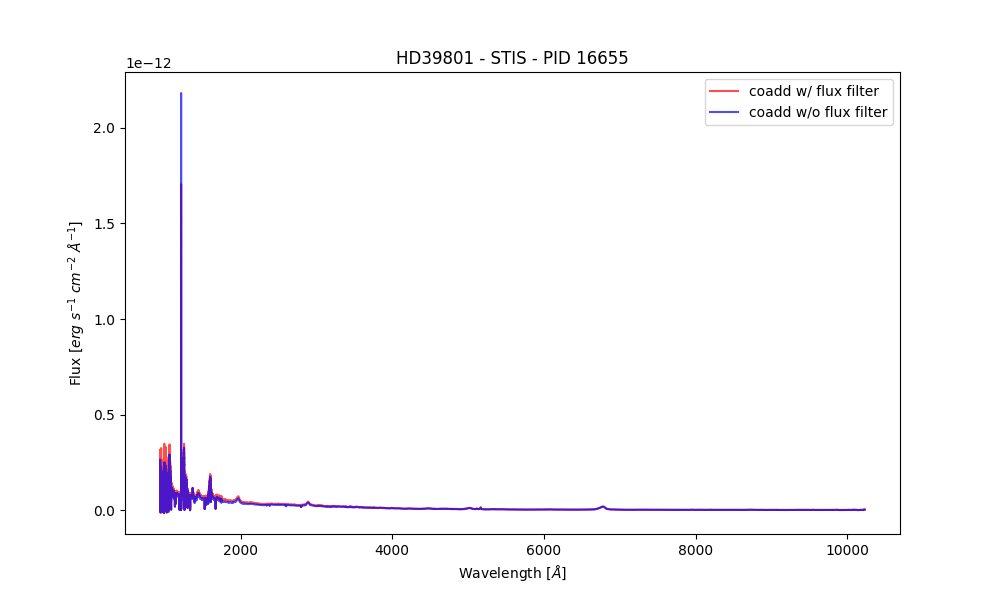

In [35]:
# Clear the older plot
plt.close()
plt.figure(6)

fn = 'hst_16196_cos-stis_mrk-817_g130m-g160m-sg230l-g430l-g750l_lede_cspec.fits'

# Plot the old coadd
oldcoaddfile = os.path.join(datadir_ex3, 'products', fn)
oldcoadddata = fits.getdata(oldcoaddfile)
oldwavelength = oldcoadddata['wavelength'][0]
oldflux = oldcoadddata['flux'][0]

plt.plot(downsample_1d(oldwavelength, samplefactor),
         downsample_1d(oldflux, samplefactor),
         label='coadd w/ flux filter',
         color="red",
         alpha=0.7)

# Plot the new coadd
newcoaddfile = os.path.join(datadir_ex3, 'products_nofluxfilter', fn)
newcoadddata = fits.getdata(newcoaddfile)
newwavelength = newcoadddata['wavelength'][0]
newflux = newcoadddata['flux'][0]

plt.plot(downsample_1d(newwavelength, samplefactor),
         downsample_1d(newflux, samplefactor),
         label='coadd w/o flux filter',
         color="blue",
         alpha=0.7)

targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

plt.title(r'{} - {} - PID {}'.format(targ, ins, pid))
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.legend()

# Show the plot below
plt.show()

The plot above shows that the flux is lower in the dataset made without the flux checker on. This means that the previously-rejected datasets were of lower flux. However, zooming in on some of the absorption features, we can see that the wings of some lines are broader in the dataset with no flux rejection, which can be useful in some science cases where these features are faint.

# Happy co-adding!

### There are more tutorial notebooks for custom co-addition cases in [this repo](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup), check them out!

## About this Notebook
**Author:** Elaine Frazer (efrazer@stsci.edu), Sierra Gomez (sigomez@stsci.edu)

**Updated on:** 02/22/2024

*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `astroquery`, `numpy`, or `matplotlib`, for published research, please cite the authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)

* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)

* [Citing `numpy`](https://numpy.org/citing-numpy/)

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 